# Group No: 20

## Group Members Names:

 1. Peyala Samarasimha Reddy - 2023AA05072
 2. Shruti S Kumar - 2023AA05152 
 3. Sreelakshmi Ajith - 2023AA05316 
 4. Akshay Mohan - 2023AA05315

## Assignment 2 - Experiment with GAN

# Task 1

Implement and train a conditional Wesserstein GAN with CIFAR10 dataset. Generate and display 10 new images belonging to 'automobile' class. Report IS and FID scores.

## Import all dependencies

In [1]:
# Import All necessary libraries and dependencies

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import CIFAR10
from torchvision.models.inception import inception_v3
from scipy.linalg import sqrtm
import torchvision.utils as vutils
from tqdm import tqdm


## Load the CIFAR10 dataset and apply the necessary transformations

### CIFAR-10 Dataset  

### Introduction  

The **CIFAR-10** (Canadian Institute for Advanced Research) dataset is a widely used benchmark dataset for image classification and generative modeling. It consists of **60,000 color images** categorized into **10 different classes**, with each image having a resolution of **32x32 pixels**.  

### Dataset Composition  

- **Total Images**: 60,000  
  - **Training Set**: 50,000 images  
  - **Test Set**: 10,000 images  
- **Image Shape**: (3, 32, 32) → (Channels, Height, Width)  
- **Color Mode**: RGB (3 color channels)  
- **Label Classes**: 10  

#### CIFAR-10 Classes:  
1. **Airplane**  
2. **Automobile**  
3. **Bird**  
4. **Cat**  
5. **Deer**  
6. **Dog**  
7. **Frog**  
8. **Horse**  
9. **Ship**  
10. **Truck**  

Each class has **6,000 images**, equally distributed across the training and test sets.

### Characteristics  

- **Small Image Size**: Each image is only 32x32 pixels, making it computationally efficient for deep learning experiments.  
- **Diverse Object Categories**: The dataset includes a mix of vehicles, animals, and objects, providing a good benchmark for classification tasks.  
- **Balanced Dataset**: Each class has the same number of samples, reducing data bias.  

### Usage in Deep Learning  

CIFAR-10 is commonly used for:  
- **Image Classification** using Convolutional Neural Networks (CNNs).  
- **Generative Models** such as GANs and VAEs.  
- **Semi-Supervised and Unsupervised Learning** experiments.  

It serves as a **standard benchmark** for testing and evaluating deep learning models in computer vision.  


In [2]:
# Define transformation for preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset
dataset = CIFAR10(root="./data", train=True, transform=transform, download=True)

# Print dataset size and image shape
print(f"Dataset Size: {len(dataset)}")
print(f"Sample Image Shape: {dataset[0][0].shape}")  # (C, H, W)


Dataset Size: 50000
Sample Image Shape: torch.Size([3, 32, 32])


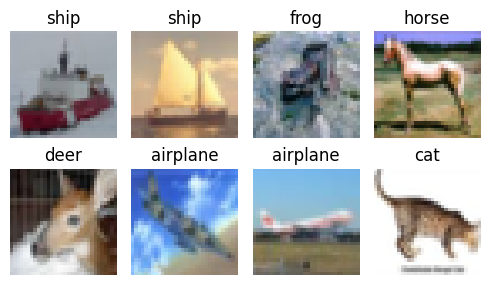

In [3]:
# Display Sample CIFAR 10 Dataset Images

import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Load CIFAR-10 dataset
dataset = CIFAR10(root="./data", train=True, transform=transforms.ToTensor(), download=True)

# Get 8 random images
indices = np.random.choice(len(dataset), 8, replace=False)
sample_images = [dataset[i][0] for i in indices]
sample_labels = [dataset[i][1] for i in indices]

# Class labels in CIFAR-10
class_names = [
    "airplane", "automobile", "bird", "cat", "deer", 
    "dog", "frog", "horse", "ship", "truck"
]

# Display images without blurring
fig, axes = plt.subplots(2, 4, figsize=(5,3))
for i, ax in enumerate(axes.flat):
    img = sample_images[i].permute(1, 2, 0).numpy()  # Convert to (H, W, C)
    img = (img * 255).astype(np.uint8)  # Denormalize to [0, 255]
    ax.imshow(img, interpolation="nearest")  # Avoid blurring
    ax.set_title(class_names[sample_labels[i]])
    ax.axis("off")

plt.tight_layout()
plt.show()


In [4]:
# Get only 'automobile' class (label=1)
automobile_indices = [i for i in range(len(dataset)) if dataset.targets[i] == 1]
filtered_dataset = Subset(dataset, automobile_indices)

# Create DataLoader
batch_size = 64
dataloader = DataLoader(filtered_dataset, batch_size=batch_size, shuffle=True)

# Print filtered dataset size
print(f"Filtered Dataset Size (Automobile Only): {len(filtered_dataset)}")


Filtered Dataset Size (Automobile Only): 5000


## Design conditional Wesserstein GAN Model

### Conditional Wasserstein GAN (CWGAN) with CIFAR-10  

CWGAN extends WGAN by conditioning image generation on class labels, allowing controlled image synthesis.  

#### **Key Features:**  
- **Wasserstein loss** for stable training.  
- **Gradient penalty** enforces Lipschitz constraint.  
- **Label embeddings** enable class-conditioned generation.  

#### **Generator:**  
- Takes **latent vector (z)** + **class label** as input.  
- **Label embedding** maps labels to latent space.  
- Uses **ReLU** for non-linearity, **Tanh** for image scaling.  

#### **Discriminator:**  
- Takes **image + label** as input.  
- Uses **label embedding** + **convolutions** to extract features.  
- Outputs a scalar "realness" score (no Sigmoid).  

#### **Gradient Penalty:**  
- Enforces **Lipschitz constraint** (stabilizes training).  
- Computes **gradient norm** on interpolated real & fake images.  
- Penalizes deviations from norm = 1.  


In [5]:
# Define Generator

# Generator network for Conditional Wasserstein GAN (CWGAN)
class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes, img_shape):
        """
        Generator network that takes random noise and class labels as input
        and generates an image.

        Parameters:
        - latent_dim: Dimensionality of the latent space (random noise vector).
        - num_classes: Number of classes in the dataset (for conditional generation).
        - img_shape: Shape of the output image (e.g., (3, 32, 32) for CIFAR).
        """
        super(Generator, self).__init__()
        
        # Embedding layer to convert class labels into dense representations
        self.label_embedding = nn.Embedding(num_classes, latent_dim)

        # Fully connected network to transform latent vector into an image
        self.model = nn.Sequential(
            nn.Linear(latent_dim * 2, 512),  # Input is noise + label embedding
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3 * 32 * 32),  # Output size matches the flattened image
            nn.Tanh()  # Normalize outputs to [-1, 1] (common for image generation)
        )

        self.img_shape = img_shape  # Store the shape of the output image

    def forward(self, z, labels):
        """
        Forward pass for the generator.

        Parameters:
        - z: Latent noise vector.
        - labels: Class labels corresponding to the images to be generated.

        Returns:
        - Generated image tensor.
        """
        label_embedding = self.label_embedding(labels)  # Convert labels to embeddings
        gen_input = torch.cat((z, label_embedding), dim=1)  # Concatenate noise and labels
        img = self.model(gen_input)  # Generate the image
        img = img.view(img.shape[0], *self.img_shape)  # Reshape to image format
        return img

In [6]:

# Discriminator network for Conditional Wasserstein GAN (CWGAN)
class Discriminator(nn.Module):
    def __init__(self, num_classes, img_shape):
        """
        Discriminator network that classifies whether an image is real or fake.

        Parameters:
        - num_classes: Number of classes in the dataset.
        - img_shape: Shape of the input image.
        """
        super(Discriminator, self).__init__()

        # Embedding layer to convert class labels into dense representations
        self.label_embedding = nn.Embedding(num_classes, int(np.prod(img_shape)))

        # Convolutional neural network for image classification
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # First conv layer
            nn.LeakyReLU(0.2),  # LeakyReLU activation function

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Downsampling
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Further downsampling
            nn.LeakyReLU(0.2),

            nn.Flatten(),  # Flatten tensor for fully connected layer
            nn.Linear(256 * 8 * 8, 1)  # Output single scalar (Wasserstein distance)
        )

    def forward(self, img, labels):
        """
        Forward pass for the discriminator.

        Parameters:
        - img: Input image tensor.
        - labels: Class labels (not used in the model, should be incorporated).

        Returns:
        - Discriminator score (real/fake classification).
        """
        return self.model(img)

In [7]:
# Function to compute the gradient penalty for Wasserstein GAN (WGAN-GP)
def compute_gradient_penalty(D, real_samples, fake_samples):
    """
    Computes the gradient penalty required for stabilizing the WGAN training.

    Parameters:
    - D: The discriminator network.
    - real_samples: A batch of real images.
    - fake_samples: A batch of generated (fake) images.

    Returns:
    - Gradient penalty scalar.
    """
    
    # Interpolation factor (randomly sampled for each image in the batch)
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(real_samples.device)

    # Create interpolated images: mix of real and fake images
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Compute the discriminator output for interpolated images
    d_interpolates = D(interpolates, torch.zeros_like(labels))

    # Create a tensor of ones for computing gradients
    fake = torch.ones(d_interpolates.shape, requires_grad=False).to(real_samples.device)

    # Compute gradients of the outputs with respect to the interpolated inputs
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Reshape gradients and compute the gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

In [9]:
import torch.optim as optim

# ------------------------------
# Hyperparameters for CWGAN-GP
# ------------------------------
latent_dim = 100  # Size of the latent space (random noise vector)
img_shape = (3, 32, 32)  # Shape of the generated images (CIFAR-10: 3x32x32)
num_classes = 10  # Number of classes in the dataset (CIFAR-10 has 10 classes)
n_epochs = 1200  # Number of training epochs
lambda_gp = 10  # Gradient penalty coefficient for WGAN-GP
lr = 0.0002  # Learning rate for both Generator and Discriminator
critic_iterations = 5  # Number of discriminator updates per generator update

# ------------------------------
# Initialize Generator & Discriminator
# ------------------------------
generator = Generator(latent_dim, num_classes, img_shape).cuda()  
discriminator = Discriminator(num_classes, img_shape).cuda()  

# ------------------------------
# Define Optimizers
# ------------------------------
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))  
# Adam optimizer for Generator with betas (0.5, 0.9) for stable training

optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))  
# Adam optimizer for Discriminator with the same learning rate and betas


## Model Training

In [10]:
import torch
import torch.nn.functional as F

# ------------------------------
# Training Loop
# ------------------------------
for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        # Move images and labels to GPU
        imgs, labels = imgs.cuda(), labels.cuda()
        batch_size = imgs.shape[0]

        # ------------------------------
        # Train Discriminator (Critic)
        # ------------------------------
        # Sample random noise vector z
        z = torch.randn(batch_size, latent_dim).cuda()
        
        # Generate fake images using the Generator
        fake_imgs = generator(z, labels)

        # Compute discriminator outputs for real and fake images
        real_validity = discriminator(imgs, labels)  # Discriminator output on real images
        fake_validity = discriminator(fake_imgs.detach(), labels)  # Detach fake images to avoid updating Generator

        # Compute gradient penalty for improved stability
        gp = compute_gradient_penalty(discriminator, imgs, fake_imgs)

        # Compute Wasserstein loss with gradient penalty
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp

        # Backpropagation and optimizer step for Discriminator
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # ------------------------------
        # Train Generator
        # ------------------------------
        if i % critic_iterations == 0:  # Update Generator after 'critic_iterations' Discriminator updates
            # Generate new fake images
            fake_imgs = generator(z, labels)

            # Compute Generator loss (maximize discriminator's belief in fake images)
            g_loss = -torch.mean(discriminator(fake_imgs, labels))

            # Backpropagation and optimizer step for Generator
            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

    # Print progress
    print(f"Epoch {epoch}/{n_epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


/home/samara/anaconda3/envs/ml-env/lib/python3.11/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0/1200 | D Loss: 5.8842 | G Loss: 22.1196
Epoch 1/1200 | D Loss: -8.4648 | G Loss: 45.1789
Epoch 2/1200 | D Loss: -13.0457 | G Loss: 32.0729
Epoch 3/1200 | D Loss: -9.7974 | G Loss: 42.7549
Epoch 4/1200 | D Loss: -8.7008 | G Loss: 26.8025
Epoch 5/1200 | D Loss: -7.5112 | G Loss: 22.8392
Epoch 6/1200 | D Loss: -8.1206 | G Loss: -1.1449
Epoch 7/1200 | D Loss: -5.8079 | G Loss: -5.3345
Epoch 8/1200 | D Loss: -11.6542 | G Loss: -14.3306
Epoch 9/1200 | D Loss: -11.2857 | G Loss: -19.9068
Epoch 10/1200 | D Loss: -6.8638 | G Loss: -20.1528
Epoch 11/1200 | D Loss: -8.3848 | G Loss: -2.7722
Epoch 12/1200 | D Loss: -8.5709 | G Loss: -12.1522
Epoch 13/1200 | D Loss: -9.3821 | G Loss: -10.4852
Epoch 14/1200 | D Loss: -6.9420 | G Loss: -14.8771
Epoch 15/1200 | D Loss: -6.9649 | G Loss: -18.6731
Epoch 16/1200 | D Loss: -6.5027 | G Loss: -21.5647
Epoch 17/1200 | D Loss: -8.7913 | G Loss: -14.8573
Epoch 18/1200 | D Loss: -4.8672 | G Loss: -15.1279
Epoch 19/1200 | D Loss: -5.0767 | G Loss: -10.39

## Generate New Images

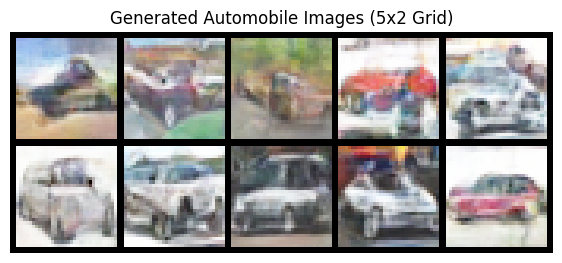

In [17]:
import torch
import numpy as np
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# ------------------------------
# Generate 10 Images of Automobiles
# ------------------------------

# Sample random noise vector z (10 samples from latent space)
z = torch.randn(10, latent_dim).cuda()

# Create label tensor for automobiles (CIFAR-10 class index for 'automobile' is 1)
labels = torch.full((10,), 1).cuda()  

# Generate images using the trained Generator
gen_imgs = generator(z, labels).cpu().detach()  # Move to CPU and detach from computation graph

# ------------------------------
# Convert Images to Grid
# ------------------------------

# Create an image grid with 5 images per row, normalizing pixel values for display
grid_img = vutils.make_grid(gen_imgs, nrow=5, normalize=True)

# ------------------------------
# Display Generated Images
# ------------------------------

# Create a matplotlib figure
plt.figure(figsize=(7, 5))  # Set figure size

# Convert (C, H, W) image format to (H, W, C) for displaying with matplotlib
plt.imshow(np.transpose(grid_img.numpy(), (1, 2, 0)))

plt.axis("off")

plt.title("Generated Automobile Images (5x2 Grid)")

plt.show()


## **CWGAN Evaluation: IS & FID**  

### Inception Score (IS)  
- Measures **image quality & diversity** using a pre-trained Inception model.  
- **Higher IS = Better** (more diverse & clear images).  
- **Limitation:** Doesn't compare with real images.  

### Fréchet Inception Distance (FID)  
- Compares **feature distributions** between real & generated images.  
- **Lower FID = Better** (more realistic images).  
- More **reliable** than IS for detecting mode collapse.  



In [19]:
from torchvision.models.inception import inception_v3
import torch
import torch.nn.functional as F
import numpy as np

def calculate_inception_score(generator, num_images=500, batch_size=50, latent_dim=100, num_classes=10):
    """
    Computes the Inception Score (IS) for a given generator model.
    
    Parameters:
        generator (torch.nn.Module): The generative model to evaluate.
        num_images (int): Total number of images to generate for evaluation.
        batch_size (int): Number of images per batch.
        latent_dim (int): Dimensionality of the latent space (input noise vector).
        num_classes (int): Number of classes for conditional generation.
    
    Returns:
        float: The computed Inception Score.
    """
    generator.eval()  # Set generator to evaluation mode
    
    # Load pretrained InceptionV3 model (used for feature extraction)
    inception_model = inception_v3(pretrained=True, transform_input=False).cuda()
    inception_model.fc = torch.nn.Identity()  # Remove final fully connected layer
    inception_model.eval()

    all_preds = []  # Store softmax probabilities from InceptionV3
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for _ in range(num_images // batch_size):
            # Sample random noise and class labels
            z = torch.randn(batch_size, latent_dim).cuda()
            labels = torch.randint(0, num_classes, (batch_size,)).cuda()
            
            # Generate fake images using the generator
            fake_imgs = generator(z, labels)
            
            # Resize images to 299x299 to match InceptionV3 input size
            fake_imgs = F.interpolate(fake_imgs, size=(299, 299), mode="bilinear")
            
            # Get softmax predictions from InceptionV3
            preds = F.softmax(inception_model(fake_imgs), dim=1)
            all_preds.append(preds.cpu().numpy())

    # Concatenate all predictions
    all_preds = np.concatenate(all_preds, axis=0)
    
    # Compute KL divergence between conditional and marginal distributions
    kl_div = all_preds * (np.log(all_preds) - np.log(np.expand_dims(np.mean(all_preds, axis=0), 0)))
    
    # Compute Inception Score (exponential of the mean KL divergence)
    inception_score = np.exp(np.mean(np.sum(kl_div, axis=1)))

    generator.train()  # Restore generator to training mode
    return inception_score

# Compute and print Inception Score
inception_score = calculate_inception_score(generator)
print(f"Inception Score (IS): {inception_score:.3f}")


Inception Score (IS): 1.144


In [24]:
import os
import torch
from torchvision.utils import save_image
from pytorch_fid.fid_score import calculate_fid_given_paths

# Define directories for storing real and fake images
fake_dir = "./fake_images"
real_dir = "./real_images"
os.makedirs(fake_dir, exist_ok=True)
os.makedirs(real_dir, exist_ok=True)

# Generate and save 10000 fake images
with torch.no_grad():  # Disable gradients for faster inference
    for i in range(10000):
        z = torch.randn(1, latent_dim).cuda()  # Sample random noise
        label = torch.randint(0, num_classes, (1,)).cuda()  # Sample random class label
        
        fake_img = generator(z, label)  # Generate fake image
        
        # Convert image range from [-1,1] to [0,1] and save
        save_image((fake_img + 1) / 2, os.path.join(fake_dir, f"{i}.png"))

# Save 10000 real images from the dataset
for i in range(10000):
    real_img, _ = dataset[i]  # Get real image from dataset
    
    # Convert image range from [-1,1] to [0,1] and save
    save_image((real_img + 1) / 2, os.path.join(real_dir, f"{i}.png"))

# Compute the Fréchet Inception Distance (FID) between real and fake images
fid_score = calculate_fid_given_paths([real_dir, fake_dir], batch_size=50, device="cuda", dims=2048)

# Print the computed FID score
print(f"Fréchet Inception Distance (FID): {fid_score:.3f}")


100%|██████████| 200/200 [00:22<00:00,  8.70it/s]


Fréchet Inception Distance (FID): 111.270


# Task 2

Implement and train a SNGAN with CIFAR10 dataset. Generate and display 10 new images. Report IS and FID scores.

## Import all dependencies

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from tqdm import tqdm
from scipy.linalg import sqrtm
from torchvision.models.inception import inception_v3
from torchvision.datasets import CIFAR10
import torch.nn.utils.spectral_norm as spectral_norm

## Load Data and display Sample data

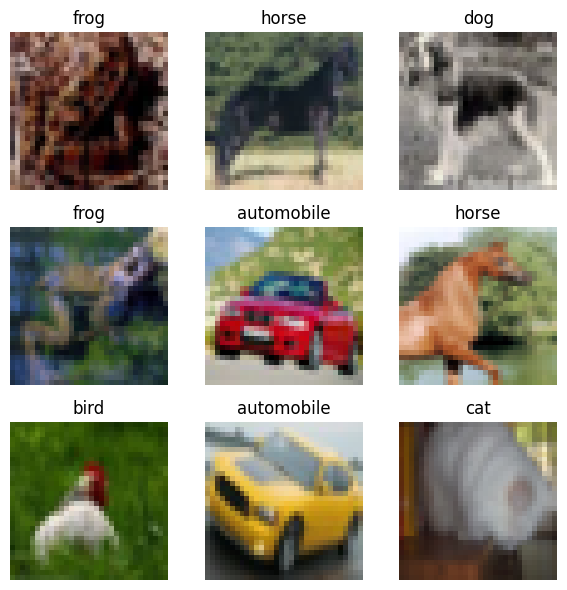

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

# Load CIFAR-10 dataset
batch_size = 64
dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Function to denormalize images (convert back to original)
def denormalize(img):
    img = img * 0.5 + 0.5  # Reverse normalization
    return img.clamp(0, 1)  # Ensure pixel values are in range [0,1]

# Get a batch of images
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Convert images for display
images = images[:9]  # Take first 9 images
images = denormalize(images)  # Convert back to original pixel values

# Display images
fig, axes = plt.subplots(3, 3, figsize=(6,6))
classes = dataset.classes  # CIFAR-10 class names

for i, ax in enumerate(axes.flat):
    img = np.transpose(images[i].numpy(), (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    ax.imshow(img)
    ax.axis("off")  # Hide axis labels
    ax.set_title(classes[labels[i].item()])  # Show class label

plt.tight_layout()
plt.show()


## Define SNGAN Model

## Spectral Normalization GAN (SNGAN)

### What is SNGAN?
Spectral Normalization GAN (SNGAN) is a type of Generative Adversarial Network (GAN) that stabilizes training by applying spectral normalization to the discriminator's weight matrices. This helps control the Lipschitz constant, improving training stability and preventing gradient explosion.

### Key Features
- Uses **spectral normalization** to regularize the discriminator.  
- Employs **hinge loss** for better gradient propagation.  
- Improves **training stability** and reduces mode collapse.  
- Enables the generation of **high-quality** and **diverse** images.

### Architecture
#### Generator
- Takes a random noise vector **z** as input.  
- Passes through **transpose convolutional layers** with batch normalization and ReLU activation.  
- Outputs an image using a **tanh** activation function.

#### Discriminator
- Processes input images through **spectral-normalized convolutional layers**.  
- Uses **LeakyReLU** activations instead of batch normalization.  
- Outputs a single scalar value representing real or fake probability.


### Advantages
- More stable training compared to standard GANs.  
- Generates sharper and more realistic images.  
- Less sensitive to hyperparameter tuning.



### Generator

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim=128, channels=3):
        """
        Generator for SNGAN.

        Args:
        - z_dim (int): Dimension of the input noise vector.
        - channels (int): Number of output image channels (3 for RGB images).
        """
        super(Generator, self).__init__()
        self.z_dim = z_dim  # Store latent vector dimension

        # Define the generator model using transposed convolution layers
        self.model = nn.Sequential(
            # First transposed convolution layer
            # Input: (batch_size, z_dim, 1, 1) → Output: (batch_size, 256, 4, 4)
            spectral_norm(nn.ConvTranspose2d(z_dim, 256, 4, 1, 0, bias=False)),
            nn.BatchNorm2d(256),  # Normalize activations for stable training
            nn.ReLU(),  # Activation function to introduce non-linearity

            # Second transposed convolution layer
            # Output: (batch_size, 128, 8, 8)
            spectral_norm(nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Third transposed convolution layer
            spectral_norm(nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Fourth (Final) transposed convolution layer
            spectral_norm(nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False)),
            nn.Tanh()  # Tanh activation to scale the output to [-1, 1]
        )

    def forward(self, z):
        """
        Forward pass of the generator.

        Args:
        - z (Tensor): Random noise input of shape (batch_size, z_dim)

        Returns:
        - Tensor: Generated image of shape (batch_size, channels, 32, 32)
        """
        # Reshape input noise from (batch_size, z_dim) to (batch_size, z_dim, 1, 1)
        # Necessary because ConvTranspose2d expects a 4D input
        return self.model(z.view(z.size(0), self.z_dim, 1, 1))


### Discriminator

In [4]:
class Discriminator(nn.Module):
    def __init__(self, channels=3):
        """
        Discriminator for SNGAN.

        Args:
        - channels (int): Number of input image channels (3 for RGB images).
        
        This network classifies input images as real or fake using 
        spectral normalization to stabilize training.
        """
        super(Discriminator, self).__init__()

        # Define the discriminator model using convolutional layers
        self.model = nn.Sequential(
            # First convolutional layer
            spectral_norm(nn.Conv2d(channels, 64, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),  # Activation function

            # Second convolutional layer
            spectral_norm(nn.Conv2d(64, 128, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),

            # Third convolutional layer
            spectral_norm(nn.Conv2d(128, 256, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),

            # Flattening the 3D tensor into a 1D vector
            nn.Flatten(),

            # Fully connected layer for final decision
            spectral_norm(nn.Linear(256 * 4 * 4, 1, bias=False))
        )

    def forward(self, x):
        """
        Forward pass of the discriminator.

        Args:
        - x (Tensor): Input image of shape (batch_size, channels, 32, 32)

        Returns:
        - Tensor: Output score of shape (batch_size, 1), where higher values indicate real images.
        """
        return self.model(x)


### Initialize Parameters

In [6]:
batch_size = 128
z_dim = 128
lr = 2e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_data = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Initialize networks
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss Function (Hinge Loss)
def generator_loss(fake_output):
    return -torch.mean(fake_output)

def discriminator_loss(real_output, fake_output):
    return torch.mean(nn.ReLU()(1.0 - real_output)) + torch.mean(nn.ReLU()(1 + fake_output))

In [8]:
# Print architectures
print("Generator Architecture:\n", generator)
print("\nDiscriminator Architecture:\n", discriminator)

Generator Architecture:
 Generator(
  (model): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

Discriminator Architecture:
 Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 12

## Training Model

In [9]:
# Training the model for 100 epochs

epochs = 1000
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        optimizer_D.zero_grad()
        z = torch.randn(batch_size, z_dim, device=device)
        fake_images = generator(z)
        real_output = discriminator(real_images)
        fake_output = discriminator(fake_images.detach())
        d_loss = discriminator_loss(real_output, fake_output)
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        fake_output = discriminator(fake_images)
        g_loss = generator_loss(fake_output)
        g_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}], Step [{i}/{len(train_loader)}], D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")

Epoch [0/1000], Step [0/391], D Loss: 2.057753324508667, G Loss: 0.09874007105827332
Epoch [0/1000], Step [100/391], D Loss: 1.5996036529541016, G Loss: 0.26119232177734375
Epoch [0/1000], Step [200/391], D Loss: 0.8123268485069275, G Loss: 0.5511060953140259
Epoch [0/1000], Step [300/391], D Loss: 1.1525884866714478, G Loss: 0.02156250551342964
Epoch [1/1000], Step [0/391], D Loss: 1.7490516901016235, G Loss: -0.2928437292575836
Epoch [1/1000], Step [100/391], D Loss: 1.3838616609573364, G Loss: 0.18004736304283142
Epoch [1/1000], Step [200/391], D Loss: 1.3206825256347656, G Loss: 0.14587949216365814
Epoch [1/1000], Step [300/391], D Loss: 1.5472018718719482, G Loss: 0.10020303726196289
Epoch [2/1000], Step [0/391], D Loss: 1.2200322151184082, G Loss: 0.4678376317024231
Epoch [2/1000], Step [100/391], D Loss: 2.047368049621582, G Loss: -0.48112958669662476
Epoch [2/1000], Step [200/391], D Loss: 2.039318084716797, G Loss: -0.3456525504589081
Epoch [2/1000], Step [300/391], D Loss: 1.

## Generate and Display Images

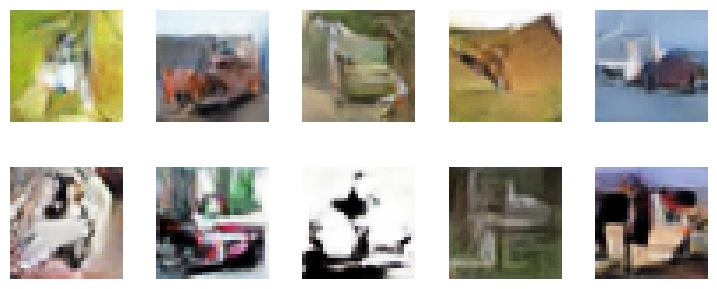

In [11]:
# Function to display generated images in two rows with padding
def generate_images(generator, num_images=10, rows=2, image_size=1, padding=0.2):
    """
    Generates and displays fake images from the generator in a compact grid with padding.

    Args:
    - generator (nn.Module): Trained generator model.
    - num_images (int): Total number of images to generate.
    - rows (int): Number of rows in the display grid.
    - image_size (float): Size of each individual image in the grid.
    - padding (float): Space between images.

    Returns:
    - None (Displays the generated images)
    """
    generator.eval()  # Set generator to evaluation mode

    # Generate random latent vectors
    z = torch.randn(num_images, z_dim, device=device)

    # Generate fake images
    fake_images = generator(z).cpu().detach()
    fake_images = (fake_images + 1) / 2  # Rescale from [-1,1] to [0,1]

    # Determine the number of columns based on rows
    cols = num_images // rows

    # Create a figure with subplots (adjust size)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * image_size, rows * image_size))

    # Flatten axes array for easier indexing
    axes = axes.flatten()

    for i in range(num_images):
        axes[i].imshow(np.transpose(fake_images[i].numpy(), (1, 2, 0)))
        axes[i].axis('off')

    # Adjust spacing between images
    plt.subplots_adjust(wspace=padding, hspace=padding)
    plt.show()

# Generate and display 10 images in 2 rows with padding
generate_images(generator, num_images=10, rows=2, image_size=1.8, padding=0.3)


## Evaluate Performance (FID & Inception Score)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------
# Generate 1000 Fake Images
# --------------------------

def generate_fake_images(generator, num_images=10000, z_dim=128, batch_size=100):
    generator.eval()
    fake_images = []
    
    with torch.no_grad():
        for _ in range(num_images // batch_size):
            z = torch.randn(batch_size, z_dim, device=device)
            fake_batch = generator(z).cpu().detach()
            fake_images.append(fake_batch)

    return torch.cat(fake_images, dim=0)

# Generate images
num_fake_images = 1000
fake_images = generate_fake_images(generator, num_images=num_fake_images)

# --------------------------
# Compute Inception Score (IS)
# --------------------------

def inception_score(fake_images, batch_size=32):
    inception = inception_v3(pretrained=True, transform_input=True).to(device)
    inception.eval()

    preds = []
    with torch.no_grad():
        for i in range(0, len(fake_images), batch_size):
            batch = fake_images[i:i + batch_size].to(device)
            batch = torch.nn.functional.interpolate(batch, size=(299, 299), mode="bilinear", align_corners=False)
            pred = inception(batch).softmax(dim=1).cpu().numpy()
            preds.append(pred)

    preds = np.concatenate(preds, axis=0)
    kl_div = preds * (np.log(preds) - np.log(np.expand_dims(np.mean(preds, axis=0), 0)))
    is_score = np.exp(np.mean(np.sum(kl_div, axis=1)))
    
    return is_score

# Compute IS
is_score = inception_score(fake_images)
print(f"Inception Score (IS): {is_score:.2f}")

# --------------------------
# Compute Fréchet Inception Distance (FID)
# --------------------------

def calculate_fid(real_loader, fake_images, batch_size=100):
    inception = inception_v3(pretrained=True, transform_input=True).to(device)
    inception.eval()

    real_features, fake_features = [], []

    # Extract features for real images
    with torch.no_grad():
        for real_batch, _ in real_loader:
            real_batch = real_batch.to(device)
            real_batch = torch.nn.functional.interpolate(real_batch, size=(299, 299), mode="bilinear", align_corners=False)
            real_features.append(inception(real_batch).cpu().numpy())

    # Extract features for fake images
    with torch.no_grad():
        for i in range(0, len(fake_images), batch_size):
            fake_batch = fake_images[i:i + batch_size].to(device)
            fake_batch = torch.nn.functional.interpolate(fake_batch, size=(299, 299), mode="bilinear", align_corners=False)
            fake_features.append(inception(fake_batch).cpu().numpy())

    real_features = np.concatenate(real_features, axis=0)
    fake_features = np.concatenate(fake_features, axis=0)

    # Compute mean and covariance
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    # Compute FID score
    fid = np.sum((mu_real - mu_fake) ** 2) + np.trace(sigma_real + sigma_fake - 2 * sqrtm(sigma_real @ sigma_fake))
    return np.real(fid)

/home/samara/anaconda3/envs/ml-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/samara/anaconda3/envs/ml-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception Score (IS): 3.35


In [ ]:
# Calculation of the FID score

# Load real images
batch_size = 10000
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
real_dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
real_loader = DataLoader(real_dataset, batch_size=batch_size, shuffle=True)

# Compute FID
fid_score = calculate_fid(real_loader, fake_images)
print(f"Fréchet Inception Distance (FID): {fid_score:.2f}")

Fréchet Inception Distance (FID): 56.17


# Task 3

Implement and train a variant of SAGAN without spectral normalization and TTUB  with CIFAR10 dataset. Generate 10 new images. Report IS and FID scores.

## Import all dependencies

In [1]:
# Import all necessary libraries and dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from tqdm import tqdm
from scipy.linalg import sqrtm
from torchvision.models.inception import inception_v3
from torchvision.datasets import CIFAR10
import torch.nn.utils.spectral_norm as spectral_norm
from torchvision.utils import save_image
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.datasets import CIFAR10


## Load Data and display Sample data

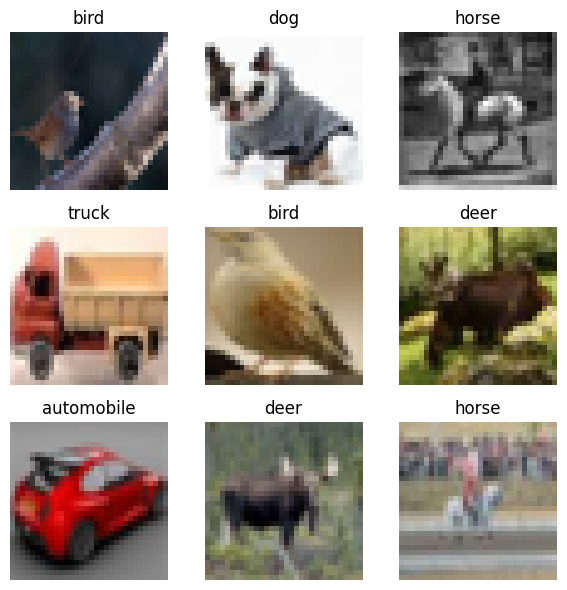

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

# Load CIFAR-10 dataset
batch_size = 64
dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Function to denormalize images (convert back to original)
def denormalize(img):
    img = img * 0.5 + 0.5  # Reverse normalization
    return img.clamp(0, 1)  # Ensure pixel values are in range [0,1]

# Get a batch of images
data_iter = iter(dataloader)
images, labels = next(data_iter)

# Convert images for display
images = images[:9]  # Take first 9 images
images = denormalize(images)  # Convert back to original pixel values

# Display images
fig, axes = plt.subplots(3, 3, figsize=(6,6))
classes = dataset.classes  # CIFAR-10 class names

for i, ax in enumerate(axes.flat):
    img = np.transpose(images[i].numpy(), (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    ax.imshow(img)
    ax.axis("off")  # Hide axis labels
    ax.set_title(classes[labels[i].item()])  # Show class label

plt.tight_layout()
plt.show()


# Define Model

### Variant of SAGAN Without Spectral Normalization and TTUB  

### **Overview**  
This version of **Self-Attention GAN (SAGAN)** removes **spectral normalization** and **TTUB** while retaining its **self-attention mechanism** for capturing long-range dependencies in images. Instead of spectral normalization, we rely on **batch normalization** and **adaptive optimizers (Adam)** for training stability.  

### **Architecture**  
#### **Generator**  
- Takes a **random noise vector** as input.  
- Uses **transposed convolutions** to upsample the feature maps.  
- **Self-Attention layers** are applied at intermediate stages for better feature refinement.  
- Outputs a **32×32 RGB image** using a **Tanh activation**.  

#### **Discriminator**  
- Uses **convolutional layers** to downsample the input image.  
- Incorporates **self-attention layers** to capture dependencies across distant pixels.  
- Instead of spectral normalization, it uses **batch normalization** and **LeakyReLU activations**.  
- Outputs a **real/fake probability score** using a **sigmoid activation**.  

This modification aims to balance **stability and expressiveness** while removing the constraints of spectral normalization.


In [3]:
# Hyperparameters
batch_size = 128
lr = 0.0002
epochs = 1000
z_dim = 128
image_size = 32
channels = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DataLoader
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)


## Self-Attention

In [4]:
# --------------------------------------
# Self-Attention Layer for capturing long-range dependencies
# --------------------------------------
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        
        # Query, Key, and Value transformations using 1x1 convolutions
        self.query = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.value = nn.Conv2d(in_channels, in_channels, 1)
        
        # Learnable scaling parameter (gamma) to control the impact of attention
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.size()

        # Compute Query and Key matrices
        query = self.query(x).view(B, -1, H * W).permute(0, 2, 1)  # (B, H*W, C//8)
        key = self.key(x).view(B, -1, H * W)  # (B, C//8, H*W)

        # Compute attention scores and apply softmax
        attn = F.softmax(torch.bmm(query, key), dim=-1)  # (B, H*W, H*W)

        # Compute Value matrix
        value = self.value(x).view(B, -1, H * W)  # (B, C, H*W)

        # Compute weighted sum of values based on attention scores
        out = torch.bmm(value, attn.permute(0, 2, 1)).view(B, C, H, W)

        # Apply gamma scaling and residual connection
        return self.gamma * out + x


## Generator

In [5]:

# --------------------------------------
# Generator Network (G) - Generates Fake Images
# --------------------------------------
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # Input: Latent vector (z_dim) -> 4x4 feature map
            nn.ConvTranspose2d(z_dim, 256, 4, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            SelfAttention(256),  # Apply self-attention at this stage

            # Upsample to 8x8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            SelfAttention(128),  # Another self-attention block

            # Upsample to 16x16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Upsample to 32x32 with final image output
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh()  # Output is scaled between [-1, 1]
        )

    def forward(self, z):
        return self.model(z)


## Discriminator

In [6]:
# --------------------------------------
# Discriminator Network (D) - Classifies Real vs. Fake Images
# --------------------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # Input: 32x32 Image -> Downsample to 16x16
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # Downsample to 8x8
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            SelfAttention(128),  # Apply self-attention here

            # Downsample to 4x4
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            SelfAttention(256),  # Another self-attention block

            # Output: Single value indicating real (1) or fake (0)
            nn.Conv2d(256, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Probability of real vs. fake
        )

    def forward(self, x):
        return self.model(x).view(-1, 1)  # Flatten output for classification


## Initialize Parameters

In [7]:
# Initialize Model
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

# Loss & Optimizer
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))


In [9]:
# Print architectures
print("Generator Architecture:\n", G)
print("\nDiscriminator Architecture:\n", D)

Generator Architecture:
 Generator(
  (model): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): SelfAttention(
      (query): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
      (key): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
      (value): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): SelfAttention(
      (query): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (key): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (value): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), pa

## Train Model

Due to heavy computation requirement and taking large time for the training, we limited to 300 epochs

In [10]:
# Training Loop

epochs=300

for epoch in range(epochs):
    for i, (real_images, _) in enumerate(trainloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Train Discriminator
        z = torch.randn(batch_size, z_dim, 1, 1, device=device)
        fake_images = G(z)
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        D_real = D(real_images)
        D_fake = D(fake_images.detach())

        loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        D_fake = D(fake_images)
        loss_G = criterion(D_fake, real_labels)
        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch+1}/{epochs}] | Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

Epoch [1/300] | Loss D: 0.3308, Loss G: 2.9128
Epoch [2/300] | Loss D: 0.6061, Loss G: 3.7701
Epoch [3/300] | Loss D: 0.7709, Loss G: 5.1804
Epoch [4/300] | Loss D: 0.5746, Loss G: 2.0650
Epoch [5/300] | Loss D: 0.5891, Loss G: 4.1253
Epoch [6/300] | Loss D: 0.2079, Loss G: 3.5060
Epoch [7/300] | Loss D: 0.5956, Loss G: 4.6262
Epoch [8/300] | Loss D: 0.2315, Loss G: 5.0954
Epoch [9/300] | Loss D: 1.0729, Loss G: 2.1168
Epoch [10/300] | Loss D: 0.3894, Loss G: 3.9231
Epoch [11/300] | Loss D: 0.5217, Loss G: 5.7779
Epoch [12/300] | Loss D: 0.1534, Loss G: 3.8564
Epoch [13/300] | Loss D: 0.2352, Loss G: 2.9118
Epoch [14/300] | Loss D: 0.1269, Loss G: 5.2458
Epoch [15/300] | Loss D: 0.0696, Loss G: 5.2036
Epoch [16/300] | Loss D: 0.3888, Loss G: 4.4117
Epoch [17/300] | Loss D: 0.4651, Loss G: 8.1379
Epoch [18/300] | Loss D: 0.2536, Loss G: 4.3784
Epoch [19/300] | Loss D: 0.2127, Loss G: 4.1233
Epoch [20/300] | Loss D: 0.1399, Loss G: 3.0715
Epoch [21/300] | Loss D: 0.1906, Loss G: 5.9885
E

## Generate and Display Images

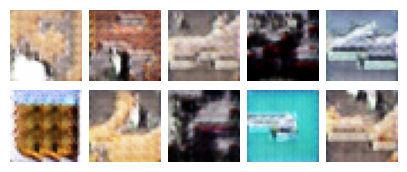

In [135]:
import matplotlib.pyplot as plt

# Function to Generate and Display Smaller Images in Two Rows with Padding
def generate_and_show_images(num_images=10):
    z = torch.randn(num_images, z_dim, 1, 1, device=device)
    fake_images = G(z).detach().cpu()

    # Save generated images
    save_image(fake_images, "generated_images.png", normalize=True)

    # Set up figure with smaller image size
    rows = 2
    cols = num_images // rows  
    fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))  # Smaller figsize
    fig.subplots_adjust(hspace=0.1, wspace=0.1)  

    # Plot images
    for i, img in enumerate(fake_images):
        ax = axes[i // cols, i % cols]  
        ax.imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)  
        ax.axis("off")

    plt.show()

# Generate and Display 10 random images
generate_and_show_images(10)


## Evaluate Performance (FID & Inception Score)

In [12]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.linalg import sqrtm
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models.inception import inception_v3

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Inception v3 Model (Feature Extractor)
inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
inception_model.fc = torch.nn.Identity()  # Remove final classification layer
inception_model.eval()

# Transformation for Inception v3 (Resize to 75x75)
transform = transforms.Compose([
    transforms.Resize((75, 75)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 Dataset
batch_size = 64
num_images = 10000  # Number of images for evaluation

cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
real_loader = DataLoader(cifar_dataset, batch_size=batch_size, shuffle=True)

# Function to Extract Features from Inception v3
def get_inception_features(dataloader, model, is_fake=False):
    features = []
    with torch.no_grad():
        for batch in dataloader:
            images = batch if is_fake else batch[0]  # Handle fake images (no labels)
            images = images.to(device)
            feat = model(images)
            features.append(feat.cpu().numpy())
    return np.vstack(features)

# Function to Compute Inception Score (IS)
def inception_score(images_loader, model, splits=10):
    preds = []
    with torch.no_grad():
        for img_batch in images_loader:
            for img in img_batch:  # Ensure correct 4D shape
                img = img.unsqueeze(0).to(device)
                pred = F.softmax(model(img), dim=1).cpu().numpy()
                preds.append(pred)

    preds = np.concatenate(preds, axis=0)
    split_scores = []

    for k in np.array_split(preds, splits):
        p_y = np.mean(k, axis=0)
        split_scores.append(np.exp(np.sum(p_y * np.log(p_y))))

    return np.mean(split_scores)

# Function to Compute FID Score
def calculate_fid(real_features, fake_features):
    mu_real, sigma_real = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)

    # Compute Square Root of Covariance Product
    cov_sqrt, _ = sqrtm(sigma_real @ sigma_fake, disp=False)
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real

    # Compute FID Score
    fid = np.sum((mu_real - mu_fake) ** 2) + np.trace(sigma_real + sigma_fake - 2 * cov_sqrt)
    return fid


/home/samara/anaconda3/envs/ml-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/samara/anaconda3/envs/ml-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:

# Generate Fake Images (Replace `G` with your Generator model)
z_dim = 128  # Latent space dimension
z = torch.randn(num_images, z_dim, 1, 1, device=device)
fake_images = G(z).detach().cpu()  # Replace `G` with your trained Generator

# Resize Fake Images to 75x75
fake_images_resized = F.interpolate(fake_images, size=(75, 75), mode='bilinear', align_corners=False)

# Create DataLoader for Fake Images
fake_loader = DataLoader(list(fake_images_resized), batch_size=batch_size, shuffle=False)

# Compute Features for FID
real_features = get_inception_features(real_loader, inception_model)
fake_features = get_inception_features(fake_loader, inception_model, is_fake=True)

In [ ]:
# Compute IS and FID
is_fake = inception_score(fake_loader, inception_model)

# Print Final Scores
print(f"Inception Score: {is_fake:.4f}")

Inception Score: 2.813


In [ ]:
fid_score = calculate_fid(real_features, fake_features)
print(f"FID Score (Fake vs Real): {fid_score:.4f}")

FID Score (Fake vs Real): 61.237


# Task 4

Implement and train a complete SAGAN with CIFAR10 dataset. Generate and display 10 new images. Report IS and FID scores.

## Import all dependencies

In [10]:
# Import all necessary Libraries and dependencies
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from pytorch_fid import fid_score
from scipy.stats import entropy

## Load Data and display Sample data

In [11]:
# Define image transformations for the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),   # Resize images to 32x32 pixels
    transforms.ToTensor(),   # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values to [-1, 1]
])

# Load CIFAR-10 dataset
dataset = torchvision.datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)

# Create a DataLoader for batch processing
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

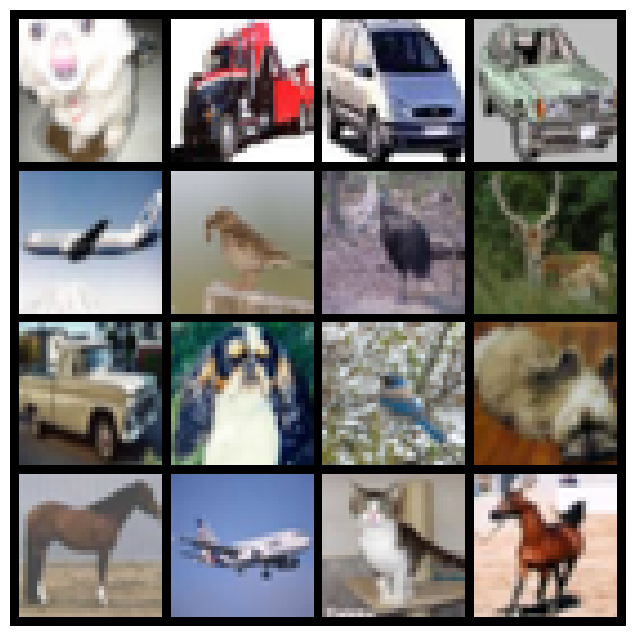

In [12]:
# Function to display a batch of images from the dataset
def show_images(dataloader, num_images=16):
    dataiter = iter(dataloader)
    images, labels = next(dataiter)  # Get a batch of images

    # Rescale images from [-1,1] to [0,1] for proper visualization
    images = (images + 1) / 2  
    grid = make_grid(images[:num_images], nrow=4)  # Create an image grid

    # Display the images
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0))  # Convert PyTorch format to (H, W, C)
    plt.axis("off")
    plt.show()

# Display sample images from the dataset
show_images(dataloader)


## Define Self-Attention GAN (SAGAN) Model

### **Complete Self-Attention Generative Adversarial Network (SAGAN)**

### **1. Introduction**
Self-Attention Generative Adversarial Network (SAGAN) is an advanced type of GAN that incorporates **self-attention mechanisms** to capture **long-range dependencies** in images. Traditional convolutional layers in GANs process local features well but struggle to model relationships between distant pixels. SAGAN solves this by integrating **self-attention layers**, allowing the model to focus on globally significant features.

### **2. How SAGAN Works**
SAGAN follows the standard **GAN architecture**, comprising:
- A **Generator** that creates synthetic images from random noise.
- A **Discriminator** that distinguishes between real and fake images.
- **Self-Attention layers** added to both the Generator and Discriminator to improve feature learning.

#### **Key Components**
1. **Self-Attention Layer**  
   - Instead of only relying on local receptive fields, this layer enables the model to attend to different regions of the image, improving **texture, object consistency, and fine-grained details**.
   - It computes relationships between all spatial positions in the feature maps.

2. **Generator (G)**
   - Takes a **random noise vector** and transforms it into an image.
   - Uses **deconvolution (ConvTranspose2d)** to upsample features progressively.
   - Includes a **self-attention block** to refine spatial details.

3. **Discriminator (D)**
   - Takes an image (real or fake) and determines its authenticity.
   - Uses **convolutions** to extract hierarchical features.
   - Includes a **self-attention block** to analyze non-local dependencies.

### **3. Why Use Self-Attention?**
- **Improved Image Quality**: SAGAN produces sharper and more coherent images.
- **Better Long-Range Feature Learning**: Unlike traditional CNNs, which rely on local information, self-attention allows global understanding.
- **Efficient Computation**: The attention mechanism is lightweight yet powerful for learning global relations.

### **4. Training Process**
1. **Load Dataset**: Use **CIFAR-10** dataset and preprocess images.
2. **Define the Model**: Implement Generator and Discriminator with self-attention.
3. **Train the Model**:
   - **Discriminator** learns to distinguish real from fake images.
   - **Generator** improves by generating images that fool the discriminator.
   - Uses **Binary Cross-Entropy (BCE) Loss** and **Adam optimizer**.
4. **Evaluate Performance**:
   - **Generated Image Quality**: Visually inspect outputs.
   - **FID Score**: Measures similarity between real and fake images.
   - **Inception Score**: Evaluates the diversity of generated images.

### **5. Applications**
SAGAN is widely used in:
- **High-Resolution Image Synthesis**
- **Artwork and Style Transfer**
- **Data Augmentation for Machine Learning Models**
- **Medical Imaging and Image Super-Resolution**


### Self-Attention Layer

In [13]:
# Self-Attention Layer for capturing long-range dependencies
class SelfAttention(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()

        # Query, Key, and Value transformations
        self.query = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.key = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        
        # Learnable scaling factor
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch, C, H, W = x.shape

        # Compute Query, Key, and Value matrices
        query = self.query(x).view(batch, -1, H * W).permute(0, 2, 1)  # Reshape & permute
        key = self.key(x).view(batch, -1, H * W)
        attn = torch.bmm(query, key)  # Compute attention scores
        attn = torch.softmax(attn, dim=-1)  # Normalize with softmax

        value = self.value(x).view(batch, -1, H * W)
        attn_value = torch.bmm(value, attn.permute(0, 2, 1))  # Apply attention
        attn_value = attn_value.view(batch, C, H, W)

        # Return attention-weighted output plus original input (residual connection)
        return self.gamma * attn_value + x


### Generator

In [14]:
# Generator model to create images from random noise
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            SelfAttention(128),  # Apply self-attention after upsampling

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Output scaled to range [-1,1]
        )

    def forward(self, z):
        return self.net(z)


### Discriminator

In [15]:
# Discriminator model to classify real vs. fake images
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            SelfAttention(128),  # Apply self-attention to feature maps

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()  # Output a probability score
        )

    def forward(self, x):
        return self.net(x).view(-1, 1)  # Flatten output


In [16]:
## Print the Generator and Discriminator Model Architectures

# Initialize models
z_dim = 100  # Size of random noise vector
generator = Generator(z_dim)
discriminator = Discriminator()

# Print architectures
print("Generator Architecture:\n", generator)
print("\nDiscriminator Architecture:\n", discriminator)


Generator Architecture:
 Generator(
  (net): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): SelfAttention(
      (query): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (key): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (value): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (7): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bi

## Define Parameters

In [17]:
# Define model parameters
epochs = 100
lr = 0.0002

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

# Define loss function (Binary Cross-Entropy)
criterion = nn.BCELoss()

# Define optimizers
optimizer_g = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

## Train the Model

In [19]:
# Training function
def train_sagan(generator, discriminator, dataloader, epochs=50):
    for epoch in range(epochs):
        for real_images, _ in tqdm(dataloader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)
            
            # Train Discriminator
            optimizer_d.zero_grad()
            z = torch.randn(batch_size, z_dim, 1, 1, device=device)
            fake_images = generator(z)
            d_real = discriminator(real_images)
            d_fake = discriminator(fake_images.detach())
            d_loss = criterion(d_real, real_labels) + criterion(d_fake, fake_labels)
            d_loss.backward()
            optimizer_d.step()

            # Train Generator
            optimizer_g.zero_grad()
            d_fake = discriminator(fake_images)
            g_loss = criterion(d_fake, real_labels)
            g_loss.backward()
            optimizer_g.step()

        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")

# Train the SAGAN model
train_sagan(generator, discriminator, dataloader, epochs=1000)

100%|██████████| 391/391 [00:05<00:00, 69.72it/s]


Epoch [1/1000] | D Loss: 0.4115 | G Loss: 3.4492


100%|██████████| 391/391 [00:05<00:00, 69.53it/s]


Epoch [2/1000] | D Loss: 0.3663 | G Loss: 3.5003


100%|██████████| 391/391 [00:05<00:00, 66.76it/s]


Epoch [3/1000] | D Loss: 1.0148 | G Loss: 2.6497


100%|██████████| 391/391 [00:05<00:00, 67.39it/s]


Epoch [4/1000] | D Loss: 0.1451 | G Loss: 3.8923


100%|██████████| 391/391 [00:05<00:00, 73.14it/s]


Epoch [5/1000] | D Loss: 0.3222 | G Loss: 2.9150


100%|██████████| 391/391 [00:05<00:00, 70.09it/s]


Epoch [6/1000] | D Loss: 0.4013 | G Loss: 4.1948


100%|██████████| 391/391 [00:05<00:00, 67.62it/s]


Epoch [7/1000] | D Loss: 0.3251 | G Loss: 3.0993


100%|██████████| 391/391 [00:05<00:00, 75.09it/s]


Epoch [8/1000] | D Loss: 0.3205 | G Loss: 3.2713


100%|██████████| 391/391 [00:05<00:00, 77.05it/s]


Epoch [9/1000] | D Loss: 0.2805 | G Loss: 3.1056


100%|██████████| 391/391 [00:05<00:00, 73.97it/s]


Epoch [10/1000] | D Loss: 0.4902 | G Loss: 4.6009


100%|██████████| 391/391 [00:05<00:00, 71.33it/s]


Epoch [11/1000] | D Loss: 0.4247 | G Loss: 5.3063


100%|██████████| 391/391 [00:05<00:00, 72.45it/s]


Epoch [12/1000] | D Loss: 0.3702 | G Loss: 2.0928


100%|██████████| 391/391 [00:05<00:00, 70.43it/s]


Epoch [13/1000] | D Loss: 0.2796 | G Loss: 3.9410


100%|██████████| 391/391 [00:06<00:00, 63.11it/s]


Epoch [14/1000] | D Loss: 0.3932 | G Loss: 3.3852


100%|██████████| 391/391 [00:05<00:00, 73.07it/s]


Epoch [15/1000] | D Loss: 0.1323 | G Loss: 3.7056


100%|██████████| 391/391 [00:06<00:00, 64.40it/s]


Epoch [16/1000] | D Loss: 0.2144 | G Loss: 4.7718


100%|██████████| 391/391 [00:05<00:00, 77.09it/s]


Epoch [17/1000] | D Loss: 0.1318 | G Loss: 4.4003


100%|██████████| 391/391 [00:05<00:00, 69.92it/s]


Epoch [18/1000] | D Loss: 0.3149 | G Loss: 3.7857


100%|██████████| 391/391 [00:05<00:00, 68.16it/s]


Epoch [19/1000] | D Loss: 0.2110 | G Loss: 3.7844


100%|██████████| 391/391 [00:05<00:00, 69.17it/s]


Epoch [20/1000] | D Loss: 0.3071 | G Loss: 2.7230


100%|██████████| 391/391 [00:05<00:00, 71.14it/s]


Epoch [21/1000] | D Loss: 0.2590 | G Loss: 4.2049


100%|██████████| 391/391 [00:05<00:00, 73.12it/s]


Epoch [22/1000] | D Loss: 0.1746 | G Loss: 2.8237


100%|██████████| 391/391 [00:05<00:00, 71.10it/s]


Epoch [23/1000] | D Loss: 0.1969 | G Loss: 3.0757


100%|██████████| 391/391 [00:05<00:00, 73.75it/s]


Epoch [24/1000] | D Loss: 0.1646 | G Loss: 4.3067


100%|██████████| 391/391 [00:06<00:00, 58.07it/s]


Epoch [25/1000] | D Loss: 0.0901 | G Loss: 4.6134


100%|██████████| 391/391 [00:05<00:00, 65.53it/s]


Epoch [26/1000] | D Loss: 0.1341 | G Loss: 3.8572


100%|██████████| 391/391 [00:05<00:00, 70.12it/s]


Epoch [27/1000] | D Loss: 0.0614 | G Loss: 5.0251


100%|██████████| 391/391 [00:05<00:00, 67.83it/s]


Epoch [28/1000] | D Loss: 0.2731 | G Loss: 5.2327


100%|██████████| 391/391 [00:05<00:00, 70.18it/s]


Epoch [29/1000] | D Loss: 0.0729 | G Loss: 4.5173


100%|██████████| 391/391 [00:06<00:00, 63.73it/s]


Epoch [30/1000] | D Loss: 0.0326 | G Loss: 5.4733


100%|██████████| 391/391 [00:06<00:00, 61.27it/s]


Epoch [31/1000] | D Loss: 0.0592 | G Loss: 5.2835


100%|██████████| 391/391 [00:06<00:00, 61.30it/s]


Epoch [32/1000] | D Loss: 0.1380 | G Loss: 5.2794


100%|██████████| 391/391 [00:06<00:00, 57.77it/s]


Epoch [33/1000] | D Loss: 0.0630 | G Loss: 4.9746


100%|██████████| 391/391 [00:06<00:00, 63.78it/s]


Epoch [34/1000] | D Loss: 0.1828 | G Loss: 2.5228


100%|██████████| 391/391 [00:06<00:00, 61.76it/s]


Epoch [35/1000] | D Loss: 0.0582 | G Loss: 5.0330


100%|██████████| 391/391 [00:07<00:00, 53.30it/s]


Epoch [36/1000] | D Loss: 0.1013 | G Loss: 4.7411


100%|██████████| 391/391 [00:06<00:00, 58.57it/s]


Epoch [37/1000] | D Loss: 0.1731 | G Loss: 5.4374


100%|██████████| 391/391 [00:07<00:00, 54.38it/s]


Epoch [38/1000] | D Loss: 0.0470 | G Loss: 4.8648


100%|██████████| 391/391 [00:07<00:00, 50.36it/s]


Epoch [39/1000] | D Loss: 0.0961 | G Loss: 4.5483


100%|██████████| 391/391 [00:06<00:00, 59.05it/s]


Epoch [40/1000] | D Loss: 0.2301 | G Loss: 6.4133


100%|██████████| 391/391 [00:07<00:00, 50.92it/s]


Epoch [41/1000] | D Loss: 0.1042 | G Loss: 4.8979


100%|██████████| 391/391 [00:07<00:00, 55.17it/s]


Epoch [42/1000] | D Loss: 0.0115 | G Loss: 5.6517


100%|██████████| 391/391 [00:07<00:00, 49.96it/s]


Epoch [43/1000] | D Loss: 0.0688 | G Loss: 4.2464


100%|██████████| 391/391 [00:07<00:00, 51.08it/s]


Epoch [44/1000] | D Loss: 0.0563 | G Loss: 5.0217


100%|██████████| 391/391 [00:08<00:00, 46.69it/s]


Epoch [45/1000] | D Loss: 0.1169 | G Loss: 3.2872


100%|██████████| 391/391 [00:10<00:00, 37.38it/s]


Epoch [46/1000] | D Loss: 0.1323 | G Loss: 4.2786


100%|██████████| 391/391 [00:09<00:00, 40.76it/s]


Epoch [47/1000] | D Loss: 0.1092 | G Loss: 4.9690


100%|██████████| 391/391 [00:11<00:00, 35.30it/s]


Epoch [48/1000] | D Loss: 0.1309 | G Loss: 3.8557


100%|██████████| 391/391 [00:11<00:00, 34.34it/s]


Epoch [49/1000] | D Loss: 0.0486 | G Loss: 5.2770


100%|██████████| 391/391 [00:12<00:00, 32.11it/s]


Epoch [50/1000] | D Loss: 0.0376 | G Loss: 6.0910


100%|██████████| 391/391 [00:13<00:00, 29.86it/s]


Epoch [51/1000] | D Loss: 0.0434 | G Loss: 5.8339


100%|██████████| 391/391 [00:10<00:00, 38.24it/s]


Epoch [52/1000] | D Loss: 0.0869 | G Loss: 4.8611


100%|██████████| 391/391 [00:13<00:00, 29.92it/s]


Epoch [53/1000] | D Loss: 0.1209 | G Loss: 4.3570


100%|██████████| 391/391 [00:11<00:00, 32.94it/s]


Epoch [54/1000] | D Loss: 0.1246 | G Loss: 4.6809


100%|██████████| 391/391 [00:12<00:00, 30.69it/s]


Epoch [55/1000] | D Loss: 0.0921 | G Loss: 6.1579


100%|██████████| 391/391 [00:13<00:00, 29.96it/s]


Epoch [56/1000] | D Loss: 0.2337 | G Loss: 2.1120


100%|██████████| 391/391 [00:17<00:00, 22.97it/s]


Epoch [57/1000] | D Loss: 0.1360 | G Loss: 5.5510


100%|██████████| 391/391 [00:13<00:00, 29.79it/s]


Epoch [58/1000] | D Loss: 0.1033 | G Loss: 4.7734


100%|██████████| 391/391 [00:14<00:00, 27.90it/s]


Epoch [59/1000] | D Loss: 0.1221 | G Loss: 3.7527


100%|██████████| 391/391 [00:16<00:00, 23.52it/s]


Epoch [60/1000] | D Loss: 0.1274 | G Loss: 3.9274


100%|██████████| 391/391 [00:16<00:00, 23.66it/s]


Epoch [61/1000] | D Loss: 0.2633 | G Loss: 3.7159


100%|██████████| 391/391 [00:13<00:00, 29.64it/s]


Epoch [62/1000] | D Loss: 0.1690 | G Loss: 3.5397


100%|██████████| 391/391 [00:14<00:00, 27.36it/s]


Epoch [63/1000] | D Loss: 0.0314 | G Loss: 5.8272


100%|██████████| 391/391 [00:16<00:00, 24.30it/s]


Epoch [64/1000] | D Loss: 0.1074 | G Loss: 4.8111


100%|██████████| 391/391 [00:16<00:00, 23.40it/s]


Epoch [65/1000] | D Loss: 0.1064 | G Loss: 5.0466


100%|██████████| 391/391 [00:16<00:00, 24.02it/s]


Epoch [66/1000] | D Loss: 0.0685 | G Loss: 6.0445


100%|██████████| 391/391 [00:16<00:00, 23.72it/s]


Epoch [67/1000] | D Loss: 0.0962 | G Loss: 4.9987


100%|██████████| 391/391 [00:16<00:00, 23.48it/s]


Epoch [68/1000] | D Loss: 0.0929 | G Loss: 5.0859


100%|██████████| 391/391 [00:15<00:00, 24.57it/s]


Epoch [69/1000] | D Loss: 0.1475 | G Loss: 6.9611


100%|██████████| 391/391 [00:09<00:00, 43.41it/s]


Epoch [70/1000] | D Loss: 0.0287 | G Loss: 4.9745


100%|██████████| 391/391 [00:07<00:00, 53.38it/s]


Epoch [71/1000] | D Loss: 0.1817 | G Loss: 5.0003


100%|██████████| 391/391 [00:07<00:00, 50.41it/s]


Epoch [72/1000] | D Loss: 0.0425 | G Loss: 5.0963


100%|██████████| 391/391 [00:08<00:00, 47.05it/s]


Epoch [73/1000] | D Loss: 0.2815 | G Loss: 3.4521


100%|██████████| 391/391 [00:07<00:00, 52.06it/s]


Epoch [74/1000] | D Loss: 0.0464 | G Loss: 5.1724


100%|██████████| 391/391 [00:06<00:00, 57.02it/s]


Epoch [75/1000] | D Loss: 0.1279 | G Loss: 5.4559


100%|██████████| 391/391 [00:06<00:00, 58.35it/s]


Epoch [76/1000] | D Loss: 0.5064 | G Loss: 1.9882


100%|██████████| 391/391 [00:06<00:00, 61.28it/s]


Epoch [77/1000] | D Loss: 0.0469 | G Loss: 4.6893


100%|██████████| 391/391 [00:06<00:00, 64.29it/s]


Epoch [78/1000] | D Loss: 0.0797 | G Loss: 4.3427


100%|██████████| 391/391 [00:08<00:00, 48.54it/s]


Epoch [79/1000] | D Loss: 0.0339 | G Loss: 5.1029


100%|██████████| 391/391 [00:07<00:00, 50.65it/s]


Epoch [80/1000] | D Loss: 0.1442 | G Loss: 7.3787


100%|██████████| 391/391 [00:06<00:00, 56.77it/s]


Epoch [81/1000] | D Loss: 0.2636 | G Loss: 4.4207


100%|██████████| 391/391 [00:06<00:00, 60.29it/s]


Epoch [82/1000] | D Loss: 0.1971 | G Loss: 5.2871


100%|██████████| 391/391 [00:06<00:00, 56.83it/s]


Epoch [83/1000] | D Loss: 0.0890 | G Loss: 4.6835


100%|██████████| 391/391 [00:07<00:00, 52.86it/s]


Epoch [84/1000] | D Loss: 0.1269 | G Loss: 5.4858


100%|██████████| 391/391 [00:06<00:00, 61.53it/s]


Epoch [85/1000] | D Loss: 0.7334 | G Loss: 10.1688


100%|██████████| 391/391 [00:06<00:00, 63.15it/s]


Epoch [86/1000] | D Loss: 0.0394 | G Loss: 4.8939


100%|██████████| 391/391 [00:06<00:00, 60.69it/s]


Epoch [87/1000] | D Loss: 0.3870 | G Loss: 1.5546


100%|██████████| 391/391 [00:06<00:00, 62.72it/s]


Epoch [88/1000] | D Loss: 0.0326 | G Loss: 7.3100


100%|██████████| 391/391 [00:08<00:00, 46.33it/s]


Epoch [89/1000] | D Loss: 0.0419 | G Loss: 5.0092


100%|██████████| 391/391 [00:06<00:00, 57.03it/s]


Epoch [90/1000] | D Loss: 0.0550 | G Loss: 5.9353


100%|██████████| 391/391 [00:06<00:00, 60.13it/s]


Epoch [91/1000] | D Loss: 0.0626 | G Loss: 5.7131


100%|██████████| 391/391 [00:06<00:00, 61.59it/s]


Epoch [92/1000] | D Loss: 0.1228 | G Loss: 6.0588


100%|██████████| 391/391 [00:06<00:00, 60.60it/s]


Epoch [93/1000] | D Loss: 0.0588 | G Loss: 5.9150


100%|██████████| 391/391 [00:06<00:00, 63.03it/s]


Epoch [94/1000] | D Loss: 0.1003 | G Loss: 4.7124


100%|██████████| 391/391 [00:06<00:00, 62.27it/s]


Epoch [95/1000] | D Loss: 0.1545 | G Loss: 6.0184


100%|██████████| 391/391 [00:06<00:00, 59.86it/s]


Epoch [96/1000] | D Loss: 0.0151 | G Loss: 7.0528


100%|██████████| 391/391 [00:06<00:00, 59.69it/s]


Epoch [97/1000] | D Loss: 0.0169 | G Loss: 5.6654


100%|██████████| 391/391 [00:06<00:00, 60.27it/s]


Epoch [98/1000] | D Loss: 0.1602 | G Loss: 3.3931


100%|██████████| 391/391 [00:08<00:00, 48.29it/s]


Epoch [99/1000] | D Loss: 0.1480 | G Loss: 6.7115


100%|██████████| 391/391 [00:07<00:00, 49.64it/s]


Epoch [100/1000] | D Loss: 0.0153 | G Loss: 6.0536


100%|██████████| 391/391 [00:08<00:00, 43.72it/s]


Epoch [101/1000] | D Loss: 0.0371 | G Loss: 5.5351


100%|██████████| 391/391 [00:08<00:00, 46.70it/s]


Epoch [102/1000] | D Loss: 0.0495 | G Loss: 5.7650


100%|██████████| 391/391 [00:07<00:00, 53.80it/s]


Epoch [103/1000] | D Loss: 0.2387 | G Loss: 4.7319


100%|██████████| 391/391 [00:07<00:00, 49.74it/s]


Epoch [104/1000] | D Loss: 0.1979 | G Loss: 3.4764


100%|██████████| 391/391 [00:07<00:00, 51.96it/s]


Epoch [105/1000] | D Loss: 0.0849 | G Loss: 4.7747


100%|██████████| 391/391 [00:07<00:00, 51.34it/s]


Epoch [106/1000] | D Loss: 0.8186 | G Loss: 13.3647


100%|██████████| 391/391 [00:07<00:00, 54.01it/s]


Epoch [107/1000] | D Loss: 0.0914 | G Loss: 5.4973


100%|██████████| 391/391 [00:06<00:00, 56.80it/s]


Epoch [108/1000] | D Loss: 0.1973 | G Loss: 3.7257


100%|██████████| 391/391 [00:08<00:00, 48.84it/s]


Epoch [109/1000] | D Loss: 0.1211 | G Loss: 5.1244


100%|██████████| 391/391 [00:06<00:00, 56.98it/s]


Epoch [110/1000] | D Loss: 0.1974 | G Loss: 4.7116


100%|██████████| 391/391 [00:07<00:00, 51.96it/s]


Epoch [111/1000] | D Loss: 0.2039 | G Loss: 8.9168


100%|██████████| 391/391 [00:07<00:00, 51.76it/s]


Epoch [112/1000] | D Loss: 0.1438 | G Loss: 6.2060


100%|██████████| 391/391 [00:06<00:00, 56.74it/s]


Epoch [113/1000] | D Loss: 0.1373 | G Loss: 4.5681


100%|██████████| 391/391 [00:06<00:00, 60.70it/s]


Epoch [114/1000] | D Loss: 0.0497 | G Loss: 7.1716


100%|██████████| 391/391 [00:07<00:00, 53.21it/s]


Epoch [115/1000] | D Loss: 0.0467 | G Loss: 6.3692


100%|██████████| 391/391 [00:07<00:00, 49.93it/s]


Epoch [116/1000] | D Loss: 0.0935 | G Loss: 5.8084


100%|██████████| 391/391 [00:06<00:00, 62.93it/s]


Epoch [117/1000] | D Loss: 0.0387 | G Loss: 7.2386


100%|██████████| 391/391 [00:06<00:00, 57.35it/s]


Epoch [118/1000] | D Loss: 0.0569 | G Loss: 5.8761


100%|██████████| 391/391 [00:06<00:00, 56.07it/s]


Epoch [119/1000] | D Loss: 0.2172 | G Loss: 8.2113


100%|██████████| 391/391 [00:06<00:00, 57.89it/s]


Epoch [120/1000] | D Loss: 0.0573 | G Loss: 6.0518


100%|██████████| 391/391 [00:06<00:00, 62.76it/s]


Epoch [121/1000] | D Loss: 0.0598 | G Loss: 7.8687


100%|██████████| 391/391 [00:07<00:00, 54.09it/s]


Epoch [122/1000] | D Loss: 0.0258 | G Loss: 6.9110


100%|██████████| 391/391 [00:06<00:00, 59.66it/s]


Epoch [123/1000] | D Loss: 0.0141 | G Loss: 6.4262


100%|██████████| 391/391 [00:06<00:00, 56.20it/s]


Epoch [124/1000] | D Loss: 0.0334 | G Loss: 5.4125


100%|██████████| 391/391 [00:06<00:00, 58.20it/s]


Epoch [125/1000] | D Loss: 0.1179 | G Loss: 4.4342


100%|██████████| 391/391 [00:06<00:00, 62.66it/s]


Epoch [126/1000] | D Loss: 0.0222 | G Loss: 5.8477


100%|██████████| 391/391 [00:06<00:00, 56.85it/s]


Epoch [127/1000] | D Loss: 0.0624 | G Loss: 5.8515


100%|██████████| 391/391 [00:06<00:00, 59.97it/s]


Epoch [128/1000] | D Loss: 0.0968 | G Loss: 6.1637


100%|██████████| 391/391 [00:06<00:00, 59.19it/s]


Epoch [129/1000] | D Loss: 0.0223 | G Loss: 9.2944


100%|██████████| 391/391 [00:06<00:00, 60.28it/s]


Epoch [130/1000] | D Loss: 0.0555 | G Loss: 5.7402


100%|██████████| 391/391 [00:07<00:00, 54.18it/s]


Epoch [131/1000] | D Loss: 0.1469 | G Loss: 6.0900


100%|██████████| 391/391 [00:06<00:00, 61.79it/s]


Epoch [132/1000] | D Loss: 0.0423 | G Loss: 5.6168


100%|██████████| 391/391 [00:06<00:00, 59.52it/s]


Epoch [133/1000] | D Loss: 0.0499 | G Loss: 6.1099


100%|██████████| 391/391 [00:06<00:00, 59.28it/s]


Epoch [134/1000] | D Loss: 0.0364 | G Loss: 7.0663


100%|██████████| 391/391 [00:06<00:00, 61.43it/s]


Epoch [135/1000] | D Loss: 0.0437 | G Loss: 5.6823


100%|██████████| 391/391 [00:06<00:00, 58.27it/s]


Epoch [136/1000] | D Loss: 0.0315 | G Loss: 5.7918


100%|██████████| 391/391 [00:06<00:00, 55.90it/s]


Epoch [137/1000] | D Loss: 0.0232 | G Loss: 5.7743


100%|██████████| 391/391 [00:06<00:00, 56.12it/s]


Epoch [138/1000] | D Loss: 0.0471 | G Loss: 7.5916


100%|██████████| 391/391 [00:05<00:00, 69.52it/s]


Epoch [139/1000] | D Loss: 0.0238 | G Loss: 6.1010


100%|██████████| 391/391 [00:06<00:00, 60.06it/s]


Epoch [140/1000] | D Loss: 0.3768 | G Loss: 8.5589


100%|██████████| 391/391 [00:07<00:00, 52.42it/s]


Epoch [141/1000] | D Loss: 0.0159 | G Loss: 6.7722


100%|██████████| 391/391 [00:07<00:00, 50.70it/s]


Epoch [142/1000] | D Loss: 0.0076 | G Loss: 7.2517


100%|██████████| 391/391 [00:07<00:00, 51.36it/s]


Epoch [143/1000] | D Loss: 0.0587 | G Loss: 5.8962


100%|██████████| 391/391 [00:08<00:00, 48.32it/s]


Epoch [144/1000] | D Loss: 0.2237 | G Loss: 3.3191


100%|██████████| 391/391 [00:06<00:00, 61.73it/s]


Epoch [145/1000] | D Loss: 0.0392 | G Loss: 8.5539


100%|██████████| 391/391 [00:06<00:00, 61.32it/s]


Epoch [146/1000] | D Loss: 0.1367 | G Loss: 6.4839


100%|██████████| 391/391 [00:06<00:00, 58.49it/s]


Epoch [147/1000] | D Loss: 0.3136 | G Loss: 8.8862


100%|██████████| 391/391 [00:06<00:00, 64.71it/s]


Epoch [148/1000] | D Loss: 0.0676 | G Loss: 5.0104


100%|██████████| 391/391 [00:07<00:00, 49.77it/s]


Epoch [149/1000] | D Loss: 0.0150 | G Loss: 7.1900


100%|██████████| 391/391 [00:07<00:00, 52.08it/s]


Epoch [150/1000] | D Loss: 0.0840 | G Loss: 4.7219


100%|██████████| 391/391 [00:07<00:00, 52.72it/s]


Epoch [151/1000] | D Loss: 0.0447 | G Loss: 6.8710


100%|██████████| 391/391 [00:07<00:00, 53.70it/s]


Epoch [152/1000] | D Loss: 0.1680 | G Loss: 6.6323


100%|██████████| 391/391 [00:06<00:00, 56.00it/s]


Epoch [153/1000] | D Loss: 0.0544 | G Loss: 5.9611


100%|██████████| 391/391 [00:06<00:00, 57.90it/s]


Epoch [154/1000] | D Loss: 0.0447 | G Loss: 5.9306


100%|██████████| 391/391 [00:06<00:00, 60.03it/s]


Epoch [155/1000] | D Loss: 0.0309 | G Loss: 7.0290


100%|██████████| 391/391 [00:06<00:00, 58.63it/s]


Epoch [156/1000] | D Loss: 0.0430 | G Loss: 6.6645


100%|██████████| 391/391 [00:07<00:00, 52.80it/s]


Epoch [157/1000] | D Loss: 0.0027 | G Loss: 8.7509


100%|██████████| 391/391 [00:06<00:00, 60.08it/s]


Epoch [158/1000] | D Loss: 0.1254 | G Loss: 5.0256


100%|██████████| 391/391 [00:07<00:00, 53.37it/s]


Epoch [159/1000] | D Loss: 0.1019 | G Loss: 5.4192


100%|██████████| 391/391 [00:06<00:00, 58.81it/s]


Epoch [160/1000] | D Loss: 0.1027 | G Loss: 7.3550


100%|██████████| 391/391 [00:07<00:00, 55.25it/s]


Epoch [161/1000] | D Loss: 6.3232 | G Loss: 20.0342


100%|██████████| 391/391 [00:07<00:00, 55.00it/s]


Epoch [162/1000] | D Loss: 0.1713 | G Loss: 10.8002


100%|██████████| 391/391 [00:06<00:00, 60.49it/s]


Epoch [163/1000] | D Loss: 0.0591 | G Loss: 6.1887


100%|██████████| 391/391 [00:07<00:00, 49.63it/s]


Epoch [164/1000] | D Loss: 0.0111 | G Loss: 6.6619


100%|██████████| 391/391 [00:06<00:00, 55.91it/s]


Epoch [165/1000] | D Loss: 0.1074 | G Loss: 7.1914


100%|██████████| 391/391 [00:06<00:00, 60.54it/s]


Epoch [166/1000] | D Loss: 0.0163 | G Loss: 6.2685


100%|██████████| 391/391 [00:07<00:00, 52.53it/s]


Epoch [167/1000] | D Loss: 0.0240 | G Loss: 7.5084


100%|██████████| 391/391 [00:06<00:00, 57.20it/s]


Epoch [168/1000] | D Loss: 0.0576 | G Loss: 7.2162


100%|██████████| 391/391 [00:06<00:00, 61.63it/s]


Epoch [169/1000] | D Loss: 0.0253 | G Loss: 6.5342


100%|██████████| 391/391 [00:07<00:00, 53.42it/s]


Epoch [170/1000] | D Loss: 0.0595 | G Loss: 5.7771


100%|██████████| 391/391 [00:08<00:00, 47.03it/s]


Epoch [171/1000] | D Loss: 0.0079 | G Loss: 7.2999


100%|██████████| 391/391 [00:07<00:00, 53.73it/s]


Epoch [172/1000] | D Loss: 0.0785 | G Loss: 6.2262


100%|██████████| 391/391 [00:06<00:00, 58.50it/s]


Epoch [173/1000] | D Loss: 0.0555 | G Loss: 5.7863


100%|██████████| 391/391 [00:07<00:00, 54.15it/s]


Epoch [174/1000] | D Loss: 0.1204 | G Loss: 8.3911


100%|██████████| 391/391 [00:07<00:00, 55.11it/s]


Epoch [175/1000] | D Loss: 0.0192 | G Loss: 6.9233


100%|██████████| 391/391 [00:06<00:00, 63.43it/s]


Epoch [176/1000] | D Loss: 0.0861 | G Loss: 5.3793


100%|██████████| 391/391 [00:06<00:00, 64.16it/s]


Epoch [177/1000] | D Loss: 0.1506 | G Loss: 4.8465


100%|██████████| 391/391 [00:07<00:00, 51.26it/s]


Epoch [178/1000] | D Loss: 0.0790 | G Loss: 5.6862


100%|██████████| 391/391 [00:06<00:00, 59.78it/s]


Epoch [179/1000] | D Loss: 0.0472 | G Loss: 6.7589


100%|██████████| 391/391 [00:07<00:00, 51.84it/s]


Epoch [180/1000] | D Loss: 0.0052 | G Loss: 8.6624


100%|██████████| 391/391 [00:07<00:00, 55.46it/s]


Epoch [181/1000] | D Loss: 0.0813 | G Loss: 5.8688


100%|██████████| 391/391 [00:07<00:00, 54.42it/s]


Epoch [182/1000] | D Loss: 0.1963 | G Loss: 11.0337


100%|██████████| 391/391 [00:07<00:00, 50.24it/s]


Epoch [183/1000] | D Loss: 0.0468 | G Loss: 7.7016


100%|██████████| 391/391 [00:06<00:00, 60.67it/s]


Epoch [184/1000] | D Loss: 0.1541 | G Loss: 8.5459


100%|██████████| 391/391 [00:06<00:00, 60.06it/s]


Epoch [185/1000] | D Loss: 0.0911 | G Loss: 5.6214


100%|██████████| 391/391 [00:07<00:00, 53.88it/s]


Epoch [186/1000] | D Loss: 0.0220 | G Loss: 6.6250


100%|██████████| 391/391 [00:07<00:00, 49.60it/s]


Epoch [187/1000] | D Loss: 0.0356 | G Loss: 6.6195


100%|██████████| 391/391 [00:06<00:00, 58.23it/s]


Epoch [188/1000] | D Loss: 0.1896 | G Loss: 3.8978


100%|██████████| 391/391 [00:06<00:00, 58.73it/s]


Epoch [189/1000] | D Loss: 0.0396 | G Loss: 6.0271


100%|██████████| 391/391 [00:07<00:00, 54.13it/s]


Epoch [190/1000] | D Loss: 0.2701 | G Loss: 5.4114


100%|██████████| 391/391 [00:07<00:00, 51.86it/s]


Epoch [191/1000] | D Loss: 0.0257 | G Loss: 6.1769


100%|██████████| 391/391 [00:07<00:00, 50.15it/s]


Epoch [192/1000] | D Loss: 0.1681 | G Loss: 5.5156


100%|██████████| 391/391 [00:06<00:00, 63.07it/s]


Epoch [193/1000] | D Loss: 0.0353 | G Loss: 6.2770


100%|██████████| 391/391 [00:06<00:00, 59.68it/s]


Epoch [194/1000] | D Loss: 0.0164 | G Loss: 7.1467


100%|██████████| 391/391 [00:06<00:00, 57.76it/s]


Epoch [195/1000] | D Loss: 0.1525 | G Loss: 3.9200


100%|██████████| 391/391 [00:07<00:00, 49.60it/s]


Epoch [196/1000] | D Loss: 0.0201 | G Loss: 6.4119


100%|██████████| 391/391 [00:06<00:00, 58.11it/s]


Epoch [197/1000] | D Loss: 0.0595 | G Loss: 7.1079


100%|██████████| 391/391 [00:07<00:00, 53.01it/s]


Epoch [198/1000] | D Loss: 0.0820 | G Loss: 5.5679


100%|██████████| 391/391 [00:07<00:00, 51.04it/s]


Epoch [199/1000] | D Loss: 0.0377 | G Loss: 6.6351


100%|██████████| 391/391 [00:07<00:00, 55.55it/s]


Epoch [200/1000] | D Loss: 0.0333 | G Loss: 8.0374


100%|██████████| 391/391 [00:06<00:00, 60.70it/s]


Epoch [201/1000] | D Loss: 0.0646 | G Loss: 5.6874


100%|██████████| 391/391 [00:06<00:00, 57.09it/s]


Epoch [202/1000] | D Loss: 0.0197 | G Loss: 7.2425


100%|██████████| 391/391 [00:07<00:00, 52.52it/s]


Epoch [203/1000] | D Loss: 0.1197 | G Loss: 5.5541


100%|██████████| 391/391 [00:07<00:00, 52.72it/s]


Epoch [204/1000] | D Loss: 0.0888 | G Loss: 7.1440


100%|██████████| 391/391 [00:06<00:00, 57.36it/s]


Epoch [205/1000] | D Loss: 0.0211 | G Loss: 6.2607


100%|██████████| 391/391 [00:07<00:00, 53.65it/s]


Epoch [206/1000] | D Loss: 0.0759 | G Loss: 7.4432


100%|██████████| 391/391 [00:07<00:00, 53.61it/s]


Epoch [207/1000] | D Loss: 0.0176 | G Loss: 9.0450


100%|██████████| 391/391 [00:07<00:00, 51.13it/s]


Epoch [208/1000] | D Loss: 0.0613 | G Loss: 7.4278


100%|██████████| 391/391 [00:07<00:00, 54.32it/s]


Epoch [209/1000] | D Loss: 0.0096 | G Loss: 6.9424


100%|██████████| 391/391 [00:07<00:00, 52.35it/s]


Epoch [210/1000] | D Loss: 0.1046 | G Loss: 5.8693


100%|██████████| 391/391 [00:07<00:00, 52.38it/s]


Epoch [211/1000] | D Loss: 0.0131 | G Loss: 6.3966


100%|██████████| 391/391 [00:07<00:00, 51.69it/s]


Epoch [212/1000] | D Loss: 0.0653 | G Loss: 7.0854


100%|██████████| 391/391 [00:07<00:00, 50.78it/s]


Epoch [213/1000] | D Loss: 0.0216 | G Loss: 6.3719


100%|██████████| 391/391 [00:07<00:00, 54.32it/s]


Epoch [214/1000] | D Loss: 0.0343 | G Loss: 6.4841


100%|██████████| 391/391 [00:06<00:00, 61.22it/s]


Epoch [215/1000] | D Loss: 0.0261 | G Loss: 7.0250


100%|██████████| 391/391 [00:06<00:00, 59.50it/s]


Epoch [216/1000] | D Loss: 0.0063 | G Loss: 7.2063


100%|██████████| 391/391 [00:06<00:00, 63.29it/s]


Epoch [217/1000] | D Loss: 0.0945 | G Loss: 6.8076


100%|██████████| 391/391 [00:07<00:00, 53.48it/s]


Epoch [218/1000] | D Loss: 0.0603 | G Loss: 6.7265


100%|██████████| 391/391 [00:07<00:00, 54.46it/s]


Epoch [219/1000] | D Loss: 0.0350 | G Loss: 6.8230


100%|██████████| 391/391 [00:07<00:00, 49.12it/s]


Epoch [220/1000] | D Loss: 0.0398 | G Loss: 6.6156


100%|██████████| 391/391 [00:07<00:00, 49.20it/s]


Epoch [221/1000] | D Loss: 0.0200 | G Loss: 7.1899


100%|██████████| 391/391 [00:07<00:00, 55.77it/s]


Epoch [222/1000] | D Loss: 0.0150 | G Loss: 7.3193


100%|██████████| 391/391 [00:06<00:00, 56.63it/s]


Epoch [223/1000] | D Loss: 0.2990 | G Loss: 1.1779


100%|██████████| 391/391 [00:06<00:00, 56.51it/s]


Epoch [224/1000] | D Loss: 0.0087 | G Loss: 6.8726


100%|██████████| 391/391 [00:07<00:00, 52.34it/s]


Epoch [225/1000] | D Loss: 0.0889 | G Loss: 4.9603


100%|██████████| 391/391 [00:06<00:00, 60.37it/s]


Epoch [226/1000] | D Loss: 0.1157 | G Loss: 4.1689


100%|██████████| 391/391 [00:06<00:00, 58.43it/s]


Epoch [227/1000] | D Loss: 0.0537 | G Loss: 6.3187


100%|██████████| 391/391 [00:07<00:00, 54.68it/s]


Epoch [228/1000] | D Loss: 0.0179 | G Loss: 6.0416


100%|██████████| 391/391 [00:07<00:00, 52.40it/s]


Epoch [229/1000] | D Loss: 0.0449 | G Loss: 6.0356


100%|██████████| 391/391 [00:07<00:00, 53.57it/s]


Epoch [230/1000] | D Loss: 0.1645 | G Loss: 5.9101


100%|██████████| 391/391 [00:07<00:00, 50.42it/s]


Epoch [231/1000] | D Loss: 0.0480 | G Loss: 6.6008


100%|██████████| 391/391 [00:07<00:00, 52.45it/s]


Epoch [232/1000] | D Loss: 0.0329 | G Loss: 6.2859


100%|██████████| 391/391 [00:06<00:00, 56.50it/s]


Epoch [233/1000] | D Loss: 0.0114 | G Loss: 7.6594


100%|██████████| 391/391 [00:06<00:00, 59.57it/s]


Epoch [234/1000] | D Loss: 0.0553 | G Loss: 6.6272


100%|██████████| 391/391 [00:07<00:00, 53.67it/s]


Epoch [235/1000] | D Loss: 0.0381 | G Loss: 9.0668


100%|██████████| 391/391 [00:07<00:00, 49.93it/s]


Epoch [236/1000] | D Loss: 0.0396 | G Loss: 6.7655


100%|██████████| 391/391 [00:06<00:00, 58.87it/s]


Epoch [237/1000] | D Loss: 0.0804 | G Loss: 5.4373


100%|██████████| 391/391 [00:08<00:00, 46.43it/s]


Epoch [238/1000] | D Loss: 0.1135 | G Loss: 6.4183


100%|██████████| 391/391 [00:07<00:00, 49.60it/s]


Epoch [239/1000] | D Loss: 0.0289 | G Loss: 7.0595


100%|██████████| 391/391 [00:07<00:00, 54.81it/s]


Epoch [240/1000] | D Loss: 0.7817 | G Loss: 17.0987


100%|██████████| 391/391 [00:07<00:00, 52.11it/s]


Epoch [241/1000] | D Loss: 0.0378 | G Loss: 6.3655


100%|██████████| 391/391 [00:07<00:00, 51.82it/s]


Epoch [242/1000] | D Loss: 0.0838 | G Loss: 6.0419


100%|██████████| 391/391 [00:07<00:00, 52.31it/s]


Epoch [243/1000] | D Loss: 0.0100 | G Loss: 8.8480


100%|██████████| 391/391 [00:06<00:00, 56.56it/s]


Epoch [244/1000] | D Loss: 0.0788 | G Loss: 6.3269


100%|██████████| 391/391 [00:06<00:00, 57.58it/s]


Epoch [245/1000] | D Loss: 0.0228 | G Loss: 5.9218


100%|██████████| 391/391 [00:06<00:00, 57.57it/s]


Epoch [246/1000] | D Loss: 0.1226 | G Loss: 7.7675


100%|██████████| 391/391 [00:07<00:00, 54.10it/s]


Epoch [247/1000] | D Loss: 0.0562 | G Loss: 6.2166


100%|██████████| 391/391 [00:06<00:00, 56.42it/s]


Epoch [248/1000] | D Loss: 0.0020 | G Loss: 9.4465


100%|██████████| 391/391 [00:07<00:00, 50.30it/s]


Epoch [249/1000] | D Loss: 0.1336 | G Loss: 8.1811


100%|██████████| 391/391 [00:07<00:00, 53.26it/s]


Epoch [250/1000] | D Loss: 0.0500 | G Loss: 6.5735


100%|██████████| 391/391 [00:06<00:00, 61.22it/s]


Epoch [251/1000] | D Loss: 0.0673 | G Loss: 6.0135


100%|██████████| 391/391 [00:07<00:00, 52.61it/s]


Epoch [252/1000] | D Loss: 0.0791 | G Loss: 7.0543


100%|██████████| 391/391 [00:07<00:00, 50.23it/s]


Epoch [253/1000] | D Loss: 0.0976 | G Loss: 7.2723


100%|██████████| 391/391 [00:07<00:00, 49.61it/s]


Epoch [254/1000] | D Loss: 0.0103 | G Loss: 7.1606


100%|██████████| 391/391 [00:07<00:00, 54.42it/s]


Epoch [255/1000] | D Loss: 0.0041 | G Loss: 7.1778


100%|██████████| 391/391 [00:07<00:00, 55.11it/s]


Epoch [256/1000] | D Loss: 0.0487 | G Loss: 6.7937


100%|██████████| 391/391 [00:07<00:00, 54.05it/s]


Epoch [257/1000] | D Loss: 0.0067 | G Loss: 7.0080


100%|██████████| 391/391 [00:06<00:00, 58.09it/s]


Epoch [258/1000] | D Loss: 0.1666 | G Loss: 4.7525


100%|██████████| 391/391 [00:06<00:00, 62.18it/s]


Epoch [259/1000] | D Loss: 0.1495 | G Loss: 3.8241


100%|██████████| 391/391 [00:05<00:00, 65.88it/s]


Epoch [260/1000] | D Loss: 0.0109 | G Loss: 6.8157


100%|██████████| 391/391 [00:06<00:00, 56.49it/s]


Epoch [261/1000] | D Loss: 0.0128 | G Loss: 6.4775


100%|██████████| 391/391 [00:07<00:00, 55.50it/s]


Epoch [262/1000] | D Loss: 0.0311 | G Loss: 7.1492


100%|██████████| 391/391 [00:07<00:00, 55.42it/s]


Epoch [263/1000] | D Loss: 0.0180 | G Loss: 7.0101


100%|██████████| 391/391 [00:06<00:00, 56.52it/s]


Epoch [264/1000] | D Loss: 0.0345 | G Loss: 6.1367


100%|██████████| 391/391 [00:07<00:00, 53.06it/s]


Epoch [265/1000] | D Loss: 0.0073 | G Loss: 9.1437


100%|██████████| 391/391 [00:06<00:00, 62.30it/s]


Epoch [266/1000] | D Loss: 0.0248 | G Loss: 6.5413


100%|██████████| 391/391 [00:06<00:00, 59.88it/s]


Epoch [267/1000] | D Loss: 0.0870 | G Loss: 6.1563


100%|██████████| 391/391 [00:07<00:00, 50.72it/s]


Epoch [268/1000] | D Loss: 0.0798 | G Loss: 4.9517


100%|██████████| 391/391 [00:07<00:00, 54.61it/s]


Epoch [269/1000] | D Loss: 0.0215 | G Loss: 6.3564


100%|██████████| 391/391 [00:06<00:00, 63.10it/s]


Epoch [270/1000] | D Loss: 0.0339 | G Loss: 6.2273


100%|██████████| 391/391 [00:07<00:00, 54.68it/s]


Epoch [271/1000] | D Loss: 0.0256 | G Loss: 6.7968


100%|██████████| 391/391 [00:07<00:00, 54.06it/s]


Epoch [272/1000] | D Loss: 0.0139 | G Loss: 7.1380


100%|██████████| 391/391 [00:06<00:00, 57.04it/s]


Epoch [273/1000] | D Loss: 0.0365 | G Loss: 6.1290


100%|██████████| 391/391 [00:06<00:00, 61.58it/s]


Epoch [274/1000] | D Loss: 0.0203 | G Loss: 6.2403


100%|██████████| 391/391 [00:06<00:00, 61.24it/s]


Epoch [275/1000] | D Loss: 0.1336 | G Loss: 5.0991


100%|██████████| 391/391 [00:07<00:00, 53.31it/s]


Epoch [276/1000] | D Loss: 0.0184 | G Loss: 6.5512


100%|██████████| 391/391 [00:06<00:00, 59.73it/s]


Epoch [277/1000] | D Loss: 0.2557 | G Loss: 6.1583


100%|██████████| 391/391 [00:07<00:00, 53.80it/s]


Epoch [278/1000] | D Loss: 0.0523 | G Loss: 6.1977


100%|██████████| 391/391 [00:07<00:00, 52.11it/s]


Epoch [279/1000] | D Loss: 0.0213 | G Loss: 5.7366


100%|██████████| 391/391 [00:06<00:00, 57.59it/s]


Epoch [280/1000] | D Loss: 0.0345 | G Loss: 6.6188


100%|██████████| 391/391 [00:06<00:00, 60.54it/s]


Epoch [281/1000] | D Loss: 0.0114 | G Loss: 7.2943


100%|██████████| 391/391 [00:06<00:00, 62.56it/s]


Epoch [282/1000] | D Loss: 0.0146 | G Loss: 6.8240


100%|██████████| 391/391 [00:06<00:00, 56.74it/s]


Epoch [283/1000] | D Loss: 0.0349 | G Loss: 7.2733


100%|██████████| 391/391 [00:07<00:00, 54.72it/s]


Epoch [284/1000] | D Loss: 0.0111 | G Loss: 7.1088


100%|██████████| 391/391 [00:07<00:00, 52.18it/s]


Epoch [285/1000] | D Loss: 0.0816 | G Loss: 7.2548


100%|██████████| 391/391 [00:07<00:00, 49.06it/s]


Epoch [286/1000] | D Loss: 0.0046 | G Loss: 9.1778


100%|██████████| 391/391 [00:06<00:00, 57.99it/s]


Epoch [287/1000] | D Loss: 0.0187 | G Loss: 7.6146


100%|██████████| 391/391 [00:08<00:00, 48.07it/s]


Epoch [288/1000] | D Loss: 0.0817 | G Loss: 6.6789


100%|██████████| 391/391 [00:08<00:00, 47.65it/s]


Epoch [289/1000] | D Loss: 0.0417 | G Loss: 6.8910


100%|██████████| 391/391 [00:07<00:00, 51.83it/s]


Epoch [290/1000] | D Loss: 0.0725 | G Loss: 6.2406


100%|██████████| 391/391 [00:06<00:00, 57.14it/s]


Epoch [291/1000] | D Loss: 0.0918 | G Loss: 7.0018


100%|██████████| 391/391 [00:07<00:00, 51.76it/s]


Epoch [292/1000] | D Loss: 0.3860 | G Loss: 14.3725


100%|██████████| 391/391 [00:07<00:00, 52.02it/s]


Epoch [293/1000] | D Loss: 0.0440 | G Loss: 7.7206


100%|██████████| 391/391 [00:08<00:00, 47.53it/s]


Epoch [294/1000] | D Loss: 0.0096 | G Loss: 7.6151


100%|██████████| 391/391 [00:06<00:00, 57.76it/s]


Epoch [295/1000] | D Loss: 0.0645 | G Loss: 6.5019


100%|██████████| 391/391 [00:07<00:00, 54.53it/s]


Epoch [296/1000] | D Loss: 0.0468 | G Loss: 7.7230


100%|██████████| 391/391 [00:08<00:00, 47.37it/s]


Epoch [297/1000] | D Loss: 0.0287 | G Loss: 7.2279


100%|██████████| 391/391 [00:08<00:00, 48.09it/s]


Epoch [298/1000] | D Loss: 0.0896 | G Loss: 6.7265


100%|██████████| 391/391 [00:08<00:00, 46.81it/s]


Epoch [299/1000] | D Loss: 0.0784 | G Loss: 6.2854


100%|██████████| 391/391 [00:08<00:00, 48.06it/s]


Epoch [300/1000] | D Loss: 0.0111 | G Loss: 7.2832


100%|██████████| 391/391 [00:07<00:00, 49.95it/s]


Epoch [301/1000] | D Loss: 0.1649 | G Loss: 6.6675


100%|██████████| 391/391 [00:08<00:00, 45.75it/s]


Epoch [302/1000] | D Loss: 0.0043 | G Loss: 7.7221


100%|██████████| 391/391 [00:08<00:00, 48.44it/s]


Epoch [303/1000] | D Loss: 0.0079 | G Loss: 6.9937


100%|██████████| 391/391 [00:08<00:00, 48.05it/s]


Epoch [304/1000] | D Loss: 0.0393 | G Loss: 7.1892


100%|██████████| 391/391 [00:08<00:00, 44.55it/s]


Epoch [305/1000] | D Loss: 0.0567 | G Loss: 9.0455


100%|██████████| 391/391 [00:08<00:00, 45.75it/s]


Epoch [306/1000] | D Loss: 0.0271 | G Loss: 8.6800


100%|██████████| 391/391 [00:07<00:00, 50.08it/s]


Epoch [307/1000] | D Loss: 0.0286 | G Loss: 6.8607


100%|██████████| 391/391 [00:07<00:00, 54.75it/s]


Epoch [308/1000] | D Loss: 0.0314 | G Loss: 7.2979


100%|██████████| 391/391 [00:06<00:00, 58.80it/s]


Epoch [309/1000] | D Loss: 0.0210 | G Loss: 7.3646


100%|██████████| 391/391 [00:06<00:00, 61.85it/s]


Epoch [310/1000] | D Loss: 0.0354 | G Loss: 8.8877


100%|██████████| 391/391 [00:08<00:00, 47.31it/s]


Epoch [311/1000] | D Loss: 0.0231 | G Loss: 6.8212


100%|██████████| 391/391 [00:08<00:00, 47.18it/s]


Epoch [312/1000] | D Loss: 0.0157 | G Loss: 9.1202


100%|██████████| 391/391 [00:07<00:00, 49.89it/s]


Epoch [313/1000] | D Loss: 0.0197 | G Loss: 6.8646


100%|██████████| 391/391 [00:07<00:00, 55.19it/s]


Epoch [314/1000] | D Loss: 0.0479 | G Loss: 6.1628


100%|██████████| 391/391 [00:06<00:00, 58.53it/s]


Epoch [315/1000] | D Loss: 0.1003 | G Loss: 6.3464


100%|██████████| 391/391 [00:06<00:00, 59.77it/s]


Epoch [316/1000] | D Loss: 0.0092 | G Loss: 7.4325


100%|██████████| 391/391 [00:07<00:00, 52.10it/s]


Epoch [317/1000] | D Loss: 0.0223 | G Loss: 6.5034


100%|██████████| 391/391 [00:06<00:00, 55.94it/s]


Epoch [318/1000] | D Loss: 0.0131 | G Loss: 7.6766


100%|██████████| 391/391 [00:07<00:00, 55.15it/s]


Epoch [319/1000] | D Loss: 0.0488 | G Loss: 6.9545


100%|██████████| 391/391 [00:06<00:00, 58.59it/s]


Epoch [320/1000] | D Loss: 0.0623 | G Loss: 5.6888


100%|██████████| 391/391 [00:07<00:00, 55.49it/s]


Epoch [321/1000] | D Loss: 0.0669 | G Loss: 6.7679


100%|██████████| 391/391 [00:06<00:00, 57.39it/s]


Epoch [322/1000] | D Loss: 0.0162 | G Loss: 6.5271


100%|██████████| 391/391 [00:06<00:00, 57.07it/s]


Epoch [323/1000] | D Loss: 0.0528 | G Loss: 6.3055


100%|██████████| 391/391 [00:06<00:00, 58.18it/s]


Epoch [324/1000] | D Loss: 0.0583 | G Loss: 5.4013


100%|██████████| 391/391 [00:07<00:00, 52.36it/s]


Epoch [325/1000] | D Loss: 0.0093 | G Loss: 7.9517


100%|██████████| 391/391 [00:08<00:00, 46.99it/s]


Epoch [326/1000] | D Loss: 0.0217 | G Loss: 7.2006


100%|██████████| 391/391 [00:07<00:00, 53.78it/s]


Epoch [327/1000] | D Loss: 0.0031 | G Loss: 7.9119


100%|██████████| 391/391 [00:06<00:00, 63.76it/s]


Epoch [328/1000] | D Loss: 0.0015 | G Loss: 9.6019


100%|██████████| 391/391 [00:05<00:00, 67.57it/s]


Epoch [329/1000] | D Loss: 0.0011 | G Loss: 9.4549


100%|██████████| 391/391 [00:06<00:00, 60.42it/s]


Epoch [330/1000] | D Loss: 0.0946 | G Loss: 4.8701


100%|██████████| 391/391 [00:06<00:00, 59.75it/s]


Epoch [331/1000] | D Loss: 0.0697 | G Loss: 8.7133


100%|██████████| 391/391 [00:06<00:00, 58.76it/s]


Epoch [332/1000] | D Loss: 0.0185 | G Loss: 7.1125


100%|██████████| 391/391 [00:07<00:00, 51.19it/s]


Epoch [333/1000] | D Loss: 0.0947 | G Loss: 5.8834


100%|██████████| 391/391 [00:06<00:00, 56.74it/s]


Epoch [334/1000] | D Loss: 0.0061 | G Loss: 8.8327


100%|██████████| 391/391 [00:06<00:00, 62.72it/s]


Epoch [335/1000] | D Loss: 0.0703 | G Loss: 6.1823


100%|██████████| 391/391 [00:06<00:00, 62.47it/s]


Epoch [336/1000] | D Loss: 0.0241 | G Loss: 8.6893


100%|██████████| 391/391 [00:06<00:00, 61.41it/s]


Epoch [337/1000] | D Loss: 0.1609 | G Loss: 7.8194


100%|██████████| 391/391 [00:06<00:00, 60.59it/s]


Epoch [338/1000] | D Loss: 0.0123 | G Loss: 8.8807


100%|██████████| 391/391 [00:06<00:00, 58.66it/s]


Epoch [339/1000] | D Loss: 0.0426 | G Loss: 7.3842


100%|██████████| 391/391 [00:06<00:00, 59.92it/s]


Epoch [340/1000] | D Loss: 0.0067 | G Loss: 7.8727


100%|██████████| 391/391 [00:07<00:00, 49.90it/s]


Epoch [341/1000] | D Loss: 0.0087 | G Loss: 9.0035


100%|██████████| 391/391 [00:07<00:00, 53.60it/s]


Epoch [342/1000] | D Loss: 0.0218 | G Loss: 7.2736


100%|██████████| 391/391 [00:06<00:00, 56.12it/s]


Epoch [343/1000] | D Loss: 0.0234 | G Loss: 6.3909


100%|██████████| 391/391 [00:08<00:00, 48.53it/s]


Epoch [344/1000] | D Loss: 0.0983 | G Loss: 5.0760


100%|██████████| 391/391 [00:08<00:00, 48.16it/s]


Epoch [345/1000] | D Loss: 0.0668 | G Loss: 6.3677


100%|██████████| 391/391 [00:08<00:00, 48.05it/s]


Epoch [346/1000] | D Loss: 0.0735 | G Loss: 6.8370


100%|██████████| 391/391 [00:08<00:00, 46.97it/s]


Epoch [347/1000] | D Loss: 0.0045 | G Loss: 7.8801


100%|██████████| 391/391 [00:07<00:00, 53.13it/s]


Epoch [348/1000] | D Loss: 0.0165 | G Loss: 7.0242


100%|██████████| 391/391 [00:08<00:00, 47.10it/s]


Epoch [349/1000] | D Loss: 0.1221 | G Loss: 5.8357


100%|██████████| 391/391 [00:08<00:00, 47.15it/s]


Epoch [350/1000] | D Loss: 0.0105 | G Loss: 8.4686


100%|██████████| 391/391 [00:06<00:00, 58.12it/s]


Epoch [351/1000] | D Loss: 0.0439 | G Loss: 6.8211


100%|██████████| 391/391 [00:07<00:00, 50.46it/s]


Epoch [352/1000] | D Loss: 0.0752 | G Loss: 6.8361


100%|██████████| 391/391 [00:08<00:00, 48.55it/s]


Epoch [353/1000] | D Loss: 0.0056 | G Loss: 7.7671


100%|██████████| 391/391 [00:07<00:00, 55.54it/s]


Epoch [354/1000] | D Loss: 0.0315 | G Loss: 5.7179


100%|██████████| 391/391 [00:06<00:00, 59.13it/s]


Epoch [355/1000] | D Loss: 0.0660 | G Loss: 8.7818


100%|██████████| 391/391 [00:07<00:00, 55.56it/s]


Epoch [356/1000] | D Loss: 2.0016 | G Loss: 23.9543


100%|██████████| 391/391 [00:06<00:00, 60.98it/s]


Epoch [357/1000] | D Loss: 0.0738 | G Loss: 6.9856


100%|██████████| 391/391 [00:05<00:00, 66.17it/s]


Epoch [358/1000] | D Loss: 0.0207 | G Loss: 7.0548


100%|██████████| 391/391 [00:06<00:00, 58.00it/s]


Epoch [359/1000] | D Loss: 0.0797 | G Loss: 6.6199


100%|██████████| 391/391 [00:06<00:00, 59.56it/s]


Epoch [360/1000] | D Loss: 0.0252 | G Loss: 8.1990


100%|██████████| 391/391 [00:07<00:00, 51.18it/s]


Epoch [361/1000] | D Loss: 0.0133 | G Loss: 7.0693


100%|██████████| 391/391 [00:07<00:00, 52.45it/s]


Epoch [362/1000] | D Loss: 0.0082 | G Loss: 8.5341


100%|██████████| 391/391 [00:07<00:00, 51.02it/s]


Epoch [363/1000] | D Loss: 0.0170 | G Loss: 7.0890


100%|██████████| 391/391 [00:07<00:00, 49.65it/s]


Epoch [364/1000] | D Loss: 0.0071 | G Loss: 7.7132


100%|██████████| 391/391 [00:07<00:00, 49.60it/s]


Epoch [365/1000] | D Loss: 0.0654 | G Loss: 7.2296


100%|██████████| 391/391 [00:07<00:00, 49.53it/s]


Epoch [366/1000] | D Loss: 0.0187 | G Loss: 8.1973


100%|██████████| 391/391 [00:08<00:00, 47.21it/s]


Epoch [367/1000] | D Loss: 0.0517 | G Loss: 5.8846


100%|██████████| 391/391 [00:07<00:00, 49.46it/s]


Epoch [368/1000] | D Loss: 0.0171 | G Loss: 8.1300


100%|██████████| 391/391 [00:07<00:00, 49.13it/s]


Epoch [369/1000] | D Loss: 0.2645 | G Loss: 3.2418


100%|██████████| 391/391 [00:08<00:00, 45.65it/s]


Epoch [370/1000] | D Loss: 0.0293 | G Loss: 7.1059


100%|██████████| 391/391 [00:07<00:00, 49.11it/s]


Epoch [371/1000] | D Loss: 0.0516 | G Loss: 6.9863


100%|██████████| 391/391 [00:08<00:00, 46.48it/s]


Epoch [372/1000] | D Loss: 0.0060 | G Loss: 6.6422


100%|██████████| 391/391 [00:07<00:00, 51.63it/s]


Epoch [373/1000] | D Loss: 0.0135 | G Loss: 6.8946


100%|██████████| 391/391 [00:08<00:00, 46.47it/s]


Epoch [374/1000] | D Loss: 3.0405 | G Loss: 27.8468


100%|██████████| 391/391 [00:06<00:00, 57.62it/s]


Epoch [375/1000] | D Loss: 0.0247 | G Loss: 7.4928


100%|██████████| 391/391 [00:06<00:00, 58.59it/s]


Epoch [376/1000] | D Loss: 0.0413 | G Loss: 7.5197


100%|██████████| 391/391 [00:06<00:00, 57.40it/s]


Epoch [377/1000] | D Loss: 0.7224 | G Loss: 0.0717


100%|██████████| 391/391 [00:06<00:00, 56.61it/s]


Epoch [378/1000] | D Loss: 0.0570 | G Loss: 7.3981


100%|██████████| 391/391 [00:08<00:00, 47.43it/s]


Epoch [379/1000] | D Loss: 0.1305 | G Loss: 9.0409


100%|██████████| 391/391 [00:08<00:00, 48.63it/s]


Epoch [380/1000] | D Loss: 0.1323 | G Loss: 4.1083


100%|██████████| 391/391 [00:08<00:00, 48.32it/s]


Epoch [381/1000] | D Loss: 0.0094 | G Loss: 8.2274


100%|██████████| 391/391 [00:08<00:00, 48.03it/s]


Epoch [382/1000] | D Loss: 0.0038 | G Loss: 9.0847


100%|██████████| 391/391 [00:07<00:00, 52.62it/s]


Epoch [383/1000] | D Loss: 0.0386 | G Loss: 6.2644


100%|██████████| 391/391 [00:08<00:00, 48.55it/s]


Epoch [384/1000] | D Loss: 0.0094 | G Loss: 7.3109


100%|██████████| 391/391 [00:07<00:00, 54.06it/s]


Epoch [385/1000] | D Loss: 0.0231 | G Loss: 8.6969


100%|██████████| 391/391 [00:08<00:00, 47.79it/s]


Epoch [386/1000] | D Loss: 0.0050 | G Loss: 8.8551


100%|██████████| 391/391 [00:08<00:00, 48.33it/s]


Epoch [387/1000] | D Loss: 0.0280 | G Loss: 7.8789


100%|██████████| 391/391 [00:07<00:00, 53.22it/s]


Epoch [388/1000] | D Loss: 0.0202 | G Loss: 6.5456


100%|██████████| 391/391 [00:06<00:00, 57.10it/s]


Epoch [389/1000] | D Loss: 0.0088 | G Loss: 8.0257


100%|██████████| 391/391 [00:06<00:00, 58.73it/s]


Epoch [390/1000] | D Loss: 0.3165 | G Loss: 11.0334


100%|██████████| 391/391 [00:07<00:00, 49.75it/s]


Epoch [391/1000] | D Loss: 0.0214 | G Loss: 6.9141


100%|██████████| 391/391 [00:08<00:00, 48.10it/s]


Epoch [392/1000] | D Loss: 0.0207 | G Loss: 6.2770


100%|██████████| 391/391 [00:08<00:00, 44.55it/s]


Epoch [393/1000] | D Loss: 0.0120 | G Loss: 7.3386


100%|██████████| 391/391 [00:07<00:00, 49.22it/s]


Epoch [394/1000] | D Loss: 0.0117 | G Loss: 9.4381


100%|██████████| 391/391 [00:07<00:00, 55.41it/s]


Epoch [395/1000] | D Loss: 0.0323 | G Loss: 6.7104


100%|██████████| 391/391 [00:06<00:00, 58.28it/s]


Epoch [396/1000] | D Loss: 0.0309 | G Loss: 6.8991


100%|██████████| 391/391 [00:06<00:00, 59.59it/s]


Epoch [397/1000] | D Loss: 0.0149 | G Loss: 6.5735


100%|██████████| 391/391 [00:06<00:00, 60.44it/s]


Epoch [398/1000] | D Loss: 0.0094 | G Loss: 7.2768


100%|██████████| 391/391 [00:08<00:00, 48.70it/s]


Epoch [399/1000] | D Loss: 0.0643 | G Loss: 10.1103


100%|██████████| 391/391 [00:07<00:00, 54.69it/s]


Epoch [400/1000] | D Loss: 0.0523 | G Loss: 6.3845


100%|██████████| 391/391 [00:06<00:00, 57.39it/s]


Epoch [401/1000] | D Loss: 0.0047 | G Loss: 9.4310


100%|██████████| 391/391 [00:06<00:00, 62.62it/s]


Epoch [402/1000] | D Loss: 0.2553 | G Loss: 2.8934


100%|██████████| 391/391 [00:05<00:00, 67.73it/s]


Epoch [403/1000] | D Loss: 0.0038 | G Loss: 8.1463


100%|██████████| 391/391 [00:06<00:00, 63.43it/s]


Epoch [404/1000] | D Loss: 0.0245 | G Loss: 6.8083


100%|██████████| 391/391 [00:07<00:00, 50.25it/s]


Epoch [405/1000] | D Loss: 0.0653 | G Loss: 7.9152


100%|██████████| 391/391 [00:07<00:00, 51.36it/s]


Epoch [406/1000] | D Loss: 0.0290 | G Loss: 5.9618


100%|██████████| 391/391 [00:06<00:00, 58.35it/s]


Epoch [407/1000] | D Loss: 0.0110 | G Loss: 8.2455


100%|██████████| 391/391 [00:07<00:00, 52.52it/s]


Epoch [408/1000] | D Loss: 0.0247 | G Loss: 7.0625


100%|██████████| 391/391 [00:06<00:00, 57.30it/s]


Epoch [409/1000] | D Loss: 0.1314 | G Loss: 8.4461


100%|██████████| 391/391 [00:06<00:00, 58.79it/s]


Epoch [410/1000] | D Loss: 0.1320 | G Loss: 8.7131


100%|██████████| 391/391 [00:05<00:00, 65.39it/s]


Epoch [411/1000] | D Loss: 0.0087 | G Loss: 6.5434


100%|██████████| 391/391 [00:05<00:00, 67.11it/s]


Epoch [412/1000] | D Loss: 0.0224 | G Loss: 7.8236


100%|██████████| 391/391 [00:06<00:00, 63.92it/s]


Epoch [413/1000] | D Loss: 0.0632 | G Loss: 5.7091


100%|██████████| 391/391 [00:06<00:00, 63.27it/s]


Epoch [414/1000] | D Loss: 0.0161 | G Loss: 7.7063


100%|██████████| 391/391 [00:06<00:00, 60.89it/s]


Epoch [415/1000] | D Loss: 0.0059 | G Loss: 8.7664


100%|██████████| 391/391 [00:07<00:00, 51.42it/s]


Epoch [416/1000] | D Loss: 0.0495 | G Loss: 7.8383


100%|██████████| 391/391 [00:08<00:00, 48.72it/s]


Epoch [417/1000] | D Loss: 0.0067 | G Loss: 6.6449


100%|██████████| 391/391 [00:08<00:00, 48.86it/s]


Epoch [418/1000] | D Loss: 0.0447 | G Loss: 6.9544


100%|██████████| 391/391 [00:05<00:00, 65.22it/s]


Epoch [419/1000] | D Loss: 0.0117 | G Loss: 8.4662


100%|██████████| 391/391 [00:07<00:00, 50.38it/s]


Epoch [420/1000] | D Loss: 0.0140 | G Loss: 6.6473


100%|██████████| 391/391 [00:06<00:00, 58.75it/s]


Epoch [421/1000] | D Loss: 0.0693 | G Loss: 9.7720


100%|██████████| 391/391 [00:06<00:00, 65.12it/s]


Epoch [422/1000] | D Loss: 0.0034 | G Loss: 7.7448


100%|██████████| 391/391 [00:06<00:00, 56.32it/s]


Epoch [423/1000] | D Loss: 0.1217 | G Loss: 5.4362


100%|██████████| 391/391 [00:06<00:00, 64.16it/s]


Epoch [424/1000] | D Loss: 0.0064 | G Loss: 8.6138


100%|██████████| 391/391 [00:06<00:00, 56.33it/s]


Epoch [425/1000] | D Loss: 0.0641 | G Loss: 7.0038


100%|██████████| 391/391 [00:07<00:00, 54.04it/s]


Epoch [426/1000] | D Loss: 0.0114 | G Loss: 7.8299


100%|██████████| 391/391 [00:06<00:00, 58.76it/s]


Epoch [427/1000] | D Loss: 0.0775 | G Loss: 7.8778


100%|██████████| 391/391 [00:06<00:00, 58.02it/s]


Epoch [428/1000] | D Loss: 0.0331 | G Loss: 7.3810


100%|██████████| 391/391 [00:07<00:00, 52.96it/s]


Epoch [429/1000] | D Loss: 0.0209 | G Loss: 7.6477


100%|██████████| 391/391 [00:07<00:00, 55.16it/s]


Epoch [430/1000] | D Loss: 0.5725 | G Loss: 19.3161


100%|██████████| 391/391 [00:07<00:00, 49.07it/s]


Epoch [431/1000] | D Loss: 0.0041 | G Loss: 11.6396


100%|██████████| 391/391 [00:07<00:00, 54.16it/s]


Epoch [432/1000] | D Loss: 0.0872 | G Loss: 6.8575


100%|██████████| 391/391 [00:08<00:00, 46.98it/s]


Epoch [433/1000] | D Loss: 0.0170 | G Loss: 9.4151


100%|██████████| 391/391 [00:08<00:00, 47.19it/s]


Epoch [434/1000] | D Loss: 0.0356 | G Loss: 8.7270


100%|██████████| 391/391 [00:09<00:00, 42.84it/s]


Epoch [435/1000] | D Loss: 0.0369 | G Loss: 6.3601


100%|██████████| 391/391 [00:10<00:00, 36.00it/s]


Epoch [436/1000] | D Loss: 0.0684 | G Loss: 5.2662


100%|██████████| 391/391 [00:11<00:00, 35.23it/s]


Epoch [437/1000] | D Loss: 0.0966 | G Loss: 8.3972


100%|██████████| 391/391 [00:11<00:00, 34.98it/s]


Epoch [438/1000] | D Loss: 0.0129 | G Loss: 7.3324


100%|██████████| 391/391 [00:15<00:00, 24.65it/s]


Epoch [439/1000] | D Loss: 0.1117 | G Loss: 9.4356


100%|██████████| 391/391 [00:13<00:00, 28.41it/s]


Epoch [440/1000] | D Loss: 0.0190 | G Loss: 7.6169


100%|██████████| 391/391 [00:11<00:00, 32.92it/s]


Epoch [441/1000] | D Loss: 0.0045 | G Loss: 8.9353


100%|██████████| 391/391 [00:09<00:00, 41.47it/s]


Epoch [442/1000] | D Loss: 0.5902 | G Loss: 17.0600


100%|██████████| 391/391 [00:08<00:00, 46.71it/s]


Epoch [443/1000] | D Loss: 0.0139 | G Loss: 7.4058


100%|██████████| 391/391 [00:08<00:00, 48.43it/s]


Epoch [444/1000] | D Loss: 0.0106 | G Loss: 6.8921


100%|██████████| 391/391 [00:08<00:00, 47.51it/s]


Epoch [445/1000] | D Loss: 0.1805 | G Loss: 9.0017


100%|██████████| 391/391 [00:08<00:00, 44.36it/s]


Epoch [446/1000] | D Loss: 0.0779 | G Loss: 7.5747


100%|██████████| 391/391 [00:06<00:00, 58.78it/s]


Epoch [447/1000] | D Loss: 0.0064 | G Loss: 8.9752


100%|██████████| 391/391 [00:07<00:00, 52.44it/s]


Epoch [448/1000] | D Loss: 0.0187 | G Loss: 8.2578


100%|██████████| 391/391 [00:09<00:00, 41.99it/s]


Epoch [449/1000] | D Loss: 0.0027 | G Loss: 8.7797


100%|██████████| 391/391 [00:08<00:00, 47.75it/s]


Epoch [450/1000] | D Loss: 0.1412 | G Loss: 9.1036


100%|██████████| 391/391 [00:09<00:00, 43.15it/s]


Epoch [451/1000] | D Loss: 0.0117 | G Loss: 7.0490


100%|██████████| 391/391 [00:07<00:00, 51.64it/s]


Epoch [452/1000] | D Loss: 0.0470 | G Loss: 8.0251


100%|██████████| 391/391 [00:07<00:00, 50.68it/s]


Epoch [453/1000] | D Loss: 0.0084 | G Loss: 7.6504


100%|██████████| 391/391 [00:08<00:00, 46.24it/s]


Epoch [454/1000] | D Loss: 0.0463 | G Loss: 6.0810


100%|██████████| 391/391 [00:07<00:00, 54.29it/s]


Epoch [455/1000] | D Loss: 0.0226 | G Loss: 5.3872


100%|██████████| 391/391 [00:07<00:00, 52.07it/s]


Epoch [456/1000] | D Loss: 0.0202 | G Loss: 7.7425


100%|██████████| 391/391 [00:07<00:00, 53.69it/s]


Epoch [457/1000] | D Loss: 0.0031 | G Loss: 11.0882


100%|██████████| 391/391 [00:07<00:00, 53.89it/s]


Epoch [458/1000] | D Loss: 0.0092 | G Loss: 8.5460


100%|██████████| 391/391 [00:06<00:00, 56.64it/s]


Epoch [459/1000] | D Loss: 0.0123 | G Loss: 9.0838


100%|██████████| 391/391 [00:07<00:00, 50.10it/s]


Epoch [460/1000] | D Loss: 0.0411 | G Loss: 7.6475


100%|██████████| 391/391 [00:09<00:00, 42.13it/s]


Epoch [461/1000] | D Loss: 0.0042 | G Loss: 8.4395


100%|██████████| 391/391 [00:08<00:00, 48.69it/s]


Epoch [462/1000] | D Loss: 0.0864 | G Loss: 6.1510


100%|██████████| 391/391 [00:07<00:00, 55.50it/s]


Epoch [463/1000] | D Loss: 0.0159 | G Loss: 8.0122


100%|██████████| 391/391 [00:08<00:00, 46.99it/s]


Epoch [464/1000] | D Loss: 0.0408 | G Loss: 7.2323


100%|██████████| 391/391 [00:07<00:00, 49.13it/s]


Epoch [465/1000] | D Loss: 0.0285 | G Loss: 7.5559


100%|██████████| 391/391 [00:07<00:00, 51.80it/s]


Epoch [466/1000] | D Loss: 0.0162 | G Loss: 7.4433


100%|██████████| 391/391 [00:07<00:00, 51.67it/s]


Epoch [467/1000] | D Loss: 0.2573 | G Loss: 15.3484


100%|██████████| 391/391 [00:07<00:00, 49.09it/s]


Epoch [468/1000] | D Loss: 0.0274 | G Loss: 7.3053


100%|██████████| 391/391 [00:07<00:00, 54.57it/s]


Epoch [469/1000] | D Loss: 0.0362 | G Loss: 7.9590


100%|██████████| 391/391 [00:07<00:00, 51.21it/s]


Epoch [470/1000] | D Loss: 0.0588 | G Loss: 7.8171


100%|██████████| 391/391 [00:07<00:00, 52.41it/s]


Epoch [471/1000] | D Loss: 0.0411 | G Loss: 6.7445


100%|██████████| 391/391 [00:07<00:00, 52.53it/s]


Epoch [472/1000] | D Loss: 0.0108 | G Loss: 8.8520


100%|██████████| 391/391 [00:07<00:00, 50.12it/s]


Epoch [473/1000] | D Loss: 0.0975 | G Loss: 7.5068


100%|██████████| 391/391 [00:07<00:00, 52.81it/s]


Epoch [474/1000] | D Loss: 0.0018 | G Loss: 9.6383


100%|██████████| 391/391 [00:06<00:00, 58.17it/s]


Epoch [475/1000] | D Loss: 0.2139 | G Loss: 6.6438


100%|██████████| 391/391 [00:07<00:00, 49.05it/s]


Epoch [476/1000] | D Loss: 0.0425 | G Loss: 8.7180


100%|██████████| 391/391 [00:07<00:00, 52.73it/s]


Epoch [477/1000] | D Loss: 0.0220 | G Loss: 7.9647


100%|██████████| 391/391 [00:07<00:00, 50.15it/s]


Epoch [478/1000] | D Loss: 0.0114 | G Loss: 6.9217


100%|██████████| 391/391 [00:08<00:00, 47.99it/s]


Epoch [479/1000] | D Loss: 0.0496 | G Loss: 7.1832


100%|██████████| 391/391 [00:08<00:00, 47.27it/s]


Epoch [480/1000] | D Loss: 0.0110 | G Loss: 7.4148


100%|██████████| 391/391 [00:07<00:00, 51.45it/s]


Epoch [481/1000] | D Loss: 0.0022 | G Loss: 8.8534


100%|██████████| 391/391 [00:08<00:00, 48.82it/s]


Epoch [482/1000] | D Loss: 0.0325 | G Loss: 6.9437


100%|██████████| 391/391 [00:08<00:00, 46.59it/s]


Epoch [483/1000] | D Loss: 0.0162 | G Loss: 7.4263


100%|██████████| 391/391 [00:09<00:00, 43.10it/s]


Epoch [484/1000] | D Loss: 0.0195 | G Loss: 7.7279


100%|██████████| 391/391 [00:08<00:00, 43.54it/s]


Epoch [485/1000] | D Loss: 0.0053 | G Loss: 9.7028


100%|██████████| 391/391 [00:10<00:00, 38.90it/s]


Epoch [486/1000] | D Loss: 0.0348 | G Loss: 6.7813


100%|██████████| 391/391 [00:16<00:00, 23.54it/s]


Epoch [487/1000] | D Loss: 0.1791 | G Loss: 4.6920


100%|██████████| 391/391 [00:08<00:00, 46.44it/s]


Epoch [488/1000] | D Loss: 0.0847 | G Loss: 7.3677


100%|██████████| 391/391 [00:08<00:00, 45.18it/s]


Epoch [489/1000] | D Loss: 0.0093 | G Loss: 9.2292


100%|██████████| 391/391 [00:09<00:00, 40.74it/s]


Epoch [490/1000] | D Loss: 0.0144 | G Loss: 9.3764


100%|██████████| 391/391 [00:09<00:00, 42.32it/s]


Epoch [491/1000] | D Loss: 0.0224 | G Loss: 6.5974


100%|██████████| 391/391 [00:09<00:00, 40.66it/s]


Epoch [492/1000] | D Loss: 0.0825 | G Loss: 6.1687


100%|██████████| 391/391 [00:09<00:00, 41.04it/s]


Epoch [493/1000] | D Loss: 0.0079 | G Loss: 8.3651


100%|██████████| 391/391 [00:12<00:00, 30.56it/s]


Epoch [494/1000] | D Loss: 0.0554 | G Loss: 6.8531


100%|██████████| 391/391 [00:11<00:00, 35.01it/s]


Epoch [495/1000] | D Loss: 0.0150 | G Loss: 8.2936


100%|██████████| 391/391 [00:18<00:00, 21.50it/s]


Epoch [496/1000] | D Loss: 0.0617 | G Loss: 8.1683


100%|██████████| 391/391 [00:13<00:00, 28.68it/s]


Epoch [497/1000] | D Loss: 0.0846 | G Loss: 5.8448


100%|██████████| 391/391 [00:07<00:00, 48.94it/s]


Epoch [498/1000] | D Loss: 0.0070 | G Loss: 8.6513


100%|██████████| 391/391 [00:11<00:00, 34.38it/s]


Epoch [499/1000] | D Loss: 6.0721 | G Loss: 1.2356


100%|██████████| 391/391 [00:08<00:00, 47.55it/s]


Epoch [500/1000] | D Loss: 0.0119 | G Loss: 9.6892


100%|██████████| 391/391 [00:10<00:00, 36.82it/s]


Epoch [501/1000] | D Loss: 0.0741 | G Loss: 8.7775


100%|██████████| 391/391 [00:08<00:00, 44.02it/s]


Epoch [502/1000] | D Loss: 0.0135 | G Loss: 9.7754


100%|██████████| 391/391 [00:08<00:00, 47.28it/s]


Epoch [503/1000] | D Loss: 0.1837 | G Loss: 8.5474


100%|██████████| 391/391 [00:08<00:00, 48.01it/s]


Epoch [504/1000] | D Loss: 0.2175 | G Loss: 7.8732


100%|██████████| 391/391 [00:08<00:00, 47.29it/s]


Epoch [505/1000] | D Loss: 0.0100 | G Loss: 7.1460


100%|██████████| 391/391 [00:08<00:00, 48.21it/s]


Epoch [506/1000] | D Loss: 0.0080 | G Loss: 7.6467


100%|██████████| 391/391 [00:07<00:00, 53.87it/s]


Epoch [507/1000] | D Loss: 0.0188 | G Loss: 7.8450


100%|██████████| 391/391 [00:09<00:00, 39.90it/s]


Epoch [508/1000] | D Loss: 0.0365 | G Loss: 7.6709


100%|██████████| 391/391 [00:07<00:00, 54.10it/s]


Epoch [509/1000] | D Loss: 0.0044 | G Loss: 8.4349


100%|██████████| 391/391 [00:07<00:00, 51.75it/s]


Epoch [510/1000] | D Loss: 0.0039 | G Loss: 8.0533


100%|██████████| 391/391 [00:08<00:00, 48.75it/s]


Epoch [511/1000] | D Loss: 0.3794 | G Loss: 2.1775


100%|██████████| 391/391 [00:07<00:00, 55.54it/s]


Epoch [512/1000] | D Loss: 0.1033 | G Loss: 6.4065


100%|██████████| 391/391 [00:07<00:00, 49.90it/s]


Epoch [513/1000] | D Loss: 0.0010 | G Loss: 9.4533


100%|██████████| 391/391 [00:07<00:00, 53.49it/s]


Epoch [514/1000] | D Loss: 0.1963 | G Loss: 10.0210


100%|██████████| 391/391 [00:07<00:00, 55.85it/s]


Epoch [515/1000] | D Loss: 0.0368 | G Loss: 8.0304


100%|██████████| 391/391 [00:06<00:00, 59.89it/s]


Epoch [516/1000] | D Loss: 0.0114 | G Loss: 7.5598


100%|██████████| 391/391 [00:06<00:00, 56.83it/s]


Epoch [517/1000] | D Loss: 0.2423 | G Loss: 3.9968


100%|██████████| 391/391 [00:07<00:00, 54.28it/s]


Epoch [518/1000] | D Loss: 0.0413 | G Loss: 6.9861


100%|██████████| 391/391 [00:07<00:00, 52.73it/s]


Epoch [519/1000] | D Loss: 0.0867 | G Loss: 8.7969


100%|██████████| 391/391 [00:08<00:00, 48.35it/s]


Epoch [520/1000] | D Loss: 0.0013 | G Loss: 9.0854


100%|██████████| 391/391 [00:06<00:00, 56.87it/s]


Epoch [521/1000] | D Loss: 0.0157 | G Loss: 7.4860


100%|██████████| 391/391 [00:07<00:00, 53.06it/s]


Epoch [522/1000] | D Loss: 0.0911 | G Loss: 6.9039


100%|██████████| 391/391 [00:07<00:00, 49.90it/s]


Epoch [523/1000] | D Loss: 0.0575 | G Loss: 10.1681


100%|██████████| 391/391 [00:07<00:00, 54.01it/s]


Epoch [524/1000] | D Loss: 0.2441 | G Loss: 5.4132


100%|██████████| 391/391 [00:06<00:00, 60.21it/s]


Epoch [525/1000] | D Loss: 0.5798 | G Loss: 1.1682


100%|██████████| 391/391 [00:07<00:00, 50.16it/s]


Epoch [526/1000] | D Loss: 0.0423 | G Loss: 7.7585


100%|██████████| 391/391 [00:07<00:00, 49.36it/s]


Epoch [527/1000] | D Loss: 0.1647 | G Loss: 6.5463


100%|██████████| 391/391 [00:07<00:00, 53.03it/s]


Epoch [528/1000] | D Loss: 0.0268 | G Loss: 7.2091


100%|██████████| 391/391 [00:08<00:00, 48.50it/s]


Epoch [529/1000] | D Loss: 0.0794 | G Loss: 6.5484


100%|██████████| 391/391 [00:07<00:00, 55.27it/s]


Epoch [530/1000] | D Loss: 0.0218 | G Loss: 8.7366


100%|██████████| 391/391 [00:07<00:00, 54.86it/s]


Epoch [531/1000] | D Loss: 0.0073 | G Loss: 8.8568


100%|██████████| 391/391 [00:09<00:00, 42.84it/s]


Epoch [532/1000] | D Loss: 0.0438 | G Loss: 7.1607


100%|██████████| 391/391 [00:08<00:00, 45.19it/s]


Epoch [533/1000] | D Loss: 0.0077 | G Loss: 7.2504


100%|██████████| 391/391 [00:07<00:00, 50.37it/s]


Epoch [534/1000] | D Loss: 0.0106 | G Loss: 9.2882


100%|██████████| 391/391 [00:10<00:00, 38.18it/s]


Epoch [535/1000] | D Loss: 0.0080 | G Loss: 8.5651


100%|██████████| 391/391 [00:08<00:00, 47.56it/s]


Epoch [536/1000] | D Loss: 0.0413 | G Loss: 7.3278


100%|██████████| 391/391 [00:08<00:00, 48.45it/s]


Epoch [537/1000] | D Loss: 0.0105 | G Loss: 8.1355


100%|██████████| 391/391 [00:07<00:00, 49.64it/s]


Epoch [538/1000] | D Loss: 0.0125 | G Loss: 8.2730


100%|██████████| 391/391 [00:07<00:00, 50.21it/s]


Epoch [539/1000] | D Loss: 0.0199 | G Loss: 8.3285


100%|██████████| 391/391 [00:07<00:00, 51.38it/s]


Epoch [540/1000] | D Loss: 0.0316 | G Loss: 7.8239


100%|██████████| 391/391 [00:08<00:00, 45.10it/s]


Epoch [541/1000] | D Loss: 0.0327 | G Loss: 9.8664


100%|██████████| 391/391 [00:08<00:00, 48.61it/s]


Epoch [542/1000] | D Loss: 0.0033 | G Loss: 9.8551


100%|██████████| 391/391 [00:08<00:00, 48.31it/s]


Epoch [543/1000] | D Loss: 0.0044 | G Loss: 8.5017


100%|██████████| 391/391 [00:08<00:00, 48.31it/s]


Epoch [544/1000] | D Loss: 0.2519 | G Loss: 9.2289


100%|██████████| 391/391 [00:08<00:00, 45.53it/s]


Epoch [545/1000] | D Loss: 0.0073 | G Loss: 7.2752


100%|██████████| 391/391 [00:08<00:00, 48.42it/s]


Epoch [546/1000] | D Loss: 0.0378 | G Loss: 7.6631


100%|██████████| 391/391 [00:11<00:00, 35.10it/s]


Epoch [547/1000] | D Loss: 0.0399 | G Loss: 9.1325


100%|██████████| 391/391 [00:09<00:00, 41.41it/s]


Epoch [548/1000] | D Loss: 0.0022 | G Loss: 8.3296


100%|██████████| 391/391 [00:09<00:00, 42.19it/s]


Epoch [549/1000] | D Loss: 0.0345 | G Loss: 6.6601


100%|██████████| 391/391 [00:09<00:00, 39.91it/s]


Epoch [550/1000] | D Loss: 0.0171 | G Loss: 8.9009


100%|██████████| 391/391 [00:09<00:00, 40.56it/s]


Epoch [551/1000] | D Loss: 0.0405 | G Loss: 7.7481


100%|██████████| 391/391 [00:10<00:00, 39.08it/s]


Epoch [552/1000] | D Loss: 0.0061 | G Loss: 9.9445


100%|██████████| 391/391 [00:10<00:00, 36.60it/s]


Epoch [553/1000] | D Loss: 0.0093 | G Loss: 6.4730


100%|██████████| 391/391 [00:10<00:00, 38.48it/s]


Epoch [554/1000] | D Loss: 0.0040 | G Loss: 9.5875


100%|██████████| 391/391 [00:10<00:00, 36.66it/s]


Epoch [555/1000] | D Loss: 0.0017 | G Loss: 9.6223


100%|██████████| 391/391 [00:11<00:00, 33.84it/s]


Epoch [556/1000] | D Loss: 0.4544 | G Loss: 10.1876


100%|██████████| 391/391 [00:12<00:00, 30.25it/s]


Epoch [557/1000] | D Loss: 0.0176 | G Loss: 6.1439


100%|██████████| 391/391 [00:10<00:00, 35.74it/s]


Epoch [558/1000] | D Loss: 0.0428 | G Loss: 6.7490


100%|██████████| 391/391 [00:10<00:00, 37.64it/s]


Epoch [559/1000] | D Loss: 0.0381 | G Loss: 7.3533


100%|██████████| 391/391 [00:12<00:00, 30.97it/s]


Epoch [560/1000] | D Loss: 0.0100 | G Loss: 7.5101


100%|██████████| 391/391 [00:19<00:00, 19.84it/s]


Epoch [561/1000] | D Loss: 0.0670 | G Loss: 6.1808


100%|██████████| 391/391 [00:13<00:00, 28.80it/s]


Epoch [562/1000] | D Loss: 0.0108 | G Loss: 8.3427


100%|██████████| 391/391 [00:14<00:00, 27.47it/s]


Epoch [563/1000] | D Loss: 0.1316 | G Loss: 10.5813


100%|██████████| 391/391 [00:15<00:00, 25.45it/s]


Epoch [564/1000] | D Loss: 0.0086 | G Loss: 8.3289


100%|██████████| 391/391 [00:15<00:00, 24.54it/s]


Epoch [565/1000] | D Loss: 0.0302 | G Loss: 7.4157


100%|██████████| 391/391 [00:18<00:00, 21.23it/s]


Epoch [566/1000] | D Loss: 0.0046 | G Loss: 9.1488


100%|██████████| 391/391 [00:17<00:00, 22.74it/s]


Epoch [567/1000] | D Loss: 0.0587 | G Loss: 6.9849


100%|██████████| 391/391 [00:18<00:00, 21.34it/s]


Epoch [568/1000] | D Loss: 0.0087 | G Loss: 8.5794


100%|██████████| 391/391 [00:20<00:00, 19.06it/s]


Epoch [569/1000] | D Loss: 0.0265 | G Loss: 7.7358


100%|██████████| 391/391 [00:17<00:00, 22.08it/s]


Epoch [570/1000] | D Loss: 0.0099 | G Loss: 9.0227


100%|██████████| 391/391 [00:18<00:00, 21.18it/s]


Epoch [571/1000] | D Loss: 0.0011 | G Loss: 12.0786


100%|██████████| 391/391 [00:21<00:00, 18.35it/s]


Epoch [572/1000] | D Loss: 0.0080 | G Loss: 8.8458


100%|██████████| 391/391 [00:19<00:00, 19.83it/s]


Epoch [573/1000] | D Loss: 0.0135 | G Loss: 7.9857


100%|██████████| 391/391 [00:19<00:00, 19.83it/s]


Epoch [574/1000] | D Loss: 0.0068 | G Loss: 7.6256


100%|██████████| 391/391 [00:23<00:00, 16.54it/s]


Epoch [575/1000] | D Loss: 0.0850 | G Loss: 5.8121


100%|██████████| 391/391 [00:24<00:00, 16.22it/s]


Epoch [576/1000] | D Loss: 0.0537 | G Loss: 6.4771


100%|██████████| 391/391 [00:24<00:00, 15.97it/s]


Epoch [577/1000] | D Loss: 0.0268 | G Loss: 7.9554


100%|██████████| 391/391 [00:21<00:00, 17.86it/s]


Epoch [578/1000] | D Loss: 0.0094 | G Loss: 8.4564


100%|██████████| 391/391 [00:23<00:00, 16.83it/s]


Epoch [579/1000] | D Loss: 0.0382 | G Loss: 6.1917


100%|██████████| 391/391 [00:17<00:00, 21.96it/s]


Epoch [580/1000] | D Loss: 0.0796 | G Loss: 6.5511


100%|██████████| 391/391 [00:19<00:00, 20.37it/s]


Epoch [581/1000] | D Loss: 0.2622 | G Loss: 10.1397


100%|██████████| 391/391 [00:11<00:00, 35.53it/s]


Epoch [582/1000] | D Loss: 0.1854 | G Loss: 11.6299


100%|██████████| 391/391 [00:11<00:00, 35.20it/s]


Epoch [583/1000] | D Loss: 0.2883 | G Loss: 4.7413


100%|██████████| 391/391 [00:10<00:00, 36.94it/s]


Epoch [584/1000] | D Loss: 0.0326 | G Loss: 8.3119


100%|██████████| 391/391 [00:10<00:00, 38.96it/s]


Epoch [585/1000] | D Loss: 0.3612 | G Loss: 13.0662


100%|██████████| 391/391 [00:07<00:00, 54.14it/s]


Epoch [586/1000] | D Loss: 0.0273 | G Loss: 7.0922


100%|██████████| 391/391 [00:06<00:00, 59.97it/s]


Epoch [587/1000] | D Loss: 0.0151 | G Loss: 7.3376


100%|██████████| 391/391 [00:07<00:00, 53.27it/s]


Epoch [588/1000] | D Loss: 0.3552 | G Loss: 4.4665


100%|██████████| 391/391 [00:07<00:00, 52.87it/s]


Epoch [589/1000] | D Loss: 0.0442 | G Loss: 7.7653


100%|██████████| 391/391 [00:07<00:00, 52.05it/s]


Epoch [590/1000] | D Loss: 0.0211 | G Loss: 9.3347


100%|██████████| 391/391 [00:06<00:00, 58.01it/s]


Epoch [591/1000] | D Loss: 0.0123 | G Loss: 9.0624


100%|██████████| 391/391 [00:07<00:00, 49.05it/s]


Epoch [592/1000] | D Loss: 0.0270 | G Loss: 7.2644


100%|██████████| 391/391 [00:07<00:00, 50.37it/s]


Epoch [593/1000] | D Loss: 0.0036 | G Loss: 10.0151


100%|██████████| 391/391 [00:07<00:00, 55.20it/s]


Epoch [594/1000] | D Loss: 0.0118 | G Loss: 9.3126


100%|██████████| 391/391 [00:06<00:00, 61.01it/s]


Epoch [595/1000] | D Loss: 0.0122 | G Loss: 7.5608


100%|██████████| 391/391 [00:06<00:00, 59.84it/s]


Epoch [596/1000] | D Loss: 0.2065 | G Loss: 6.7616


100%|██████████| 391/391 [00:06<00:00, 60.23it/s]


Epoch [597/1000] | D Loss: 0.0023 | G Loss: 8.7769


100%|██████████| 391/391 [00:06<00:00, 60.42it/s]


Epoch [598/1000] | D Loss: 0.0245 | G Loss: 8.7394


100%|██████████| 391/391 [00:06<00:00, 56.44it/s]


Epoch [599/1000] | D Loss: 0.1323 | G Loss: 6.0489


100%|██████████| 391/391 [00:07<00:00, 52.98it/s]


Epoch [600/1000] | D Loss: 0.0236 | G Loss: 9.7304


100%|██████████| 391/391 [00:06<00:00, 57.67it/s]


Epoch [601/1000] | D Loss: 0.0102 | G Loss: 9.9865


100%|██████████| 391/391 [00:07<00:00, 54.27it/s]


Epoch [602/1000] | D Loss: 0.0029 | G Loss: 9.7429


100%|██████████| 391/391 [00:06<00:00, 56.38it/s]


Epoch [603/1000] | D Loss: 0.2216 | G Loss: 12.7496


100%|██████████| 391/391 [00:07<00:00, 51.32it/s]


Epoch [604/1000] | D Loss: 0.0118 | G Loss: 9.1085


100%|██████████| 391/391 [00:06<00:00, 56.12it/s]


Epoch [605/1000] | D Loss: 0.1789 | G Loss: 8.9454


100%|██████████| 391/391 [00:06<00:00, 56.53it/s]


Epoch [606/1000] | D Loss: 0.0122 | G Loss: 8.4836


100%|██████████| 391/391 [00:07<00:00, 53.78it/s]


Epoch [607/1000] | D Loss: 0.0100 | G Loss: 11.0927


100%|██████████| 391/391 [00:07<00:00, 53.56it/s]


Epoch [608/1000] | D Loss: 0.0064 | G Loss: 8.7785


100%|██████████| 391/391 [00:06<00:00, 61.04it/s]


Epoch [609/1000] | D Loss: 0.0542 | G Loss: 8.6246


100%|██████████| 391/391 [00:06<00:00, 58.50it/s]


Epoch [610/1000] | D Loss: 0.0063 | G Loss: 11.1625


100%|██████████| 391/391 [00:05<00:00, 68.87it/s]


Epoch [611/1000] | D Loss: 0.0035 | G Loss: 13.0987


100%|██████████| 391/391 [00:07<00:00, 54.23it/s]


Epoch [612/1000] | D Loss: 0.0402 | G Loss: 9.2392


100%|██████████| 391/391 [00:06<00:00, 58.22it/s]


Epoch [613/1000] | D Loss: 0.0032 | G Loss: 12.1065


100%|██████████| 391/391 [00:06<00:00, 61.96it/s]


Epoch [614/1000] | D Loss: 0.0152 | G Loss: 9.2745


100%|██████████| 391/391 [00:06<00:00, 60.25it/s]


Epoch [615/1000] | D Loss: 0.1114 | G Loss: 7.5165


100%|██████████| 391/391 [00:06<00:00, 62.68it/s]


Epoch [616/1000] | D Loss: 0.0392 | G Loss: 7.3382


100%|██████████| 391/391 [00:07<00:00, 54.41it/s]


Epoch [617/1000] | D Loss: 0.1043 | G Loss: 6.2839


100%|██████████| 391/391 [00:05<00:00, 66.34it/s]


Epoch [618/1000] | D Loss: 0.0065 | G Loss: 9.9376


100%|██████████| 391/391 [00:06<00:00, 61.11it/s]


Epoch [619/1000] | D Loss: 0.0392 | G Loss: 7.9834


100%|██████████| 391/391 [00:06<00:00, 57.96it/s]


Epoch [620/1000] | D Loss: 0.0206 | G Loss: 8.3028


100%|██████████| 391/391 [00:07<00:00, 55.22it/s]


Epoch [621/1000] | D Loss: 0.0186 | G Loss: 8.1317


100%|██████████| 391/391 [00:05<00:00, 69.69it/s]


Epoch [622/1000] | D Loss: 0.0146 | G Loss: 8.1729


100%|██████████| 391/391 [00:06<00:00, 62.37it/s]


Epoch [623/1000] | D Loss: 0.0057 | G Loss: 7.9285


100%|██████████| 391/391 [00:05<00:00, 67.09it/s]


Epoch [624/1000] | D Loss: 0.0210 | G Loss: 7.7676


100%|██████████| 391/391 [00:06<00:00, 61.92it/s]


Epoch [625/1000] | D Loss: 0.0065 | G Loss: 8.3113


100%|██████████| 391/391 [00:06<00:00, 61.92it/s]


Epoch [626/1000] | D Loss: 0.0148 | G Loss: 9.0780


100%|██████████| 391/391 [00:07<00:00, 55.77it/s]


Epoch [627/1000] | D Loss: 0.1081 | G Loss: 5.5636


100%|██████████| 391/391 [00:05<00:00, 69.11it/s]


Epoch [628/1000] | D Loss: 0.0497 | G Loss: 9.8832


100%|██████████| 391/391 [00:05<00:00, 66.20it/s]


Epoch [629/1000] | D Loss: 0.0145 | G Loss: 8.1517


100%|██████████| 391/391 [00:06<00:00, 57.40it/s]


Epoch [630/1000] | D Loss: 0.0549 | G Loss: 9.1832


100%|██████████| 391/391 [00:07<00:00, 53.54it/s]


Epoch [631/1000] | D Loss: 0.1007 | G Loss: 7.1309


100%|██████████| 391/391 [00:06<00:00, 61.98it/s]


Epoch [632/1000] | D Loss: 0.0113 | G Loss: 7.0359


100%|██████████| 391/391 [00:05<00:00, 71.01it/s]


Epoch [633/1000] | D Loss: 0.0172 | G Loss: 7.9435


100%|██████████| 391/391 [00:06<00:00, 63.43it/s]


Epoch [634/1000] | D Loss: 0.0079 | G Loss: 9.6627


100%|██████████| 391/391 [00:06<00:00, 58.13it/s]


Epoch [635/1000] | D Loss: 0.0640 | G Loss: 12.5516


100%|██████████| 391/391 [00:06<00:00, 57.03it/s]


Epoch [636/1000] | D Loss: 0.1114 | G Loss: 5.5667


100%|██████████| 391/391 [00:06<00:00, 57.48it/s]


Epoch [637/1000] | D Loss: 0.0067 | G Loss: 8.3245


100%|██████████| 391/391 [00:07<00:00, 54.68it/s]


Epoch [638/1000] | D Loss: 0.0232 | G Loss: 9.5693


100%|██████████| 391/391 [00:06<00:00, 59.72it/s]


Epoch [639/1000] | D Loss: 0.0225 | G Loss: 9.3395


100%|██████████| 391/391 [00:05<00:00, 65.31it/s]


Epoch [640/1000] | D Loss: 0.0166 | G Loss: 8.4568


100%|██████████| 391/391 [00:06<00:00, 61.78it/s]


Epoch [641/1000] | D Loss: 0.0213 | G Loss: 6.6120


100%|██████████| 391/391 [00:06<00:00, 58.79it/s]


Epoch [642/1000] | D Loss: 0.0243 | G Loss: 12.7694


100%|██████████| 391/391 [00:06<00:00, 60.84it/s]


Epoch [643/1000] | D Loss: 0.0859 | G Loss: 10.0517


100%|██████████| 391/391 [00:06<00:00, 61.66it/s]


Epoch [644/1000] | D Loss: 0.1383 | G Loss: 12.4211


100%|██████████| 391/391 [00:06<00:00, 62.41it/s]


Epoch [645/1000] | D Loss: 0.3361 | G Loss: 6.4209


100%|██████████| 391/391 [00:08<00:00, 47.61it/s]


Epoch [646/1000] | D Loss: 0.0166 | G Loss: 8.3432


100%|██████████| 391/391 [00:06<00:00, 60.88it/s]


Epoch [647/1000] | D Loss: 0.0209 | G Loss: 7.3144


100%|██████████| 391/391 [00:06<00:00, 56.76it/s]


Epoch [648/1000] | D Loss: 0.0279 | G Loss: 9.9610


100%|██████████| 391/391 [00:06<00:00, 61.88it/s]


Epoch [649/1000] | D Loss: 0.0261 | G Loss: 8.7203


100%|██████████| 391/391 [00:05<00:00, 66.00it/s]


Epoch [650/1000] | D Loss: 0.0563 | G Loss: 6.7440


100%|██████████| 391/391 [00:06<00:00, 61.10it/s]


Epoch [651/1000] | D Loss: 0.1197 | G Loss: 8.8031


100%|██████████| 391/391 [00:06<00:00, 63.43it/s]


Epoch [652/1000] | D Loss: 0.1587 | G Loss: 6.7883


100%|██████████| 391/391 [00:06<00:00, 63.90it/s]


Epoch [653/1000] | D Loss: 0.0070 | G Loss: 10.1891


100%|██████████| 391/391 [00:06<00:00, 60.57it/s]


Epoch [654/1000] | D Loss: 0.0553 | G Loss: 9.8853


100%|██████████| 391/391 [00:06<00:00, 58.30it/s]


Epoch [655/1000] | D Loss: 0.0202 | G Loss: 9.0910


100%|██████████| 391/391 [00:06<00:00, 62.95it/s]


Epoch [656/1000] | D Loss: 0.0572 | G Loss: 10.1718


100%|██████████| 391/391 [00:06<00:00, 64.78it/s]


Epoch [657/1000] | D Loss: 0.0131 | G Loss: 7.9086


100%|██████████| 391/391 [00:06<00:00, 56.91it/s]


Epoch [658/1000] | D Loss: 0.0543 | G Loss: 8.1796


100%|██████████| 391/391 [00:06<00:00, 62.11it/s]


Epoch [659/1000] | D Loss: 0.0139 | G Loss: 7.6771


100%|██████████| 391/391 [00:06<00:00, 56.74it/s]


Epoch [660/1000] | D Loss: 0.0163 | G Loss: 7.2091


100%|██████████| 391/391 [00:06<00:00, 60.12it/s]


Epoch [661/1000] | D Loss: 0.0021 | G Loss: 12.4329


100%|██████████| 391/391 [00:06<00:00, 58.48it/s]


Epoch [662/1000] | D Loss: 0.0067 | G Loss: 8.1264


100%|██████████| 391/391 [00:06<00:00, 63.85it/s]


Epoch [663/1000] | D Loss: 0.0825 | G Loss: 9.9820


100%|██████████| 391/391 [00:06<00:00, 56.65it/s]


Epoch [664/1000] | D Loss: 0.0028 | G Loss: 8.9065


100%|██████████| 391/391 [00:06<00:00, 60.46it/s]


Epoch [665/1000] | D Loss: 0.1317 | G Loss: 4.8568


100%|██████████| 391/391 [00:06<00:00, 58.54it/s]


Epoch [666/1000] | D Loss: 0.0377 | G Loss: 10.7863


100%|██████████| 391/391 [00:07<00:00, 52.91it/s]


Epoch [667/1000] | D Loss: 0.0367 | G Loss: 7.7675


100%|██████████| 391/391 [00:08<00:00, 47.12it/s]


Epoch [668/1000] | D Loss: 0.0073 | G Loss: 9.3108


100%|██████████| 391/391 [00:07<00:00, 55.21it/s]


Epoch [669/1000] | D Loss: 0.0044 | G Loss: 9.7667


100%|██████████| 391/391 [00:06<00:00, 59.64it/s]


Epoch [670/1000] | D Loss: 0.0351 | G Loss: 6.4061


100%|██████████| 391/391 [00:06<00:00, 63.52it/s]


Epoch [671/1000] | D Loss: 0.0011 | G Loss: 9.5395


100%|██████████| 391/391 [00:05<00:00, 65.75it/s]


Epoch [672/1000] | D Loss: 0.0509 | G Loss: 7.7998


100%|██████████| 391/391 [00:05<00:00, 66.33it/s]


Epoch [673/1000] | D Loss: 0.0008 | G Loss: 10.3189


100%|██████████| 391/391 [00:06<00:00, 63.82it/s]


Epoch [674/1000] | D Loss: 0.0192 | G Loss: 7.8964


100%|██████████| 391/391 [00:06<00:00, 57.61it/s]


Epoch [675/1000] | D Loss: 0.0042 | G Loss: 8.0830


100%|██████████| 391/391 [00:06<00:00, 60.58it/s]


Epoch [676/1000] | D Loss: 0.0175 | G Loss: 8.3100


100%|██████████| 391/391 [00:06<00:00, 61.58it/s]


Epoch [677/1000] | D Loss: 0.0227 | G Loss: 6.6161


100%|██████████| 391/391 [00:08<00:00, 48.27it/s]


Epoch [678/1000] | D Loss: 0.0281 | G Loss: 9.7718


100%|██████████| 391/391 [00:07<00:00, 51.92it/s]


Epoch [679/1000] | D Loss: 0.0164 | G Loss: 10.7918


100%|██████████| 391/391 [00:07<00:00, 55.16it/s]


Epoch [680/1000] | D Loss: 0.0029 | G Loss: 9.1895


100%|██████████| 391/391 [00:08<00:00, 43.86it/s]


Epoch [681/1000] | D Loss: 0.2366 | G Loss: 9.6457


100%|██████████| 391/391 [00:07<00:00, 53.58it/s]


Epoch [682/1000] | D Loss: 0.0362 | G Loss: 7.1244


100%|██████████| 391/391 [00:08<00:00, 46.78it/s]


Epoch [683/1000] | D Loss: 0.0941 | G Loss: 6.9863


100%|██████████| 391/391 [00:07<00:00, 52.93it/s]


Epoch [684/1000] | D Loss: 0.0053 | G Loss: 8.8444


100%|██████████| 391/391 [00:08<00:00, 48.41it/s]


Epoch [685/1000] | D Loss: 0.0592 | G Loss: 7.6453


100%|██████████| 391/391 [00:08<00:00, 44.12it/s]


Epoch [686/1000] | D Loss: 0.0412 | G Loss: 8.7270


100%|██████████| 391/391 [00:07<00:00, 52.51it/s]


Epoch [687/1000] | D Loss: 0.0058 | G Loss: 8.0006


100%|██████████| 391/391 [00:07<00:00, 54.14it/s]


Epoch [688/1000] | D Loss: 0.0037 | G Loss: 9.6440


100%|██████████| 391/391 [00:06<00:00, 58.36it/s]


Epoch [689/1000] | D Loss: 0.0558 | G Loss: 7.4331


100%|██████████| 391/391 [00:07<00:00, 49.87it/s]


Epoch [690/1000] | D Loss: 0.0242 | G Loss: 8.5436


100%|██████████| 391/391 [00:06<00:00, 63.28it/s]


Epoch [691/1000] | D Loss: 0.0156 | G Loss: 7.6193


100%|██████████| 391/391 [00:07<00:00, 52.57it/s]


Epoch [692/1000] | D Loss: 0.0207 | G Loss: 6.8973


100%|██████████| 391/391 [00:07<00:00, 52.48it/s]


Epoch [693/1000] | D Loss: 0.0234 | G Loss: 7.7691


100%|██████████| 391/391 [00:07<00:00, 49.69it/s]


Epoch [694/1000] | D Loss: 0.0499 | G Loss: 7.7192


100%|██████████| 391/391 [00:07<00:00, 52.94it/s]


Epoch [695/1000] | D Loss: 0.1389 | G Loss: 7.9808


100%|██████████| 391/391 [00:06<00:00, 56.88it/s]


Epoch [696/1000] | D Loss: 0.0007 | G Loss: 11.3164


100%|██████████| 391/391 [00:08<00:00, 47.53it/s]


Epoch [697/1000] | D Loss: 0.4509 | G Loss: 13.6526


100%|██████████| 391/391 [00:08<00:00, 46.75it/s]


Epoch [698/1000] | D Loss: 0.1128 | G Loss: 8.5135


100%|██████████| 391/391 [00:06<00:00, 60.82it/s]


Epoch [699/1000] | D Loss: 0.0432 | G Loss: 7.4950


100%|██████████| 391/391 [00:07<00:00, 54.16it/s]


Epoch [700/1000] | D Loss: 0.0098 | G Loss: 10.0128


100%|██████████| 391/391 [00:07<00:00, 51.13it/s]


Epoch [701/1000] | D Loss: 0.4379 | G Loss: 15.6155


100%|██████████| 391/391 [00:06<00:00, 57.27it/s]


Epoch [702/1000] | D Loss: 0.0745 | G Loss: 7.5448


100%|██████████| 391/391 [00:06<00:00, 61.96it/s]


Epoch [703/1000] | D Loss: 0.0423 | G Loss: 9.7549


100%|██████████| 391/391 [00:06<00:00, 56.08it/s]


Epoch [704/1000] | D Loss: 0.0037 | G Loss: 7.7532


100%|██████████| 391/391 [00:06<00:00, 57.57it/s]


Epoch [705/1000] | D Loss: 0.0133 | G Loss: 7.8112


100%|██████████| 391/391 [00:06<00:00, 62.91it/s]


Epoch [706/1000] | D Loss: 0.0359 | G Loss: 9.4854


100%|██████████| 391/391 [00:06<00:00, 60.10it/s]


Epoch [707/1000] | D Loss: 0.0160 | G Loss: 10.8335


100%|██████████| 391/391 [00:07<00:00, 55.66it/s]


Epoch [708/1000] | D Loss: 0.0045 | G Loss: 9.6303


100%|██████████| 391/391 [00:07<00:00, 51.16it/s]


Epoch [709/1000] | D Loss: 0.0017 | G Loss: 10.2843


100%|██████████| 391/391 [00:06<00:00, 56.42it/s]


Epoch [710/1000] | D Loss: 0.0138 | G Loss: 9.0863


100%|██████████| 391/391 [00:06<00:00, 61.86it/s]


Epoch [711/1000] | D Loss: 0.0361 | G Loss: 7.6728


100%|██████████| 391/391 [00:05<00:00, 65.20it/s]


Epoch [712/1000] | D Loss: 0.0123 | G Loss: 11.1853


100%|██████████| 391/391 [00:06<00:00, 61.81it/s]


Epoch [713/1000] | D Loss: 0.2000 | G Loss: 10.1454


100%|██████████| 391/391 [00:06<00:00, 56.20it/s]


Epoch [714/1000] | D Loss: 0.0084 | G Loss: 8.1289


100%|██████████| 391/391 [00:06<00:00, 64.23it/s]


Epoch [715/1000] | D Loss: 0.0723 | G Loss: 9.0896


100%|██████████| 391/391 [00:06<00:00, 62.75it/s]


Epoch [716/1000] | D Loss: 0.0020 | G Loss: 10.6323


100%|██████████| 391/391 [00:06<00:00, 57.06it/s]


Epoch [717/1000] | D Loss: 0.0179 | G Loss: 8.7200


100%|██████████| 391/391 [00:06<00:00, 59.89it/s]


Epoch [718/1000] | D Loss: 0.0048 | G Loss: 10.4106


100%|██████████| 391/391 [00:07<00:00, 55.42it/s]


Epoch [719/1000] | D Loss: 0.1638 | G Loss: 6.5114


100%|██████████| 391/391 [00:07<00:00, 55.49it/s]


Epoch [720/1000] | D Loss: 0.0807 | G Loss: 7.0111


100%|██████████| 391/391 [00:06<00:00, 58.18it/s]


Epoch [721/1000] | D Loss: 0.0069 | G Loss: 8.0650


100%|██████████| 391/391 [00:07<00:00, 54.18it/s]


Epoch [722/1000] | D Loss: 1.2237 | G Loss: 11.2145


100%|██████████| 391/391 [00:06<00:00, 58.12it/s]


Epoch [723/1000] | D Loss: 0.0102 | G Loss: 8.9355


100%|██████████| 391/391 [00:07<00:00, 55.52it/s]


Epoch [724/1000] | D Loss: 0.0974 | G Loss: 8.3391


100%|██████████| 391/391 [00:07<00:00, 53.97it/s]


Epoch [725/1000] | D Loss: 0.0033 | G Loss: 8.6644


100%|██████████| 391/391 [00:07<00:00, 53.03it/s]


Epoch [726/1000] | D Loss: 0.0545 | G Loss: 9.3961


100%|██████████| 391/391 [00:07<00:00, 51.71it/s]


Epoch [727/1000] | D Loss: 0.0085 | G Loss: 10.8966


100%|██████████| 391/391 [00:07<00:00, 53.20it/s]


Epoch [728/1000] | D Loss: 0.0022 | G Loss: 10.0653


100%|██████████| 391/391 [00:07<00:00, 49.10it/s]


Epoch [729/1000] | D Loss: 0.0024 | G Loss: 9.1963


100%|██████████| 391/391 [00:09<00:00, 40.94it/s]


Epoch [730/1000] | D Loss: 0.0060 | G Loss: 9.9129


100%|██████████| 391/391 [00:10<00:00, 36.54it/s]


Epoch [731/1000] | D Loss: 0.0064 | G Loss: 10.8055


100%|██████████| 391/391 [00:07<00:00, 54.83it/s]


Epoch [732/1000] | D Loss: 0.0315 | G Loss: 8.9460


100%|██████████| 391/391 [00:08<00:00, 45.44it/s]


Epoch [733/1000] | D Loss: 0.0152 | G Loss: 7.3697


100%|██████████| 391/391 [00:09<00:00, 39.33it/s]


Epoch [734/1000] | D Loss: 0.0352 | G Loss: 9.8737


100%|██████████| 391/391 [00:14<00:00, 27.69it/s]


Epoch [735/1000] | D Loss: 0.0625 | G Loss: 9.4457


100%|██████████| 391/391 [00:13<00:00, 29.48it/s]


Epoch [736/1000] | D Loss: 0.0469 | G Loss: 7.7438


100%|██████████| 391/391 [00:12<00:00, 31.73it/s]


Epoch [737/1000] | D Loss: 0.0086 | G Loss: 9.0648


100%|██████████| 391/391 [00:11<00:00, 35.53it/s]


Epoch [738/1000] | D Loss: 0.0455 | G Loss: 7.8782


100%|██████████| 391/391 [00:10<00:00, 38.23it/s]


Epoch [739/1000] | D Loss: 0.0460 | G Loss: 6.2349


100%|██████████| 391/391 [00:10<00:00, 36.14it/s]


Epoch [740/1000] | D Loss: 0.0024 | G Loss: 9.6129


100%|██████████| 391/391 [00:10<00:00, 37.59it/s]


Epoch [741/1000] | D Loss: 0.0982 | G Loss: 6.3548


100%|██████████| 391/391 [00:13<00:00, 29.44it/s]


Epoch [742/1000] | D Loss: 0.1467 | G Loss: 6.5977


100%|██████████| 391/391 [00:13<00:00, 28.69it/s]


Epoch [743/1000] | D Loss: 0.0167 | G Loss: 8.6235


100%|██████████| 391/391 [00:14<00:00, 27.32it/s]


Epoch [744/1000] | D Loss: 0.0024 | G Loss: 11.0516


100%|██████████| 391/391 [00:11<00:00, 33.21it/s]


Epoch [745/1000] | D Loss: 0.0007 | G Loss: 11.7316


100%|██████████| 391/391 [00:14<00:00, 26.68it/s]


Epoch [746/1000] | D Loss: 0.0238 | G Loss: 7.4411


100%|██████████| 391/391 [00:08<00:00, 47.69it/s]


Epoch [747/1000] | D Loss: 0.0205 | G Loss: 8.5251


100%|██████████| 391/391 [00:08<00:00, 47.70it/s]


Epoch [748/1000] | D Loss: 0.0005 | G Loss: 10.3288


100%|██████████| 391/391 [00:07<00:00, 51.22it/s]


Epoch [749/1000] | D Loss: 0.0013 | G Loss: 12.5392


100%|██████████| 391/391 [00:07<00:00, 54.93it/s]


Epoch [750/1000] | D Loss: 0.0065 | G Loss: 10.2109


100%|██████████| 391/391 [00:10<00:00, 36.03it/s]


Epoch [751/1000] | D Loss: 0.0882 | G Loss: 7.2446


100%|██████████| 391/391 [00:09<00:00, 42.04it/s]


Epoch [752/1000] | D Loss: 0.0311 | G Loss: 9.5473


100%|██████████| 391/391 [00:08<00:00, 43.77it/s]


Epoch [753/1000] | D Loss: 0.0014 | G Loss: 12.5072


100%|██████████| 391/391 [00:06<00:00, 55.99it/s]


Epoch [754/1000] | D Loss: 0.0255 | G Loss: 7.6341


100%|██████████| 391/391 [00:07<00:00, 49.12it/s]


Epoch [755/1000] | D Loss: 0.0448 | G Loss: 10.5502


100%|██████████| 391/391 [00:09<00:00, 41.42it/s]


Epoch [756/1000] | D Loss: 0.3997 | G Loss: 5.0340


100%|██████████| 391/391 [00:12<00:00, 31.43it/s]


Epoch [757/1000] | D Loss: 0.0239 | G Loss: 8.1531


100%|██████████| 391/391 [00:07<00:00, 50.18it/s]


Epoch [758/1000] | D Loss: 0.2245 | G Loss: 10.8298


100%|██████████| 391/391 [00:07<00:00, 50.12it/s]


Epoch [759/1000] | D Loss: 0.0061 | G Loss: 9.6928


100%|██████████| 391/391 [00:06<00:00, 57.28it/s]


Epoch [760/1000] | D Loss: 0.0683 | G Loss: 7.6180


100%|██████████| 391/391 [00:08<00:00, 47.77it/s]


Epoch [761/1000] | D Loss: 0.0050 | G Loss: 9.5751


100%|██████████| 391/391 [00:07<00:00, 54.53it/s]


Epoch [762/1000] | D Loss: 0.0014 | G Loss: 9.4483


100%|██████████| 391/391 [00:07<00:00, 50.93it/s]


Epoch [763/1000] | D Loss: 0.0471 | G Loss: 8.2153


100%|██████████| 391/391 [00:07<00:00, 53.76it/s]


Epoch [764/1000] | D Loss: 0.0046 | G Loss: 10.2526


100%|██████████| 391/391 [00:07<00:00, 55.31it/s]


Epoch [765/1000] | D Loss: 0.0698 | G Loss: 8.9118


100%|██████████| 391/391 [00:06<00:00, 58.34it/s]


Epoch [766/1000] | D Loss: 0.0005 | G Loss: 9.7002


100%|██████████| 391/391 [00:06<00:00, 58.07it/s]


Epoch [767/1000] | D Loss: 0.0059 | G Loss: 10.4280


100%|██████████| 391/391 [00:07<00:00, 50.80it/s]


Epoch [768/1000] | D Loss: 0.0083 | G Loss: 7.7956


100%|██████████| 391/391 [00:07<00:00, 54.13it/s]


Epoch [769/1000] | D Loss: 0.0037 | G Loss: 9.8154


100%|██████████| 391/391 [00:07<00:00, 50.12it/s]


Epoch [770/1000] | D Loss: 0.0791 | G Loss: 7.3613


100%|██████████| 391/391 [00:06<00:00, 56.99it/s]


Epoch [771/1000] | D Loss: 0.2292 | G Loss: 4.3395


100%|██████████| 391/391 [00:07<00:00, 55.68it/s]


Epoch [772/1000] | D Loss: 0.0194 | G Loss: 9.8686


100%|██████████| 391/391 [00:08<00:00, 47.19it/s]


Epoch [773/1000] | D Loss: 0.0098 | G Loss: 13.8984


100%|██████████| 391/391 [00:07<00:00, 55.40it/s]


Epoch [774/1000] | D Loss: 0.0229 | G Loss: 8.7084


100%|██████████| 391/391 [00:07<00:00, 54.89it/s]


Epoch [775/1000] | D Loss: 0.0218 | G Loss: 7.2934


100%|██████████| 391/391 [00:06<00:00, 61.73it/s]


Epoch [776/1000] | D Loss: 0.0124 | G Loss: 9.0815


100%|██████████| 391/391 [00:08<00:00, 47.36it/s]


Epoch [777/1000] | D Loss: 0.0191 | G Loss: 7.7267


100%|██████████| 391/391 [00:08<00:00, 47.62it/s]


Epoch [778/1000] | D Loss: 0.0013 | G Loss: 8.3380


100%|██████████| 391/391 [00:07<00:00, 53.86it/s]


Epoch [779/1000] | D Loss: 0.0337 | G Loss: 10.5776


100%|██████████| 391/391 [00:07<00:00, 52.20it/s]


Epoch [780/1000] | D Loss: 0.0022 | G Loss: 8.4587


100%|██████████| 391/391 [00:06<00:00, 56.00it/s]


Epoch [781/1000] | D Loss: 0.0257 | G Loss: 7.5424


100%|██████████| 391/391 [00:07<00:00, 49.80it/s]


Epoch [782/1000] | D Loss: 0.0078 | G Loss: 8.9008


100%|██████████| 391/391 [00:07<00:00, 51.95it/s]


Epoch [783/1000] | D Loss: 0.0066 | G Loss: 8.3128


100%|██████████| 391/391 [00:07<00:00, 48.94it/s]


Epoch [784/1000] | D Loss: 0.0639 | G Loss: 9.4270


100%|██████████| 391/391 [00:07<00:00, 52.26it/s]


Epoch [785/1000] | D Loss: 0.0068 | G Loss: 8.6191


100%|██████████| 391/391 [00:07<00:00, 49.62it/s]


Epoch [786/1000] | D Loss: 0.0197 | G Loss: 9.9426


100%|██████████| 391/391 [00:08<00:00, 48.50it/s]


Epoch [787/1000] | D Loss: 0.0255 | G Loss: 11.6256


100%|██████████| 391/391 [00:06<00:00, 56.51it/s]


Epoch [788/1000] | D Loss: 0.0046 | G Loss: 9.4628


100%|██████████| 391/391 [00:07<00:00, 55.68it/s]


Epoch [789/1000] | D Loss: 0.0135 | G Loss: 6.8691


100%|██████████| 391/391 [00:06<00:00, 61.43it/s]


Epoch [790/1000] | D Loss: 0.0183 | G Loss: 8.5533


100%|██████████| 391/391 [00:06<00:00, 62.82it/s]


Epoch [791/1000] | D Loss: 0.0083 | G Loss: 9.7847


100%|██████████| 391/391 [00:06<00:00, 56.69it/s]


Epoch [792/1000] | D Loss: 0.0200 | G Loss: 4.9666


100%|██████████| 391/391 [00:06<00:00, 58.89it/s]


Epoch [793/1000] | D Loss: 0.0119 | G Loss: 7.5686


100%|██████████| 391/391 [00:06<00:00, 58.27it/s]


Epoch [794/1000] | D Loss: 0.0429 | G Loss: 7.5933


100%|██████████| 391/391 [00:07<00:00, 53.98it/s]


Epoch [795/1000] | D Loss: 0.0367 | G Loss: 7.5092


100%|██████████| 391/391 [00:07<00:00, 52.49it/s]


Epoch [796/1000] | D Loss: 0.0568 | G Loss: 7.3067


100%|██████████| 391/391 [00:07<00:00, 53.10it/s]


Epoch [797/1000] | D Loss: 0.0168 | G Loss: 11.1140


100%|██████████| 391/391 [00:06<00:00, 64.51it/s]


Epoch [798/1000] | D Loss: 0.0027 | G Loss: 12.0485


100%|██████████| 391/391 [00:06<00:00, 58.88it/s]


Epoch [799/1000] | D Loss: 0.0009 | G Loss: 9.6231


100%|██████████| 391/391 [00:06<00:00, 57.74it/s]


Epoch [800/1000] | D Loss: 0.0051 | G Loss: 8.5740


100%|██████████| 391/391 [00:06<00:00, 56.88it/s]


Epoch [801/1000] | D Loss: 0.0296 | G Loss: 8.5918


100%|██████████| 391/391 [00:05<00:00, 65.51it/s]


Epoch [802/1000] | D Loss: 0.0023 | G Loss: 9.5083


100%|██████████| 391/391 [00:07<00:00, 52.56it/s]


Epoch [803/1000] | D Loss: 0.0001 | G Loss: 12.1041


100%|██████████| 391/391 [00:08<00:00, 47.84it/s]


Epoch [804/1000] | D Loss: 0.0114 | G Loss: 9.0727


100%|██████████| 391/391 [00:06<00:00, 59.37it/s]


Epoch [805/1000] | D Loss: 0.0046 | G Loss: 8.9022


100%|██████████| 391/391 [00:07<00:00, 54.20it/s]


Epoch [806/1000] | D Loss: 0.0161 | G Loss: 7.4652


100%|██████████| 391/391 [00:07<00:00, 52.07it/s]


Epoch [807/1000] | D Loss: 0.0655 | G Loss: 9.3302


100%|██████████| 391/391 [00:07<00:00, 53.98it/s]


Epoch [808/1000] | D Loss: 0.0027 | G Loss: 7.8478


100%|██████████| 391/391 [00:06<00:00, 56.02it/s]


Epoch [809/1000] | D Loss: 0.0298 | G Loss: 6.7059


100%|██████████| 391/391 [00:07<00:00, 51.97it/s]


Epoch [810/1000] | D Loss: 0.0096 | G Loss: 9.5988


100%|██████████| 391/391 [00:07<00:00, 49.11it/s]


Epoch [811/1000] | D Loss: 0.0042 | G Loss: 9.1686


100%|██████████| 391/391 [00:07<00:00, 50.16it/s]


Epoch [812/1000] | D Loss: 0.0429 | G Loss: 7.7352


100%|██████████| 391/391 [00:08<00:00, 48.59it/s]


Epoch [813/1000] | D Loss: 0.1077 | G Loss: 11.9026


100%|██████████| 391/391 [00:08<00:00, 46.20it/s]


Epoch [814/1000] | D Loss: 0.0016 | G Loss: 9.6264


100%|██████████| 391/391 [00:07<00:00, 52.46it/s]


Epoch [815/1000] | D Loss: 0.0230 | G Loss: 8.4552


100%|██████████| 391/391 [00:07<00:00, 55.61it/s]


Epoch [816/1000] | D Loss: 0.0678 | G Loss: 7.4850


100%|██████████| 391/391 [00:06<00:00, 58.27it/s]


Epoch [817/1000] | D Loss: 0.0056 | G Loss: 9.1148


100%|██████████| 391/391 [00:07<00:00, 52.77it/s]


Epoch [818/1000] | D Loss: 0.0020 | G Loss: 8.5949


100%|██████████| 391/391 [00:06<00:00, 56.96it/s]


Epoch [819/1000] | D Loss: 0.1838 | G Loss: 8.0639


100%|██████████| 391/391 [00:07<00:00, 53.39it/s]


Epoch [820/1000] | D Loss: 0.0169 | G Loss: 14.9011


100%|██████████| 391/391 [00:07<00:00, 54.53it/s]


Epoch [821/1000] | D Loss: 0.0700 | G Loss: 8.5350


100%|██████████| 391/391 [00:06<00:00, 63.83it/s]


Epoch [822/1000] | D Loss: 0.0693 | G Loss: 13.5362


100%|██████████| 391/391 [00:07<00:00, 54.56it/s]


Epoch [823/1000] | D Loss: 0.0476 | G Loss: 7.4044


100%|██████████| 391/391 [00:07<00:00, 55.20it/s]


Epoch [824/1000] | D Loss: 0.0950 | G Loss: 7.5056


100%|██████████| 391/391 [00:06<00:00, 59.36it/s]


Epoch [825/1000] | D Loss: 0.0009 | G Loss: 9.0460


100%|██████████| 391/391 [00:05<00:00, 70.87it/s]


Epoch [826/1000] | D Loss: 0.0143 | G Loss: 8.6127


100%|██████████| 391/391 [00:05<00:00, 67.23it/s]


Epoch [827/1000] | D Loss: 0.0717 | G Loss: 7.6334


100%|██████████| 391/391 [00:06<00:00, 60.76it/s]


Epoch [828/1000] | D Loss: 0.0950 | G Loss: 7.0664


100%|██████████| 391/391 [00:06<00:00, 56.01it/s]


Epoch [829/1000] | D Loss: 0.0045 | G Loss: 10.3107


100%|██████████| 391/391 [00:05<00:00, 66.28it/s]


Epoch [830/1000] | D Loss: 0.1217 | G Loss: 8.7607


100%|██████████| 391/391 [00:06<00:00, 60.61it/s]


Epoch [831/1000] | D Loss: 0.0351 | G Loss: 10.0838


100%|██████████| 391/391 [00:06<00:00, 57.99it/s]


Epoch [832/1000] | D Loss: 0.1360 | G Loss: 10.5508


100%|██████████| 391/391 [00:07<00:00, 55.74it/s]


Epoch [833/1000] | D Loss: 0.0129 | G Loss: 8.1696


100%|██████████| 391/391 [00:06<00:00, 64.18it/s]


Epoch [834/1000] | D Loss: 0.0286 | G Loss: 8.4868


100%|██████████| 391/391 [00:06<00:00, 57.15it/s]


Epoch [835/1000] | D Loss: 0.0204 | G Loss: 14.6401


100%|██████████| 391/391 [00:06<00:00, 56.41it/s]


Epoch [836/1000] | D Loss: 0.0162 | G Loss: 10.8617


100%|██████████| 391/391 [00:06<00:00, 56.21it/s]


Epoch [837/1000] | D Loss: 0.0518 | G Loss: 6.7638


100%|██████████| 391/391 [00:07<00:00, 53.60it/s]


Epoch [838/1000] | D Loss: 0.0218 | G Loss: 9.2727


100%|██████████| 391/391 [00:08<00:00, 48.13it/s]


Epoch [839/1000] | D Loss: 0.0100 | G Loss: 10.2944


100%|██████████| 391/391 [00:10<00:00, 38.85it/s]


Epoch [840/1000] | D Loss: 0.1337 | G Loss: 10.3599


100%|██████████| 391/391 [00:08<00:00, 47.29it/s]


Epoch [841/1000] | D Loss: 0.0254 | G Loss: 8.7092


100%|██████████| 391/391 [00:09<00:00, 39.55it/s]


Epoch [842/1000] | D Loss: 0.0061 | G Loss: 8.0818


100%|██████████| 391/391 [00:10<00:00, 38.54it/s]


Epoch [843/1000] | D Loss: 0.0465 | G Loss: 8.0641


100%|██████████| 391/391 [00:12<00:00, 32.31it/s]


Epoch [844/1000] | D Loss: 0.0357 | G Loss: 7.4406


100%|██████████| 391/391 [00:09<00:00, 39.22it/s]


Epoch [845/1000] | D Loss: 0.0696 | G Loss: 8.5505


100%|██████████| 391/391 [00:14<00:00, 26.16it/s]


Epoch [846/1000] | D Loss: 0.0229 | G Loss: 9.3984


100%|██████████| 391/391 [00:13<00:00, 28.57it/s]


Epoch [847/1000] | D Loss: 0.0122 | G Loss: 10.2756


100%|██████████| 391/391 [00:15<00:00, 25.44it/s]


Epoch [848/1000] | D Loss: 4.1653 | G Loss: 29.8632


100%|██████████| 391/391 [00:14<00:00, 27.06it/s]


Epoch [849/1000] | D Loss: 0.0330 | G Loss: 7.6137


100%|██████████| 391/391 [00:13<00:00, 29.72it/s]


Epoch [850/1000] | D Loss: 0.0224 | G Loss: 7.6268


100%|██████████| 391/391 [00:15<00:00, 25.30it/s]


Epoch [851/1000] | D Loss: 0.0181 | G Loss: 7.6142


100%|██████████| 391/391 [00:13<00:00, 28.35it/s]


Epoch [852/1000] | D Loss: 0.0239 | G Loss: 10.2856


100%|██████████| 391/391 [00:14<00:00, 26.39it/s]


Epoch [853/1000] | D Loss: 0.0104 | G Loss: 9.8737


100%|██████████| 391/391 [00:16<00:00, 24.33it/s]


Epoch [854/1000] | D Loss: 0.0059 | G Loss: 10.0086


100%|██████████| 391/391 [00:18<00:00, 20.63it/s]


Epoch [855/1000] | D Loss: 0.2154 | G Loss: 11.4620


100%|██████████| 391/391 [00:19<00:00, 20.40it/s]


Epoch [856/1000] | D Loss: 0.0138 | G Loss: 8.9747


100%|██████████| 391/391 [00:16<00:00, 24.37it/s]


Epoch [857/1000] | D Loss: 0.0275 | G Loss: 7.0167


100%|██████████| 391/391 [00:16<00:00, 23.73it/s]


Epoch [858/1000] | D Loss: 0.0077 | G Loss: 8.2347


100%|██████████| 391/391 [00:16<00:00, 23.52it/s]


Epoch [859/1000] | D Loss: 0.0859 | G Loss: 7.3971


100%|██████████| 391/391 [00:16<00:00, 24.15it/s]


Epoch [860/1000] | D Loss: 0.0852 | G Loss: 9.7635


100%|██████████| 391/391 [00:15<00:00, 25.46it/s]


Epoch [861/1000] | D Loss: 0.0126 | G Loss: 11.9671


100%|██████████| 391/391 [00:17<00:00, 22.33it/s]


Epoch [862/1000] | D Loss: 0.0012 | G Loss: 11.1921


100%|██████████| 391/391 [00:18<00:00, 21.72it/s]


Epoch [863/1000] | D Loss: 0.2389 | G Loss: 11.8311


100%|██████████| 391/391 [00:18<00:00, 21.33it/s]


Epoch [864/1000] | D Loss: 0.0612 | G Loss: 6.2646


100%|██████████| 391/391 [00:18<00:00, 21.07it/s]


Epoch [865/1000] | D Loss: 0.2944 | G Loss: 3.7799


100%|██████████| 391/391 [00:18<00:00, 20.62it/s]


Epoch [866/1000] | D Loss: 0.0027 | G Loss: 9.0078


100%|██████████| 391/391 [00:20<00:00, 19.01it/s]


Epoch [867/1000] | D Loss: 0.0381 | G Loss: 9.2178


100%|██████████| 391/391 [00:24<00:00, 15.76it/s]


Epoch [868/1000] | D Loss: 0.0083 | G Loss: 9.8567


100%|██████████| 391/391 [00:20<00:00, 19.34it/s]


Epoch [869/1000] | D Loss: 0.0854 | G Loss: 7.6284


100%|██████████| 391/391 [00:17<00:00, 22.27it/s]


Epoch [870/1000] | D Loss: 0.0015 | G Loss: 9.7827


100%|██████████| 391/391 [00:17<00:00, 21.95it/s]


Epoch [871/1000] | D Loss: 0.0318 | G Loss: 7.2725


100%|██████████| 391/391 [00:17<00:00, 22.73it/s]


Epoch [872/1000] | D Loss: 0.0047 | G Loss: 9.2326


100%|██████████| 391/391 [00:16<00:00, 23.29it/s]


Epoch [873/1000] | D Loss: 0.0832 | G Loss: 9.2852


100%|██████████| 391/391 [00:17<00:00, 22.47it/s]


Epoch [874/1000] | D Loss: 0.1079 | G Loss: 9.6170


100%|██████████| 391/391 [00:17<00:00, 22.96it/s]


Epoch [875/1000] | D Loss: 0.0307 | G Loss: 9.0841


100%|██████████| 391/391 [00:18<00:00, 21.69it/s]


Epoch [876/1000] | D Loss: 0.0325 | G Loss: 7.6789


100%|██████████| 391/391 [00:17<00:00, 22.14it/s]


Epoch [877/1000] | D Loss: 0.0053 | G Loss: 9.4489


100%|██████████| 391/391 [00:19<00:00, 20.19it/s]


Epoch [878/1000] | D Loss: 0.0017 | G Loss: 11.4575


100%|██████████| 391/391 [00:15<00:00, 24.54it/s]


Epoch [879/1000] | D Loss: 0.0040 | G Loss: 12.1485


100%|██████████| 391/391 [00:18<00:00, 21.53it/s]


Epoch [880/1000] | D Loss: 0.0573 | G Loss: 7.1463


100%|██████████| 391/391 [00:18<00:00, 20.68it/s]


Epoch [881/1000] | D Loss: 0.0114 | G Loss: 10.4283


100%|██████████| 391/391 [00:17<00:00, 22.20it/s]


Epoch [882/1000] | D Loss: 0.0055 | G Loss: 9.9406


100%|██████████| 391/391 [00:19<00:00, 20.20it/s]


Epoch [883/1000] | D Loss: 0.0399 | G Loss: 8.3031


100%|██████████| 391/391 [00:18<00:00, 21.52it/s]


Epoch [884/1000] | D Loss: 0.0363 | G Loss: 8.4438


100%|██████████| 391/391 [00:18<00:00, 20.70it/s]


Epoch [885/1000] | D Loss: 0.0162 | G Loss: 9.5612


100%|██████████| 391/391 [00:19<00:00, 19.74it/s]


Epoch [886/1000] | D Loss: 0.0790 | G Loss: 8.6131


100%|██████████| 391/391 [00:18<00:00, 20.92it/s]


Epoch [887/1000] | D Loss: 0.1335 | G Loss: 8.0662


100%|██████████| 391/391 [00:18<00:00, 21.03it/s]


Epoch [888/1000] | D Loss: 0.0018 | G Loss: 9.9970


100%|██████████| 391/391 [00:19<00:00, 20.52it/s]


Epoch [889/1000] | D Loss: 0.0174 | G Loss: 9.3793


100%|██████████| 391/391 [00:19<00:00, 19.84it/s]


Epoch [890/1000] | D Loss: 0.0004 | G Loss: 11.4298


100%|██████████| 391/391 [00:19<00:00, 19.57it/s]


Epoch [891/1000] | D Loss: 0.0110 | G Loss: 8.9884


100%|██████████| 391/391 [00:20<00:00, 19.53it/s]


Epoch [892/1000] | D Loss: 0.0333 | G Loss: 7.8359


100%|██████████| 391/391 [00:19<00:00, 19.82it/s]


Epoch [893/1000] | D Loss: 0.0636 | G Loss: 7.3667


100%|██████████| 391/391 [00:19<00:00, 19.76it/s]


Epoch [894/1000] | D Loss: 0.0226 | G Loss: 8.8837


100%|██████████| 391/391 [00:20<00:00, 19.21it/s]


Epoch [895/1000] | D Loss: 0.0436 | G Loss: 6.8577


100%|██████████| 391/391 [00:20<00:00, 18.65it/s]


Epoch [896/1000] | D Loss: 0.2859 | G Loss: 3.6127


100%|██████████| 391/391 [00:22<00:00, 17.53it/s]


Epoch [897/1000] | D Loss: 0.0193 | G Loss: 8.5926


100%|██████████| 391/391 [00:21<00:00, 17.87it/s]


Epoch [898/1000] | D Loss: 0.0028 | G Loss: 9.9555


100%|██████████| 391/391 [00:20<00:00, 18.73it/s]


Epoch [899/1000] | D Loss: 0.1314 | G Loss: 6.3876


100%|██████████| 391/391 [00:20<00:00, 19.08it/s]


Epoch [900/1000] | D Loss: 0.1165 | G Loss: 7.9119


100%|██████████| 391/391 [00:21<00:00, 18.34it/s]


Epoch [901/1000] | D Loss: 0.0190 | G Loss: 8.2548


100%|██████████| 391/391 [00:20<00:00, 18.81it/s]


Epoch [902/1000] | D Loss: 0.0611 | G Loss: 9.2509


100%|██████████| 391/391 [00:22<00:00, 17.70it/s]


Epoch [903/1000] | D Loss: 0.1448 | G Loss: 11.6797


100%|██████████| 391/391 [00:20<00:00, 18.70it/s]


Epoch [904/1000] | D Loss: 0.0036 | G Loss: 9.1210


100%|██████████| 391/391 [00:21<00:00, 18.58it/s]


Epoch [905/1000] | D Loss: 0.0007 | G Loss: 14.1657


100%|██████████| 391/391 [00:19<00:00, 19.83it/s]


Epoch [906/1000] | D Loss: 0.0689 | G Loss: 10.6970


100%|██████████| 391/391 [00:21<00:00, 18.17it/s]


Epoch [907/1000] | D Loss: 0.0226 | G Loss: 9.2489


100%|██████████| 391/391 [00:20<00:00, 18.67it/s]


Epoch [908/1000] | D Loss: 0.0035 | G Loss: 9.5008


100%|██████████| 391/391 [00:21<00:00, 17.85it/s]


Epoch [909/1000] | D Loss: 0.0518 | G Loss: 11.5894


100%|██████████| 391/391 [00:22<00:00, 17.45it/s]


Epoch [910/1000] | D Loss: 0.1234 | G Loss: 7.2101


100%|██████████| 391/391 [00:20<00:00, 18.88it/s]


Epoch [911/1000] | D Loss: 0.0146 | G Loss: 7.9405


100%|██████████| 391/391 [00:23<00:00, 16.79it/s]


Epoch [912/1000] | D Loss: 0.0009 | G Loss: 10.2178


100%|██████████| 391/391 [00:22<00:00, 17.57it/s]


Epoch [913/1000] | D Loss: 0.0352 | G Loss: 8.1485


100%|██████████| 391/391 [00:24<00:00, 16.26it/s]


Epoch [914/1000] | D Loss: 0.1212 | G Loss: 7.0641


100%|██████████| 391/391 [00:22<00:00, 17.17it/s]


Epoch [915/1000] | D Loss: 0.0009 | G Loss: 12.0323


100%|██████████| 391/391 [00:24<00:00, 15.94it/s]


Epoch [916/1000] | D Loss: 0.0430 | G Loss: 9.0597


100%|██████████| 391/391 [00:23<00:00, 16.89it/s]


Epoch [917/1000] | D Loss: 0.0088 | G Loss: 8.5754


100%|██████████| 391/391 [00:23<00:00, 16.35it/s]


Epoch [918/1000] | D Loss: 0.0015 | G Loss: 12.3300


100%|██████████| 391/391 [00:23<00:00, 16.75it/s]


Epoch [919/1000] | D Loss: 0.0380 | G Loss: 9.5438


100%|██████████| 391/391 [00:23<00:00, 16.91it/s]


Epoch [920/1000] | D Loss: 0.0489 | G Loss: 6.8794


100%|██████████| 391/391 [00:24<00:00, 15.67it/s]


Epoch [921/1000] | D Loss: 0.0513 | G Loss: 14.1633


100%|██████████| 391/391 [00:24<00:00, 16.07it/s]


Epoch [922/1000] | D Loss: 0.0888 | G Loss: 9.1795


100%|██████████| 391/391 [00:25<00:00, 15.49it/s]


Epoch [923/1000] | D Loss: 0.0135 | G Loss: 8.1501


100%|██████████| 391/391 [00:23<00:00, 16.52it/s]


Epoch [924/1000] | D Loss: 0.0011 | G Loss: 10.9965


100%|██████████| 391/391 [00:25<00:00, 15.53it/s]


Epoch [925/1000] | D Loss: 0.0419 | G Loss: 9.5609


100%|██████████| 391/391 [00:23<00:00, 16.29it/s]


Epoch [926/1000] | D Loss: 0.0054 | G Loss: 8.8350


100%|██████████| 391/391 [00:23<00:00, 16.68it/s]


Epoch [927/1000] | D Loss: 0.0062 | G Loss: 8.5319


100%|██████████| 391/391 [00:24<00:00, 16.21it/s]


Epoch [928/1000] | D Loss: 0.0209 | G Loss: 11.6236


100%|██████████| 391/391 [00:24<00:00, 16.02it/s]


Epoch [929/1000] | D Loss: 0.0015 | G Loss: 12.5185


100%|██████████| 391/391 [00:23<00:00, 16.49it/s]


Epoch [930/1000] | D Loss: 0.0027 | G Loss: 11.5036


100%|██████████| 391/391 [00:26<00:00, 14.79it/s]


Epoch [931/1000] | D Loss: 0.0025 | G Loss: 9.9976


100%|██████████| 391/391 [00:28<00:00, 13.96it/s]


Epoch [932/1000] | D Loss: 0.0261 | G Loss: 8.3714


100%|██████████| 391/391 [00:24<00:00, 15.70it/s]


Epoch [933/1000] | D Loss: 0.0138 | G Loss: 8.8027


100%|██████████| 391/391 [00:23<00:00, 16.47it/s]


Epoch [934/1000] | D Loss: 0.0301 | G Loss: 11.1859


100%|██████████| 391/391 [00:22<00:00, 17.74it/s]


Epoch [935/1000] | D Loss: 0.0010 | G Loss: 10.4826


100%|██████████| 391/391 [00:23<00:00, 16.51it/s]


Epoch [936/1000] | D Loss: 0.0050 | G Loss: 9.5750


100%|██████████| 391/391 [00:22<00:00, 17.53it/s]


Epoch [937/1000] | D Loss: 0.0021 | G Loss: 10.5749


100%|██████████| 391/391 [00:22<00:00, 17.65it/s]


Epoch [938/1000] | D Loss: 0.0228 | G Loss: 9.1460


100%|██████████| 391/391 [00:25<00:00, 15.25it/s]


Epoch [939/1000] | D Loss: 0.0483 | G Loss: 8.8611


100%|██████████| 391/391 [00:22<00:00, 17.47it/s]


Epoch [940/1000] | D Loss: 0.0267 | G Loss: 11.2922


100%|██████████| 391/391 [00:24<00:00, 16.14it/s]


Epoch [941/1000] | D Loss: 0.5179 | G Loss: 6.8713


100%|██████████| 391/391 [00:22<00:00, 17.10it/s]


Epoch [942/1000] | D Loss: 0.0089 | G Loss: 8.5403


100%|██████████| 391/391 [00:22<00:00, 17.28it/s]


Epoch [943/1000] | D Loss: 0.0582 | G Loss: 7.8775


100%|██████████| 391/391 [00:21<00:00, 18.04it/s]


Epoch [944/1000] | D Loss: 0.0031 | G Loss: 10.3990


100%|██████████| 391/391 [00:23<00:00, 16.99it/s]


Epoch [945/1000] | D Loss: 0.0393 | G Loss: 8.2799


100%|██████████| 391/391 [00:24<00:00, 15.66it/s]


Epoch [946/1000] | D Loss: 0.0748 | G Loss: 12.4484


100%|██████████| 391/391 [00:23<00:00, 17.00it/s]


Epoch [947/1000] | D Loss: 0.1180 | G Loss: 7.6287


100%|██████████| 391/391 [00:22<00:00, 17.10it/s]


Epoch [948/1000] | D Loss: 0.0170 | G Loss: 9.3390


100%|██████████| 391/391 [00:24<00:00, 16.22it/s]


Epoch [949/1000] | D Loss: 0.0314 | G Loss: 7.1433


100%|██████████| 391/391 [00:24<00:00, 15.98it/s]


Epoch [950/1000] | D Loss: 0.0101 | G Loss: 8.1582


100%|██████████| 391/391 [00:22<00:00, 17.06it/s]


Epoch [951/1000] | D Loss: 0.0250 | G Loss: 8.8124


100%|██████████| 391/391 [00:26<00:00, 14.96it/s]


Epoch [952/1000] | D Loss: 0.0147 | G Loss: 8.4238


100%|██████████| 391/391 [00:22<00:00, 17.71it/s]


Epoch [953/1000] | D Loss: 0.0360 | G Loss: 7.2460


100%|██████████| 391/391 [00:23<00:00, 16.88it/s]


Epoch [954/1000] | D Loss: 0.0335 | G Loss: 9.2799


100%|██████████| 391/391 [00:25<00:00, 15.10it/s]


Epoch [955/1000] | D Loss: 0.0042 | G Loss: 8.3915


100%|██████████| 391/391 [00:23<00:00, 16.31it/s]


Epoch [956/1000] | D Loss: 0.0015 | G Loss: 14.6191


100%|██████████| 391/391 [00:25<00:00, 15.59it/s]


Epoch [957/1000] | D Loss: 0.0118 | G Loss: 10.3859


100%|██████████| 391/391 [00:27<00:00, 14.47it/s]


Epoch [958/1000] | D Loss: 0.0620 | G Loss: 9.0307


100%|██████████| 391/391 [00:26<00:00, 14.87it/s]


Epoch [959/1000] | D Loss: 0.0148 | G Loss: 8.8117


100%|██████████| 391/391 [00:25<00:00, 15.19it/s]


Epoch [960/1000] | D Loss: 0.0287 | G Loss: 8.4520


100%|██████████| 391/391 [00:25<00:00, 15.09it/s]


Epoch [961/1000] | D Loss: 0.0894 | G Loss: 5.9041


100%|██████████| 391/391 [00:25<00:00, 15.41it/s]


Epoch [962/1000] | D Loss: 0.0245 | G Loss: 7.6414


100%|██████████| 391/391 [00:22<00:00, 17.34it/s]


Epoch [963/1000] | D Loss: 0.0109 | G Loss: 9.0491


100%|██████████| 391/391 [00:22<00:00, 17.09it/s]


Epoch [964/1000] | D Loss: 0.0616 | G Loss: 7.5416


100%|██████████| 391/391 [00:22<00:00, 17.23it/s]


Epoch [965/1000] | D Loss: 0.0232 | G Loss: 9.0416


100%|██████████| 391/391 [00:21<00:00, 18.49it/s]


Epoch [966/1000] | D Loss: 0.0026 | G Loss: 9.7810


100%|██████████| 391/391 [00:22<00:00, 17.14it/s]


Epoch [967/1000] | D Loss: 0.0106 | G Loss: 9.5182


100%|██████████| 391/391 [00:23<00:00, 16.88it/s]


Epoch [968/1000] | D Loss: 0.0197 | G Loss: 6.8922


100%|██████████| 391/391 [00:25<00:00, 15.34it/s]


Epoch [969/1000] | D Loss: 0.2407 | G Loss: 3.7556


100%|██████████| 391/391 [00:24<00:00, 16.25it/s]


Epoch [970/1000] | D Loss: 0.0985 | G Loss: 8.1556


100%|██████████| 391/391 [00:22<00:00, 17.77it/s]


Epoch [971/1000] | D Loss: 0.0087 | G Loss: 16.7887


100%|██████████| 391/391 [00:26<00:00, 14.72it/s]


Epoch [972/1000] | D Loss: 0.0178 | G Loss: 8.3939


100%|██████████| 391/391 [00:21<00:00, 18.25it/s]


Epoch [973/1000] | D Loss: 0.0197 | G Loss: 8.5450


100%|██████████| 391/391 [00:19<00:00, 19.87it/s]


Epoch [974/1000] | D Loss: 0.0238 | G Loss: 9.9808


100%|██████████| 391/391 [00:19<00:00, 20.51it/s]


Epoch [975/1000] | D Loss: 0.0072 | G Loss: 8.3950


100%|██████████| 391/391 [00:19<00:00, 20.33it/s]


Epoch [976/1000] | D Loss: 0.0083 | G Loss: 8.2678


100%|██████████| 391/391 [00:18<00:00, 21.29it/s]


Epoch [977/1000] | D Loss: 0.0043 | G Loss: 11.3966


100%|██████████| 391/391 [00:18<00:00, 20.69it/s]


Epoch [978/1000] | D Loss: 0.1929 | G Loss: 12.5071


100%|██████████| 391/391 [00:17<00:00, 22.77it/s]


Epoch [979/1000] | D Loss: 0.0219 | G Loss: 10.2818


100%|██████████| 391/391 [00:17<00:00, 22.36it/s]


Epoch [980/1000] | D Loss: 0.0070 | G Loss: 9.3615


100%|██████████| 391/391 [00:16<00:00, 23.39it/s]


Epoch [981/1000] | D Loss: 0.0086 | G Loss: 10.1008


100%|██████████| 391/391 [00:17<00:00, 22.73it/s]


Epoch [982/1000] | D Loss: 0.0052 | G Loss: 8.0403


100%|██████████| 391/391 [00:17<00:00, 22.57it/s]


Epoch [983/1000] | D Loss: 0.0629 | G Loss: 11.0473


100%|██████████| 391/391 [00:17<00:00, 22.68it/s]


Epoch [984/1000] | D Loss: 0.0101 | G Loss: 8.8872


100%|██████████| 391/391 [00:18<00:00, 21.61it/s]


Epoch [985/1000] | D Loss: 0.3478 | G Loss: 4.1144


100%|██████████| 391/391 [00:18<00:00, 21.63it/s]


Epoch [986/1000] | D Loss: 0.0202 | G Loss: 8.3837


100%|██████████| 391/391 [00:18<00:00, 21.67it/s]


Epoch [987/1000] | D Loss: 0.1435 | G Loss: 7.0957


100%|██████████| 391/391 [00:18<00:00, 21.47it/s]


Epoch [988/1000] | D Loss: 0.1083 | G Loss: 9.6512


100%|██████████| 391/391 [00:16<00:00, 23.37it/s]


Epoch [989/1000] | D Loss: 0.0183 | G Loss: 8.0140


100%|██████████| 391/391 [00:18<00:00, 21.59it/s]


Epoch [990/1000] | D Loss: 0.0041 | G Loss: 10.3321


100%|██████████| 391/391 [00:18<00:00, 20.90it/s]


Epoch [991/1000] | D Loss: 1.6227 | G Loss: 19.5101


100%|██████████| 391/391 [00:18<00:00, 20.61it/s]


Epoch [992/1000] | D Loss: 0.0045 | G Loss: 9.6507


100%|██████████| 391/391 [00:16<00:00, 23.07it/s]


Epoch [993/1000] | D Loss: 0.0158 | G Loss: 7.6308


100%|██████████| 391/391 [00:17<00:00, 21.73it/s]


Epoch [994/1000] | D Loss: 0.0025 | G Loss: 8.7289


100%|██████████| 391/391 [00:18<00:00, 21.18it/s]


Epoch [995/1000] | D Loss: 0.0098 | G Loss: 12.5132


100%|██████████| 391/391 [00:18<00:00, 21.39it/s]


Epoch [996/1000] | D Loss: 0.0045 | G Loss: 9.2917


100%|██████████| 391/391 [00:19<00:00, 20.22it/s]


Epoch [997/1000] | D Loss: 0.0031 | G Loss: 10.4748


100%|██████████| 391/391 [00:18<00:00, 20.91it/s]


Epoch [998/1000] | D Loss: 0.1859 | G Loss: 7.0470


100%|██████████| 391/391 [00:19<00:00, 20.09it/s]


Epoch [999/1000] | D Loss: 0.0646 | G Loss: 13.6207


100%|██████████| 391/391 [00:19<00:00, 19.86it/s]

Epoch [1000/1000] | D Loss: 0.0131 | G Loss: 7.9744


### Generate and display images

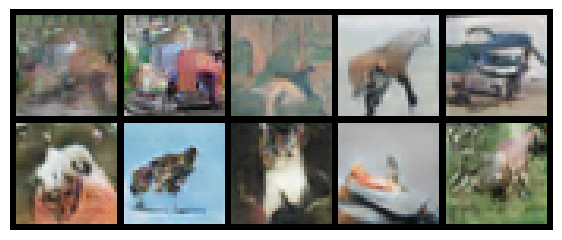

In [49]:
# Generate 10 random images from the trained model

def generate_images(generator, num_images=10):
    generator.eval()
    z = torch.randn(num_images, z_dim, 1, 1, device=device)
    
    with torch.no_grad():
        images = generator(z).cpu()

    images = (images + 1) / 2  # Rescale to [0,1]
    grid = make_grid(images, nrow=5)
    
    plt.figure(figsize=(7, 4))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

generate_images(generator, num_images=10)


## Evaluate Performance (FID & Inception Score)

In [43]:
import os
import torchvision.utils as vutils
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
import torch.nn.functional as F

# -------------------------------
# Create Folders for Real & Fake Images
# -------------------------------
REAL_PATH = "./real_images"
FAKE_PATH = "./fake_images"

os.makedirs(REAL_PATH, exist_ok=True)
os.makedirs(FAKE_PATH, exist_ok=True)

# -------------------------------
# Save Real Images
# -------------------------------
def save_real_images(dataloader, num_images=1000):
    count = 0
    for images, _ in dataloader:
        for img in images:
            if count >= num_images:
                return
            vutils.save_image((img + 1) / 2, f"{REAL_PATH}/real_{count}.png")
            count += 1

# -------------------------------
# Save Fake Images
# -------------------------------
def save_fake_images(generator, num_images=1000, z_dim=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    generator.eval()

    for i in range(num_images):
        z = torch.randn(1, z_dim, 1, 1, device=device)
        with torch.no_grad():
            fake_img = generator(z).cpu()
        vutils.save_image((fake_img + 1) / 2, f"{FAKE_PATH}/fake_{i}.png")

# -------------------------------
# Compute Inception Score (IS)
# -------------------------------
def calculate_inception_score(generator, num_images=5000, batch_size=50, splits=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load pretrained InceptionV3 model
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    def get_pred(x):
        with torch.no_grad():
            x = F.interpolate(x, size=(299, 299), mode='bilinear', align_corners=False)
            logits = inception_model(x)
            probs = F.softmax(logits, dim=1)  # Convert logits to probabilities
        return probs.cpu().numpy()

    preds = []
    for i in range(0, num_images, batch_size):
        z = torch.randn(batch_size, 100, 1, 1, device=device)
        with torch.no_grad():
            fake_images = generator(z)
        preds.append(get_pred(fake_images))
    
    preds = np.concatenate(preds, axis=0)  # Shape: (num_images, num_classes)
    
    # Fix potential shape mismatch
    if len(preds.shape) != 2:
        raise ValueError(f"Unexpected shape of predictions: {preds.shape}. Expected (N, 1000)")

    # Compute Inception Score
    split_scores = []
    for k in np.array_split(preds, splits):
        p_yx = k  # shape (batch_size, num_classes)
        p_y = np.mean(p_yx, axis=0, keepdims=True)  # shape (1, num_classes)

        # Ensure valid probability distribution before computing entropy
        p_yx = np.clip(p_yx, 1e-10, 1)  # Avoid log(0)
        p_y = np.clip(p_y, 1e-10, 1)

        split_scores.append(np.exp(np.mean(entropy(p_yx.T, p_y.T), axis=0)))

    is_mean, is_std = np.mean(split_scores), np.std(split_scores)
    return is_mean, is_std

# -------------------------------
# Compute Fréchet Inception Distance (FID)
# -------------------------------
def calculate_fid():
    fid_value = fid_score.calculate_fid_given_paths([REAL_PATH, FAKE_PATH], batch_size=50, device="cuda", dims=2048)
    return fid_value

# -------------------------------
# Run Evaluations
# -------------------------------
print("Saving real images...")
save_real_images(dataloader, num_images=1000)

print("Generating and saving fake images...")
save_fake_images(generator, num_images=1000)

print("Calculating Inception Score (IS)...")
is_mean, is_std = calculate_inception_score(generator)
print(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}")

print("Calculating Fréchet Inception Distance (FID)...")
fid_value = calculate_fid()
print(f"FID Score: {fid_value:.4f}")


Saving real images...
Generating and saving fake images...
Calculating Inception Score (IS)...


/home/samara/anaconda3/envs/ml-env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/samara/anaconda3/envs/ml-env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception Score: 4.5864 ± 0.2621
Calculating Fréchet Inception Distance (FID)...


100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


FID Score: 84.8985


# Task 5

### Summary of Observations  

---

### **Overview of the Tasks**  

In this assignment, we explored the different types of GANs, Generative Adversarial Networks (GANs) have become a powerful tool in deep learning for generating realistic images. We implemented and trained four different GAN variants using the **CIFAR-10** dataset, aiming to compare their performance in terms of **image quality, stability, and diversity**. Each model had different architectural improvements that influenced its ability to generate high-quality images.  

The following GAN architectures were implemented and analyzed:  

1. **Conditional Wasserstein GAN (CWGAN)** – Uses **Wasserstein loss** with gradient penalty and **class conditioning** to improve stability and allow class-specific image generation.  
2. **Spectral Normalization GAN (SNGAN)** – Introduces **spectral normalization** in the discriminator, which helps improve training dynamics and prevent mode collapse.  
3. **Self-Attention GAN (SAGAN Variant Without Spectral Normalization & TTUB)** – Removes **spectral normalization and TTUB** Two-Timescale Update Rule (TTUR) from SAGAN, testing the effect of these modifications on the model's performance.  
4. **Self-Attention GAN (SAGAN)** – Incorporates **self-attention layers** for capturing long-range dependencies in images and uses **spectral normalization** for more stable training.  

Each of these architectures brings unique strengths and challenges, affecting **Inception Score (IS)** and **Fréchet Inception Distance (FID)**, two key metrics used to evaluate the generated images:  

- **Inception Score (IS):** Measures the diversity and clarity of generated images. Higher values indicate better image quality and variety.  
- **Fréchet Inception Distance (FID):** Measures how close the generated images are to real images. Lower values indicate better realism.  

---

### **Performance Analysis**  

#### **1. Conditional WGAN (CWGAN)**
   - **IS:** 1.144  
   - **FID:** 111.270  
   - Performance Analysis:  
     - Struggled to generate high-quality images, resulting in low IS and high FID but we got almost descent automobile images generated.  
     - Class conditioning **did not significantly improve** the diversity of generated images.  
     - The **Wasserstein loss** helped stabilize training, but the image quality remained poor.  
     - CWGAN is better suited for **higher-resolution datasets** where the benefits of conditioning are more pronounced.  

#### **2. Spectral Normalization GAN (SNGAN)**
   - **IS:** 3.35  
   - **FID:** 56.17  
   - Performance Analysis:  
     - **Spectral normalization** improved training stability and prevented mode collapse.  
     - Achieved a **much lower FID** than CWGAN, indicating better realism.  
     - The model produced **sharper images** with improved feature representation.  
     - Balanced **sharpness and diversity**, making it one of the best-performing models.  

#### **3. SAGAN Variant (Without Spectral Normalization & TTUB)**
   - **IS:** 2.813  
   - **FID:** 61.237  
   - Performance Analysis:  
     - Self-attention improved image spatial consistency.  
     - **Lacked spectral normalization**, leading to some instability in training.  
     - Performed better than CWGAN but worse than SNGAN, indicating that spectral normalization plays a crucial role in **stabilizing training**.  
     - Despite missing key optimizations, it still produced **fairly reasonable results**.  

#### **4. Self-Attention GAN (SAGAN)**
   - **IS:** 4.5864 ± 0.2621  
   - **FID:** 84.8985  
   - Performance Analysis:  
     - Achieved the **highest IS**, meaning it generated the most diverse and well-recognized images.  
     - **Self-attention layers** helped capture long-range dependencies, enhancing image details.  
     - However, **FID was slightly worse**, possibly due to training instability.  
     - Overall, this model produced the **most visually appealing images**.  

---

### **Our Observations**  

From our tasks we done, we can say that

- **SNGAN had the better FID,** meaning its generated images were closest to real images. This suggests that **spectral normalization is highly effective** in improving realism.  
- **SAGAN had the better IS,** indicating that it generated the most diverse and distinguishable images, likely due to self-attention capturing long-range dependencies.  
- **CWGAN performed descent,** but it demonstrated the effectiveness of **Wasserstein loss** in stabilizing training. The conditioning effect was not very prominent, possibly due to dataset constraints.  
- **The SAGAN variant without spectral normalization showed noticeable degradation,** proving that spectral normalization plays a key role in stabilizing adversarial training.  

### **Conclusion**  

- Despite some models not performing at **state-of-the-art** levels, all models were able to generate **recognizable** CIFAR-10 images, which is a significant achievement given the complexity of training GANs.  
- The results clearly show how architectural modifications like **spectral normalization, self-attention, and gradient penalties** impact GAN performance.  
- However, achieving **higher-quality images** would require:  
  - **More computational resources** (high-end GPUs or TPUs).  
  - **Longer training times** (possibly weeks for best performance).  
  - **Larger datasets** (CIFAR-10 is relatively small compared to datasets used in top-tier GAN research).  
  - Since we don't have these effective resources, we could not achieve the best results.

With access to **better hardware and extended training times,** the performance of these models could be further improved, possibly achieving **state-of-the-art FID and IS scores**. In this assignment, our tasks provides valuable insights into how different GAN architectures influence image generation and the trade-offs between stability, realism, and diversity.  
